In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

AUTOTUNE = tf.data.AUTOTUNE

RES_HEIGHT = 24
RES_WIDTH = 32
NUM_CLASS = 1
N_BATCH = 3
N_EPOCH = 200
LR = 0.0002

2024-04-20 15:32:26.454847: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-20 15:32:26.491772: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 15:32:26.491799: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 15:32:26.491821: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-20 15:32:26.499836: I tensorflow/core/platform/cpu_feature_g

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2024-04-20 15:32:28.612121: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 22190 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6
2024-04-20 15:32:28.612962: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:1 with 22190 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1f:00.0, compute capability: 8.6
2024-04-20 15:32:28.613598: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:2 with 22190 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:20:00.0, compute capability: 8.6
2024-04-20 15:32:28.614248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:3 with 22190 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6
2024-04-20 15:32:28.614902: I tensorflow/core/common_runtime/gpu/gpu_dev

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2988913496743470549
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 23267901440
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8396561207348171271
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 23267901440
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13710495873859337434
 physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1f:00.0, compute capability: 8.6"
 xla_global_id: 2144165316,
 name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 23267901440
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7109141559218415058
 physical_device_desc: "device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:20:00.0, compute capability: 8.6"
 xla_global_

### 현제 바운딩박스는 xmin, ymin, xmax, ymax 

In [3]:
import numpy as np

datasets = np.load('dataset/ObjectDetection.npz', allow_pickle=True)
images, numbers, bboxes = datasets['images'], datasets['numbers'], datasets['bboxes']

max_label_length = 4
labels = []
for num in numbers:
    cls = [1] * num if num != 0 else [0]
    cls += [0] * (max_label_length - len(cls))
    labels.append(cls)

# labels = np.array(labels)

# non_zero_indices = np.where(numbers != 0)[0]
non_zero_indices = np.where(numbers > 1)[0]

# numbers가 0이 아닌 항목만 유지
images_filtered = images[non_zero_indices]
bboxes_filtered = bboxes[non_zero_indices]
labels_filtered = np.array(labels)[non_zero_indices]

print(images.shape, numbers.shape, bboxes.shape, len(labels))

print(images.max(), images.min())

dataset = {
    'images' : images_filtered,
    'bboxes' : bboxes_filtered,
    'class' : labels_filtered
}

print(dataset['images'].shape)
print(dataset['bboxes'].shape)
print(len(dataset['class']))
print(dataset['class'])


(17820, 24, 32, 1) (17820,) (17820, 4, 4) 17820
255 0
(13544, 24, 32, 1)
(13544, 4, 4)
13544
[[1 1 0 0]
 [1 1 0 0]
 [1 1 0 0]
 ...
 [1 1 1 0]
 [1 1 1 0]
 [1 1 1 0]]


In [4]:
print(dataset['class'])

[[1 1 0 0]
 [1 1 0 0]
 [1 1 0 0]
 ...
 [1 1 1 0]
 [1 1 1 0]
 [1 1 1 0]]


[[ 3  3 14 14]
 [24  0 32  6]
 [ 0  0  0  0]
 [ 0  0  0  0]]
255 0


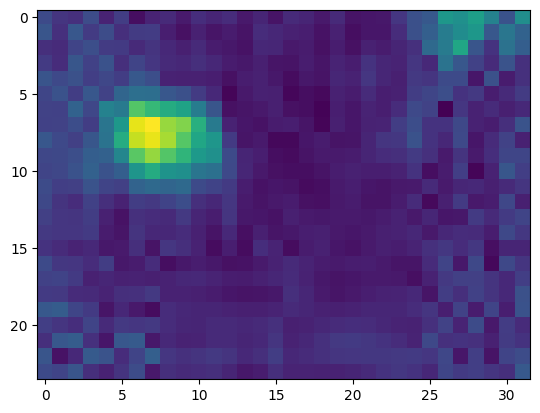

In [5]:
plt.imshow(dataset['images'][0])
print(dataset['bboxes'][0])
print(dataset['images'].max(), dataset['images'].min())

(24, 32, 1)
24
32
bbox:  tf.Tensor(
[[ 3  3 14 14]
 [24  0 32  6]
 [ 0  0  0  0]
 [ 0  0  0  0]], shape=(4, 4), dtype=int64)


2024-04-20 15:32:28.859752: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22190 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6
2024-04-20 15:32:28.859971: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22190 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1f:00.0, compute capability: 8.6
2024-04-20 15:32:28.860167: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22190 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:20:00.0, compute capability: 8.6
2024-04-20 15:32:28.860361: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22190 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

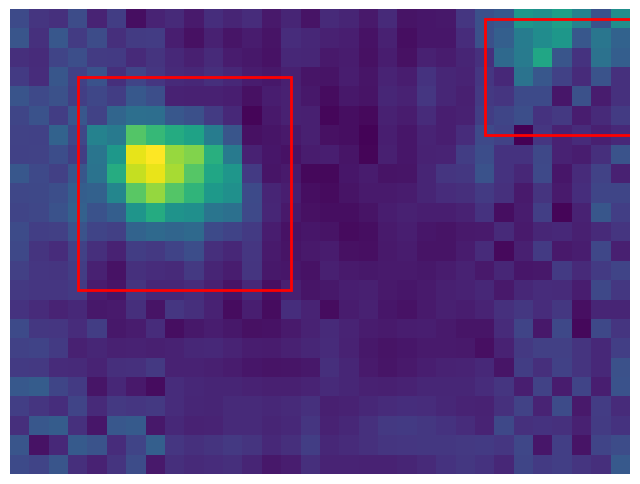

[[1 1 0 0]
 [1 1 0 0]
 [1 1 0 0]
 ...
 [1 1 1 0]
 [1 1 1 0]
 [1 1 1 0]]


In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
images = dataset['images']
bboxes = dataset['bboxes']
cls = dataset['class']

boxes = bboxes
plt.figure(figsize = (8, 8))
plt.axis('off')
image = images
print(image[0].shape)
print(image[0].shape[0])
print(image[0].shape[1])
plt.imshow(image[0])
ax = plt.gca()
boxes = boxes[0]
boxes = tf.stack([
	(boxes[:, 0] ), 
	(boxes[:, 1] ),
	(boxes[:, 2] ),
	(boxes[:, 3] )], axis = -1
)
print("bbox: ", boxes)
# 각 바운딩 박스에 대해 반복하여 그리기
for box in boxes:
    xmin, ymin, xmax, ymax = box 
    w, h = xmax - xmin, ymax - ymin
    patch = plt.Rectangle(
        [xmin, ymin], w, h, fill=False, edgecolor=[1, 0, 0], linewidth=2
    )
    ax.add_patch(patch)
plt.show()
print(cls)

In [7]:
images.max(), images.min()

(255, 0)

In [8]:
import os
import random
import tensorflow as tf

IMG_SIZE_WIDTH = images.shape[2]
IMG_SIZE_HEIGHT = images.shape[1]
N_DATA = images.shape[0]
N_VAL = int(images.shape[0] * 0.2)
N_TRAIN = int(images.shape[0] - N_VAL)

cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'test/tfrecord/')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'od_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'od_val.tfr')

print("IMG_SIZE_WIDTH:  ", IMG_SIZE_WIDTH)
print("IMG_SIZE_HEIGHT: ", IMG_SIZE_HEIGHT)
print("N_DATA:          ", N_DATA)
print("N_TRAIN:         ", N_TRAIN)
print("N_VAL:           ", N_VAL)

shuffle_list = list(range(N_DATA))
random.shuffle(shuffle_list)

train_idx_list = shuffle_list[:N_TRAIN]
val_idx_list = shuffle_list[N_TRAIN:]

tfr_train_dir = os.path.join(tfr_dir, 'od_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'od_val.tfr')

writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

IMG_SIZE_WIDTH:   32
IMG_SIZE_HEIGHT:  24
N_DATA:           13544
N_TRAIN:          10836
N_VAL:            2708


In [9]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

def _float_feature(value):
    return tf.train.Feature(float_list = tf.train.FloatList(value = value))

def _int64_feature(value):
    return tf.train.Feature(int32_list = tf.train.Int64List(value = [value]))


def _bytes_feature_list(value_list):
    """value_list가 리스트일 때, 이를 serialize하여 bytes list로 변환하는 함수."""
    value_list = [tf.io.serialize_tensor(tf.constant(v)).numpy() for v in value_list]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value_list))


In [10]:
dataset['images'] = dataset['images']
dataset['bboxes'] = dataset['bboxes']
dataset['class'] = np.array(dataset['class'])
images = dataset['images']
bboxes = dataset['bboxes']
cls = dataset['class']
print(images.shape)
print(bboxes.shape)
print(cls.shape)


(13544, 24, 32, 1)
(13544, 4, 4)
(13544, 4)


In [11]:
for idx in train_idx_list:
    bbox = bboxes[idx]
    xmin, ymin, xmax, ymax = bbox[:, 0] / RES_WIDTH, bbox[:, 1] / RES_HEIGHT, bbox[:, 2] / RES_WIDTH, bbox[:, 3] / RES_HEIGHT
    bbox = np.stack([xmin, ymin, xmax, ymax], axis=-1).flatten()

    image = images[idx]
    bimage = image.tobytes()

    number = numbers[idx]
    class_id = cls[idx]
    # print(len(cls))
    serialized_cls = tf.io.serialize_tensor(tf.constant(class_id)).numpy()

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'bbox': _float_feature(bbox),
        'label': _bytes_feature(serialized_cls),
        # 'number': _int64_feature(number)
    }))
    
    writer_train.write(example.SerializeToString())
writer_train.close()


In [12]:
for idx in val_idx_list:
    bbox = bboxes[idx]
    xmin, ymin, xmax, ymax = bbox[:, 0] / RES_WIDTH, bbox[:, 1] / RES_HEIGHT, bbox[:, 2] / RES_WIDTH, bbox[:, 3] / RES_HEIGHT
    bbox = np.stack([xmin, ymin, xmax, ymax], axis=-1).flatten()

    image = images[idx]
    bimage = image.tobytes()

    number = numbers[idx]
    class_id = cls[idx]
    # print(len(cls))
    serialized_cls = tf.io.serialize_tensor(tf.constant(class_id)).numpy()

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'bbox': _float_feature(bbox),
        'label': _bytes_feature(serialized_cls),
        # 'number': _int64_feature(number)
    }))
    
    writer_val.write(example.SerializeToString())
writer_val.close()


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

N_BATCH = 1
# LR = 0.0005


def _parse_function(tfrecord_serialized):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'bbox': tf.io.VarLenFeature(tf.float32),  
        'label': tf.io.FixedLenFeature([], tf.string),
        # 'number': tf.io.FixedLenFeature([], tf.int64)
    }

    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)

    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [RES_HEIGHT, RES_WIDTH, 1])
    image = tf.cast(image, tf.float32) 
    # image = image / tf.reduce_max(image)

    bbox = tf.sparse.to_dense(parsed_features['bbox']) 
    bbox = tf.cast(bbox, tf.float32)
    # num_boxes = tf.shape(bbox)[0] // 4
    bbox = tf.reshape(bbox, [-1, 4])

    serialized_cls = parsed_features['label']
    label = tf.io.parse_tensor(serialized_cls, out_type=tf.int64)
    
    # number = tf.cast(parsed_features['number'], tf.int64)
    return image, bbox, label



train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(AUTOTUNE).batch(N_BATCH, drop_remainder=True)

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

N_BATCH = 1
# LR = 0.0005


def _parse_function(tfrecord_serialized):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'bbox': tf.io.VarLenFeature(tf.float32),  
        'label': tf.io.FixedLenFeature([], tf.string),
        # 'number': tf.io.FixedLenFeature([], tf.int64)
    }

    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)

    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [RES_HEIGHT, RES_WIDTH, 1])
    image = tf.cast(image, tf.float32) 
    # image = image / tf.reduce_max(image)

    bbox = tf.sparse.to_dense(parsed_features['bbox']) 
    bbox = tf.cast(bbox, tf.float32)
    # num_boxes = tf.shape(bbox)[0] // 4
    bbox = tf.reshape(bbox, [-1, 4])

    serialized_cls = parsed_features['label']
    label = tf.io.parse_tensor(serialized_cls, out_type=tf.int64)
    
    # number = tf.cast(parsed_features['number'], tf.int64)
    return image, bbox, label



val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=N_TRAIN).prefetch(AUTOTUNE).batch(N_BATCH, drop_remainder=True)

In [15]:
for img, bbox, label in val_dataset.take(1):
    print(img.shape)
    print(bbox)
    print(label)

(1, 24, 32, 1)
tf.Tensor(
[[[0.8125     0.         1.         0.29166666]
  [0.6875     0.29166666 1.         0.5416667 ]
  [0.         0.         0.         0.        ]
  [0.         0.         0.         0.        ]]], shape=(1, 4, 4), dtype=float32)
tf.Tensor([[1 1 0 0]], shape=(1, 4), dtype=int64)


(24, 32, 1)
tf.Tensor([1 1 1 0], shape=(4,), dtype=int64)
tf.Tensor(
[[0.71875    0.08333334 1.         0.33333334]
 [0.15625    0.         0.40625    0.20833333]
 [0.09375    0.6666667  0.3125     0.9583333 ]
 [0.         0.         0.         0.        ]], shape=(4, 4), dtype=float32)


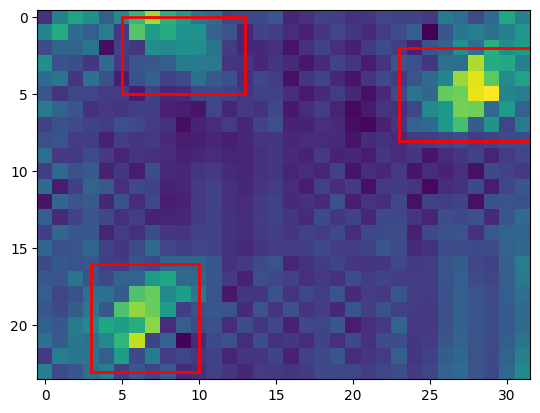

In [16]:
import matplotlib.pyplot as plt

idx = 0
for image, bbox, label in val_dataset.take(1):
    image = image[idx]
    bbox = bbox[idx]
    label = label[idx]
    image = image.numpy()
    plt.imshow(image)
    ax = plt.gca()  
    print(image.shape)
    print(label)
    print(bbox)
    boxes = tf.stack(
    	[
    	 bbox[:,0] * RES_WIDTH,
    	 bbox[:,1] * RES_HEIGHT,
    	 bbox[:,2] * RES_WIDTH,
    	 bbox[:,3] * RES_HEIGHT
    	], axis = -1
    )
    for box in boxes:
        xmin, ymin = box[:2]
        w, h = box[2:] - box[:2]
        patch = plt.Rectangle(
            [xmin, ymin], w, h, fill=False, edgecolor=[1, 0, 0], linewidth=2
        )
        ax.add_patch(patch)
    plt.show()

In [17]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1
    )

def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1
    )

In [18]:
def preprocess_data(image, gt_boxes, cls_ids):
    bbox = convert_to_xywh(gt_boxes)
    return image, bbox, cls_ids

In [19]:
for image, bbox, label in val_dataset.take(1):
    print(image.shape)
    print(bbox.shape)
    print(label.shape)

(1, 24, 32, 1)
(1, 4, 4)
(1, 4)


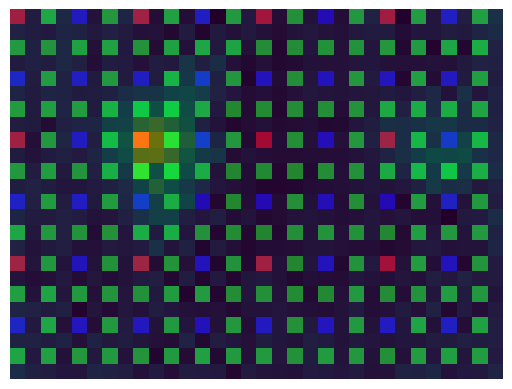

tf.Tensor(253.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


In [20]:
idx = 0
for image, bbox, label in train_dataset.take(1):
    anchor_img = np.zeros((*image.shape[:3], 3), dtype=np.uint8)
    anchor_img = anchor_img[idx]

    strides = [2, 4, 8]
    colors = {
        2: [0, 255, 0],  # 초록색
        4: [0, 0, 255],  # 파란색
        8: [255, 0, 0],   # 빨간색
    }

    for stride in strides:
        color = colors[stride]
        for y in range(0, anchor_img.shape[0], stride):
            for x in range(0, anchor_img.shape[1], stride):
                anchor_img[y, x, :] = color

    # 이미지 표시
    plt.imshow(image[idx], alpha=1)  
    plt.imshow(anchor_img, alpha=0.5) 
    plt.axis('off')
    plt.show()
    print(tf.reduce_max(image), tf.reduce_min(image))

(24, 32, 1)
tf.Tensor(
[[0.703125   0.8958334  0.21875    0.20833331]
 [0.640625   0.5833333  0.21875    0.33333334]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]], shape=(4, 4), dtype=float32)
tf.Tensor([1 1 0 0], shape=(4,), dtype=int64)
tf.Tensor(254.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
width:  32
height:  24
bbox:  tf.Tensor(
[[0.59375    0.79166675 0.21875    0.20833331]
 [0.53125    0.41666663 0.21875    0.33333334]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]], shape=(4, 4), dtype=float32)
tf.Tensor([0.59375    0.79166675 0.21875    0.20833331], shape=(4,), dtype=float32)
tf.Tensor([0.53125    0.41666663 0.21875    0.33333334], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)


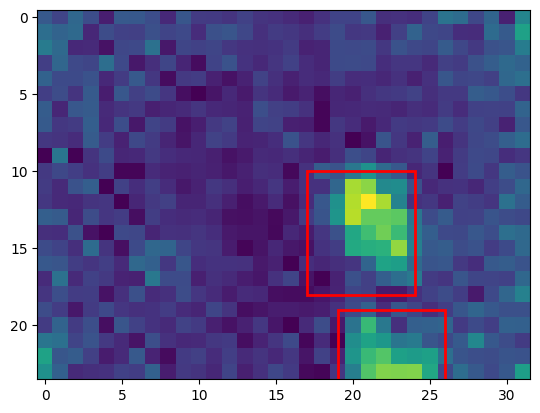

tf.Tensor([1 1 0 0], shape=(4,), dtype=int64)


In [21]:
idx = 0
for image, bbox, label in val_dataset.take(1):
    image, bbox, label = preprocess_data(image, bbox, label)
    img = image[idx]
    box = bbox[idx]
    label = label[idx]
    print(img.shape)
    print(box)
    print(label)
    print(tf.reduce_max(image), tf.reduce_min(image))
    # 이미지 시각화
    plt.imshow(img)
    ax = plt.gca()
    width = img.shape[1]
    height = img.shape[0]
    print("width: ", width)
    print("height: ", height)
    boxes = tf.stack(
        [
            (box[:, 0] - 0.5 * box[:, 2]),  # xmin = x_center - width/2
            (box[:, 1] - 0.5 * box[:, 3]),  # ymin = y_center - height/2
            box[:, 2],
            box[:, 3],
            
        ], axis=-1
    )
    print("bbox: ", boxes)
    # 각 바운딩 박스에 대해 반복하여 그리기
    for box in boxes:
        xmin, ymin, w, h = box
        print(box)
        patch = plt.Rectangle(
            [xmin * RES_WIDTH, ymin * RES_HEIGHT], w * RES_WIDTH, h * RES_HEIGHT, fill=False, edgecolor=[1, 0, 0], linewidth=2
        )
        ax.add_patch(patch)
    plt.show()
    print(label)
 

(24, 32, 1)
tf.Tensor(
[[0.484375   0.10416666 0.21875    0.20833333]
 [0.8125     0.33333334 0.375      0.3333333 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]], shape=(4, 4), dtype=float32)
tf.Tensor([1 1 0 0], shape=(4,), dtype=int64)
tf.Tensor(244.0, shape=(), dtype=float32) tf.Tensor(4.0, shape=(), dtype=float32)
width:  32
height:  24
bbox:  tf.Tensor(
[[0.375      0.         0.21875    0.20833333]
 [0.625      0.16666669 0.375      0.3333333 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]], shape=(4, 4), dtype=float32)
tf.Tensor([0.375      0.         0.21875    0.20833333], shape=(4,), dtype=float32)
tf.Tensor([0.625      0.16666669 0.375      0.3333333 ], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)


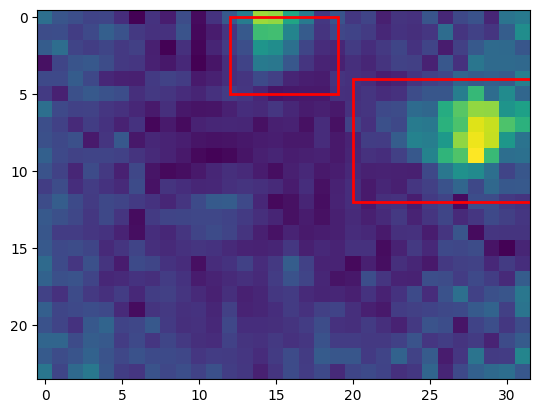

tf.Tensor([1 1 0 0], shape=(4,), dtype=int64)


In [22]:
idx = 0
for image, bbox, label in train_dataset.take(1):
    image, bbox, label = preprocess_data(image, bbox, label)
    img = image[idx]
    box = bbox[idx]
    label = label[idx]
    print(img.shape)
    print(box)
    print(label)
    print(tf.reduce_max(image), tf.reduce_min(image))
    # 이미지 시각화
    plt.imshow(img)
    ax = plt.gca()
    width = img.shape[1]
    height = img.shape[0]
    print("width: ", width)
    print("height: ", height)
    boxes = tf.stack(
        [
            (box[:, 0] - 0.5 * box[:, 2]),  # xmin = x_center - width/2
            (box[:, 1] - 0.5 * box[:, 3]),  # ymin = y_center - height/2
            box[:, 2],
            box[:, 3],
            
        ], axis=-1
    )
    print("bbox: ", boxes)
    # 각 바운딩 박스에 대해 반복하여 그리기
    for box in boxes:
        xmin, ymin, w, h = box
        print(box)
        patch = plt.Rectangle(
            [xmin * RES_WIDTH, ymin * RES_HEIGHT], w * RES_WIDTH, h * RES_HEIGHT, fill=False, edgecolor=[1, 0, 0], linewidth=2
        )
        ax.add_patch(patch)
    plt.show()
    print(label)
 

In [23]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.6, 1.1, 1.6]         # 이거랑 2268
        self.scales = [2** x for x in [0, 1/3, 2/3]] # 이걸로 바운딩박스 갯수 조절가능
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(0, 3)]
        self._areas = [x ** 2 for x in [5.5, 6.2, 6.8]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []

        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios: 
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis = -1), [1, 1, 2]
                )
                for scale in self.scales: 
                    anchor_dims.append(scale * dims) 
            anchor_dims_all.append(tf.stack(anchor_dims, axis = -2))
        return anchor_dims_all 
    
    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype = tf.float32) + 0.5
        ry = tf.range(feature_height, dtype = tf.float32) + 0.5

        centers = tf.stack(tf.meshgrid(rx, ry), axis = -1) * self._strides[level - 0] # stride시작점에 따라 바꿔야함 
        centers = tf.expand_dims(centers, axis = -2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])

        dims = tf.tile(
            self._anchor_dims[level - 0], [feature_height, feature_width, 1, 1] 
        )

        anchors = tf.concat([centers, dims], axis=-1) 

        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i), # 올림
                tf.math.ceil(image_width / 2 ** i),
                i
            )
            for i in range(0, 3)
        ]

        return tf.concat(anchors, axis=0)

Anchor 음수 값: False
tf.Tensor(
[[ 0.5        0.5        4.2602816  7.1004696]
 [ 0.5        0.5        5.3676186  8.946032 ]
 [ 0.5        0.5        6.7627754 11.271293 ]
 ...
 [30.        22.         8.601397   5.3758717]
 [30.        22.        10.837081   6.773174 ]
 [30.        22.        13.653866   8.533664 ]], shape=(9072, 4), dtype=float32)
(9072, 4)
(24, 32, 1)
[[0.40625    0.5416667  0.30877706 0.25731423]
 [0.734375   0.35416666 0.22711846 0.27529505]
 [0.109375   0.1875     0.1331338  0.2958529 ]
 [0.921875   0.14583333 0.18026404 0.21850182]
 [0.140625   0.8125     0.28615132 0.34685004]
 [0.65625    0.625      0.23823413 0.5294092 ]
 [0.4375     0.41666666 0.4266833  0.35556933]
 [0.484375   0.7291667  0.16773808 0.37275133]
 [0.234375   0.47916666 0.18026404 0.21850182]
 [0.03125    0.9583333  0.2032067  0.24631117]
 [0.734375   0.9375     0.1331338  0.2958529 ]
 [0.640625   0.1875     0.21133673 0.4696372 ]
 [0.34375    0.7916667  0.38903472 0.3241956 ]
 [0.703125   0.1

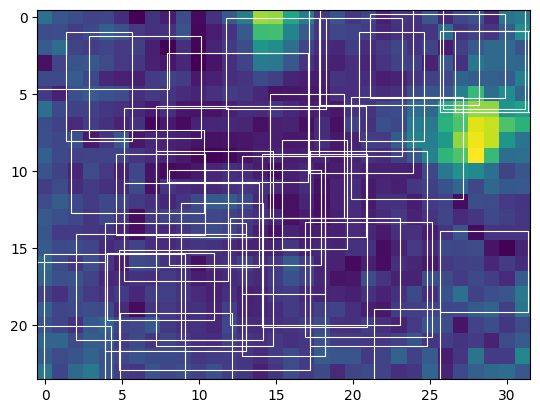

In [24]:
anchors = AnchorBox()
anchor = anchors.get_anchors(24, 32)

# 앵커 박스 정규화
xmin = anchor[:, 0] / RES_WIDTH
ymin = anchor[:, 1] / RES_HEIGHT
xmax = anchor[:, 2] / RES_WIDTH
ymax = anchor[:, 3] / RES_HEIGHT

# 정규화된 좌표를 스택으로 결합
normalized_anchor = tf.stack([xmin, ymin, xmax, ymax], axis=-1)

has_negative_values = tf.reduce_any(tf.less(anchor, 0))
print("Anchor 음수 값:", has_negative_values.numpy())

print(anchor)
print(anchor.shape)
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bounding_boxes(data, num_samples):
    fig, ax = plt.subplots()

    plt.imshow(img)
    print(img.shape)
    data_np = data.numpy()

    if len(data) > num_samples:
        sampled_indices = np.random.choice(len(data), num_samples, replace=False)
        sample_data = data_np[sampled_indices]
    else : 
        sample_data = data_np
    print(sample_data)
    for center_x, center_y, width, height in sample_data:
        top_left_x = center_x - width / 2
        top_left_y = center_y - height / 2

        rect = patches.Rectangle((top_left_x * RES_WIDTH, top_left_y * RES_HEIGHT), width * RES_WIDTH, height * RES_HEIGHT, linewidth=0.8, edgecolor='white', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

draw_bounding_boxes(normalized_anchor, 40)


In [25]:
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    print(boxes1_corners.shape)
    print(boxes2_corners.shape)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])  
    
    intersection = tf.maximum(rd - lu, 0.0)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = (boxes1_corners[:, 2] - boxes1_corners[:, 0]) * (boxes1_corners[:, 3] - boxes1_corners[:, 1])
    boxes2_area = (boxes2_corners[:, 2] - boxes2_corners[:, 0]) * (boxes2_corners[:, 3] - boxes2_corners[:, 1])
    union_area = tf.maximum(boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8)

    return intersection_area / union_area

In [26]:
GA = np.array([[50, 30, 70, 60], [50, 30, 70, 60]])  # 예: [xmin, ymin, xmax, ymax]
GT = np.array([[50, 30, 70, 60], [35, 45, 55, 75]])  # 예: [xmin, ymin, xmax, ymax]

print("GA.shape:", GA.shape)
print("GT.shape:", GT.shape)

GA_xywh = convert_to_xywh(GA)
print("GA (XYWH):", GA_xywh)

GT_xywh = convert_to_xywh(GT)
print("GT (XYWH):", GT_xywh)

iou = compute_iou(GA_xywh, GT_xywh)
print("IoU:", iou)
# GA = convert_to_corners(GA)
# print(GA)
# GT = convert_to_corners(GT)
# print(GT)

GA.shape: (2, 4)
GT.shape: (2, 4)
GA (XYWH): tf.Tensor(
[[60. 45. 20. 30.]
 [60. 45. 20. 30.]], shape=(2, 4), dtype=float64)
GT (XYWH): tf.Tensor(
[[60. 45. 20. 30.]
 [45. 60. 20. 30.]], shape=(2, 4), dtype=float64)
(2, 4)
(2, 4)
IoU: tf.Tensor(
[[1.         0.06666667]
 [1.         0.06666667]], shape=(2, 2), dtype=float64)


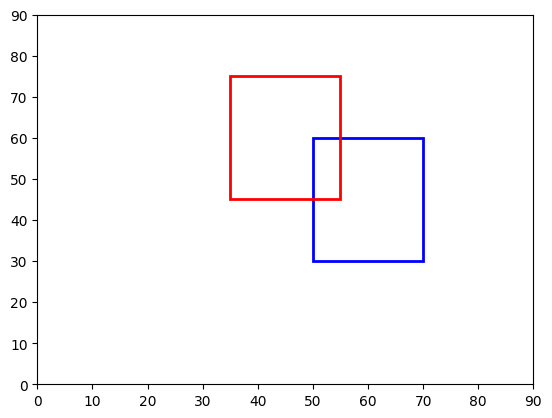

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 주어진 바운딩 박스 데이터
box1 = [50, 30, 70, 60]  # [x_min, y_min, x_max, y_max]
box2 = [35, 45, 55, 75]

# 그림 생성
fig, ax = plt.subplots()

# 첫 번째 바운딩 박스 추가
rect1 = patches.Rectangle((box1[0], box1[1]), box1[2] - box1[0], box1[3] - box1[1], 
                          linewidth=2, edgecolor='blue', facecolor='none')
ax.add_patch(rect1)

# 두 번째 바운딩 박스 추가
rect2 = patches.Rectangle((box2[0], box2[1]), box2[2] - box2[0], box2[3] - box2[1], 
                          linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect2)

# 축 범위 설정
ax.set_xlim(0, 90)
ax.set_ylim(0, 90)

# 그림 표시
plt.show()



In [28]:
def match_anchor_boxes(anchor_boxes, gt_boxes, match_iou = 0.5, ignore_iou = 0.4):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        print("iou_matrix:  ", iou_matrix)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        print("max_iou:  ", max_iou)


        matched_gt_idx = tf.argmax(iou_matrix, axis = 1)
        print("matched_gt_idx:  ", matched_gt_idx)
    
        positive_mask = tf.greater_equal(max_iou, match_iou)
        print("positive_mask:  ", positive_mask)
        negative_mask = tf.less(max_iou, ignore_iou)
        print("negative_mask:  ", negative_mask)

        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        print("ignore_mask:  ", ignore_mask)
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype = tf.float32),
            tf.cast(ignore_mask, dtype = tf.float32),
        )
        

In [29]:
anchor = np.array([
                    [27.,  18.5,  8.,   7.],
                    [18.5, 15.5, 11.,   7.],
                    [ 6.,   4.,   8.,   6.],
                    [ 0.,   0.,   0.,   0.],
                    [ 1., 1., 4.242641, 8.485281 ],
                    [ 1.,         1.,         5.3453927, 10.690784 ],
                    [ 1.,         1.,         6.7347727, 13.469543 ],
                    [30.,        22.,         9.899496,   4.949747 ]])

gt_boxes = np.array([[27.,  18.5,  8.,   7., ],
                     [18.5, 15.5, 11.,   7. ],
                     [ 6.,   4.,   8.,   6. ],
                     [ 0.,   0.,   0.,   0. ]])
# print(gt_boxes.shape)
a, b, c = match_anchor_boxes(tf.cast(anchor, tf.float32), tf.cast(gt_boxes, tf.float32))

(8, 4)
(4, 4)
iou_matrix:   tf.Tensor(
[[1.         0.03100775 0.         0.        ]
 [0.03100775 1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.06003535 0.        ]
 [0.         0.         0.09293901 0.        ]
 [0.         0.         0.11408175 0.        ]
 [0.16311106 0.         0.         0.        ]], shape=(8, 4), dtype=float32)
max_iou:   tf.Tensor(
[1.         1.         1.         0.         0.06003535 0.09293901
 0.11408175 0.16311106], shape=(8,), dtype=float32)
matched_gt_idx:   tf.Tensor([0 1 2 0 2 2 2 0], shape=(8,), dtype=int64)
positive_mask:   tf.Tensor([ True  True  True False False False False False], shape=(8,), dtype=bool)
negative_mask:   tf.Tensor([False False False  True  True  True  True  True], shape=(8,), dtype=bool)
ignore_mask:   tf.Tensor([False False False False False False False False], shape=(8,), dtype=bool)


In [30]:
class LabelEncoder:
    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32)
    
    def _match_anchor_boxes(self, anchor_boxes, gt_boxes, match_iou = 0.5, ignore_iou = 0.4):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        print("iou_matrix:  ", iou_matrix.shape)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        print("max_iou:  ", max_iou.shape)

        matched_gt_idx = tf.argmax(iou_matrix, axis = 1)
        print("matched_gt_idx:  ", matched_gt_idx)
        print("max_iou:", max_iou)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        print("positive_mask:  ", positive_mask)
        negative_mask = tf.less(max_iou, ignore_iou)
        print("negative_mask:  ", negative_mask.shape)

        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        print("ignore_mask:  ", ignore_mask.shape)
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype = tf.float32),
            tf.cast(ignore_mask, dtype = tf.float32),
        )
    
    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        print("_compute_box_target anchor_boxes: ", anchor_boxes)
        print("_compute_box_target matched_gt_boxes : ", matched_gt_boxes)
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:])
            ],
            axis = -1,
        )
        print("box_target:  ", box_target)
        box_target = box_target / self._box_variance
        print("box_target:  ", box_target)
        return box_target
    

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):        
        print("image_shape:", image_shape.shape)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        # 앵커 박스 정규화
        xmin = anchor_boxes[:, 0] / RES_WIDTH
        ymin = anchor_boxes[:, 1] / RES_HEIGHT
        xmax = anchor_boxes[:, 2] / RES_WIDTH
        ymax = anchor_boxes[:, 3] / RES_HEIGHT

        # 정규화된 좌표를 스택으로 결합
        normalized_anchor = tf.stack([xmin, ymin, xmax, ymax], axis=-1)
        
        print("anchor_boxes  : ", normalized_anchor)
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        print("cls_ids", cls_ids)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            normalized_anchor, gt_boxes
        )
        print("matched_gt_idx:  ", matched_gt_idx)
        print("positive_mask:  ", positive_mask)
        print("ignore_mask:  ", ignore_mask)

        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)

        print("matched_gt_boxes:  ", matched_gt_boxes)
        
        box_target = self._compute_box_target(normalized_anchor, matched_gt_boxes)
        print("box_target:  ", box_target)

        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        print("matched_gt_cls_ids:  ", matched_gt_cls_ids)
        
        cls_target = tf.where(tf.cast(positive_mask, tf.bool), matched_gt_cls_ids, -1.0)
        cls_target = tf.where(tf.cast(ignore_mask, tf.bool), -2.0, cls_target)

        print("cls_target:  ", cls_target)

        cls_target = tf.expand_dims(cls_target, axis=-1)
        print("cls_target:  ", cls_target)
        num_ones = tf.math.count_nonzero(tf.equal(cls_target, 1.0))
        print("Number of 1.0 values in cls_target:", num_ones)


        label = tf.concat([box_target, cls_target], axis=-1)
        print("label:  ", label)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):       
        images_shape = tf.shape(batch_images)
        print("images_shape:  ", images_shape)
        batch_size = images_shape[0]
        print("batch_size:  ", batch_size)

        print("gt_boxes: ", gt_boxes)

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        print("labels:  ", labels)
        # batch_size_val = batch_size.numpy()
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            print("label:  ", label)
            labels = labels.write(i, label)
        return batch_images, labels.stack()

In [31]:
print("Eager execution: ", tf.executing_eagerly())
if not tf.executing_eagerly():
    tf.compat.v1.enable_eager_execution()

Eager execution:  True


In [32]:
label_encoder = LabelEncoder()

for image, bbox, label in train_dataset.take(1):
    img, box, label = preprocess_data(image, bbox, label)
    print(img.shape, box.shape, label.shape)

    label_encoder.encode_batch(img, box, label)
    

(1, 24, 32, 1) (1, 4, 4) (1, 4)
images_shape:   tf.Tensor([ 1 24 32  1], shape=(4,), dtype=int32)
batch_size:   tf.Tensor(1, shape=(), dtype=int32)
gt_boxes:  tf.Tensor(
[[[0.8125     0.7916666  0.3125     0.16666669]
  [0.6875     0.6041666  0.25       0.20833331]
  [0.         0.         0.         0.        ]
  [0.         0.         0.         0.        ]]], shape=(1, 4, 4), dtype=float32)
labels:   <tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x7fbb7413d5b0>
image_shape: (4,)
anchor_boxes  :  tf.Tensor(
[[0.015625   0.02083333 0.1331338  0.2958529 ]
 [0.015625   0.02083333 0.16773808 0.37275133]
 [0.015625   0.02083333 0.21133673 0.4696372 ]
 ...
 [0.9375     0.9166667  0.26879364 0.22399466]
 [0.9375     0.9166667  0.33865878 0.28221557]
 [0.9375     0.9166667  0.4266833  0.35556933]], shape=(9072, 4), dtype=float32)
cls_ids tf.Tensor([1. 1. 0. 0.], shape=(4,), dtype=float32)
(9072, 4)
(4, 4)
iou_matrix:   (9072, 4)
max_iou:   (9072,)
matched_gt_idx:   tf.Tensor(

In [33]:
label_encoder = LabelEncoder()

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)

In [34]:
for img, bbox, label in train_dataset.take(1):
    print(img.shape)
    print(bbox.shape)
    print(label.shape)

(1, 24, 32, 1)
(1, 4, 4)
(1, 4)


In [35]:
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)

images_shape:   Tensor("Shape:0", shape=(4,), dtype=int32)
batch_size:   Tensor("strided_slice:0", shape=(), dtype=int32)
gt_boxes:  Tensor("args_1:0", shape=(1, None, 4), dtype=float32)
labels:   <tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x7fbb740f6700>
image_shape: (4,)
anchor_boxes  :  Tensor("while/stack_3:0", shape=(None, 4), dtype=float32)
cls_ids Tensor("while/Cast:0", dtype=float32)
(None, 4)
(None, 4)
iou_matrix:   (None, None)
max_iou:   (None,)
matched_gt_idx:   Tensor("while/ArgMax:0", shape=(None,), dtype=int64)
max_iou: Tensor("while/Max:0", shape=(None,), dtype=float32)
positive_mask:   Tensor("while/GreaterEqual:0", shape=(None,), dtype=bool)
negative_mask:   (None,)
ignore_mask:   (None,)
matched_gt_idx:   Tensor("while/ArgMax:0", shape=(None,), dtype=int64)
positive_mask:   Tensor("while/Cast_1:0", shape=(None,), dtype=float32)
ignore_mask:   Tensor("while/Cast_2:0", shape=(None,), dtype=float32)
matched_gt_boxes:   Tensor("while/GatherV2:0", shape

In [36]:
positive_count = []
negative_count = []
ignore_count = []
for batch in train_dataset.take(3):
    images, labels = batch
    print(np.array(images).max(), np.array(images).min())
    print(labels.shape)

    # labels 텐서에서 positive, negative, ignore 값의 개수를 계산
    positive_count = tf.reduce_sum(tf.cast(tf.equal(labels[0, :, 4], 1.0), tf.int32))
    negative_count = tf.reduce_sum(tf.cast(tf.equal(labels[0, :, 4], -1.0), tf.int32))
    ignore_count = tf.reduce_sum(tf.cast(tf.equal(labels[0, :, 4], -2.0), tf.int32))

    print("Positive 개수:", positive_count.numpy())
    print("Negative 개수:", negative_count.numpy())
    print("Ignore 개수:", ignore_count.numpy())


251.0 0.0
(1, 9072, 5)
Positive 개수: 364
Negative 개수: 8219
Ignore 개수: 489
245.0 0.0
(1, 9072, 5)
Positive 개수: 171
Negative 개수: 8662
Ignore 개수: 239
246.0 0.0
(1, 9072, 5)
Positive 개수: 175
Negative 개수: 8643
Ignore 개수: 254


Positive 개수: 313
Negative 개수: 8318
Ignore 개수: 441
Positive 313


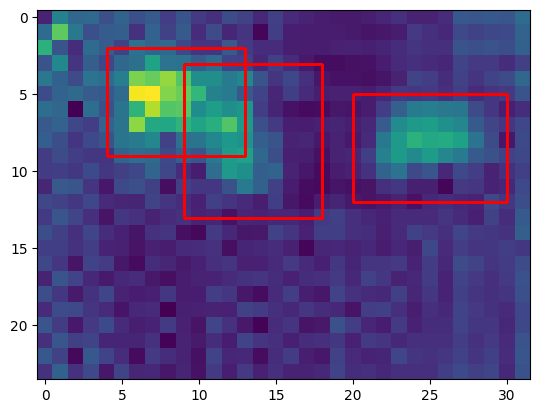

In [37]:
def decode_predictions(labels, anchors, box_variance=[0.1, 0.1, 0.2, 0.2]):
    decoded_boxes = []
    label_idx = 0
    for label in labels:
        # if label[4] == 1.0:
        #     print("label:", label)
        # elif label[4] == -1.0:
        #     print("label:", label)
        dx, dy, dw, dh = label[:4]
        anchor = anchors[label_idx]
        anchor_x, anchor_y, anchor_w, anchor_h = anchor
        cx = dx * box_variance[0] * anchor_w + anchor_x
        cy = dy * box_variance[1] * anchor_h + anchor_y
        width = np.exp(dw * box_variance[2]) * anchor_w
        height = np.exp(dh * box_variance[3]) * anchor_h
        x_min = cx - width / 2
        y_min = cy - height / 2
        decoded_box = [x_min, y_min, width, height]
        # print(np.array(decoded_box))
        if label[4] == 1.0:
            decoded_boxes.append(decoded_box)
        label_idx += 1
        # if len(np.array(decoded_boxes)) > 1: 
            # break
    print("Positive",len(np.array(decoded_boxes)))
    return decoded_boxes    
    # print(np.array(decoded_boxes))
    

# 바운딩 박스 그리기 함수
def draw_positive_bounding_boxes(image, decoded_boxes):
    plt.imshow(image)
    ax = plt.gca()
    # print(len(decoded_boxes))
    i = 0
    for box in decoded_boxes:
        i+=1
        # print(box)
        x_min, y_min, width, height = box
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    # print(i)
    plt.show()

# 앵커 박스 생성
anchor_box = AnchorBox()
anchors = anchor_box.get_anchors(24, 32)
# train_dataset에서 첫 번째 배치를 가져오고, 바운딩 박스 그리기
for batch in train_dataset.take(1):
    image = batch[0][0].numpy()
    labels = batch[1][0].numpy()  # 여기서 labels는 [오프셋x, 오프셋y, 스케일w, 스케일h, 클래스, 앵커 박스 인덱스]를 포함한다고 가정
    # print(labels)
    positive_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, 4], 1.0), tf.int32))
    negative_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, 4], -1.0), tf.int32))
    ignore_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, 4], -2.0), tf.int32))

    print("Positive 개수:", positive_count.numpy())
    print("Negative 개수:", negative_count.numpy())
    print("Ignore 개수:", ignore_count.numpy())

    # 오프셋 디코딩 및 바운딩 박스 그리기
    decoded_boxes = decode_predictions(labels, anchors)
    draw_positive_bounding_boxes(image, decoded_boxes)

In [38]:
class DepthwiseSeparableConv(layers.Layer):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = layers.DepthwiseConv2D(kernel_size=kernel_size, padding='same' if padding else 'valid', depth_multiplier=1, strides=stride, kernel_initializer=tf.keras.initializers.HeNormal())
        self.pointwise = layers.Conv2D(out_channels, kernel_size=1, strides=1, kernel_initializer=tf.keras.initializers.HeNormal())

    def call(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class DepthwiseConv(layers.Layer):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseConv, self).__init__()
        self.depthwise = DepthwiseSeparableConv(in_channels, out_channels, kernel_size, stride, padding)
        self.batch_norm = layers.BatchNormalization()
        self.silu = layers.Activation('silu')

    def call(self, x):
        out = self.depthwise(x)
        out = self.batch_norm(out)
        out = self.silu(out)
        return out

In [39]:
class Conv(layers.Layer):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(out_channels, kernel_size, strides=stride, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())
        self.batch_norm = layers.BatchNormalization()
        self.silu = layers.Activation('silu')

    def call(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        return self.silu(x)

In [40]:
class Bottleneck(layers.Layer):
    def __init__(self, in_out_channels, mid_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv_0 = Conv(in_out_channels, mid_channels, kernel_size=1, stride=stride, padding=0)
        self.conv_1 = Conv(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1)
        self.conv_3 = Conv(mid_channels, in_out_channels, kernel_size=1, stride=stride, padding=0)

    def call(self, x):
        identity = x
        out = self.conv_0(x)
        out = self.conv_1(out)
        out = self.conv_3(out)
        out += identity
        return out

In [41]:
class CSPDenseLayer(layers.Layer):
    def __init__(self, in_out_channels, bottleneck_mid_channels, out_channels):
        super(CSPDenseLayer, self).__init__()
        self.conv_0 = Conv(in_out_channels // 2, in_out_channels, kernel_size=3, stride=1)
        self.conv_1 = Conv(in_out_channels // 2, in_out_channels, kernel_size=3, stride=1)
        self.bottleneck = Bottleneck(in_out_channels, bottleneck_mid_channels)
        self.conv_3 = Conv(in_out_channels * 2, out_channels, kernel_size=3, stride=1)

    def call(self, x):
        x1, x2 = tf.split(x, num_or_size_splits=2, axis=-1)
        x1 = self.conv_0(x1)
        x2 = self.conv_1(x2)
        out = self.bottleneck(x1)
        out = tf.concat([out, x2], axis=-1)
        out = self.conv_3(out)
        return out

In [42]:
class ChannelAttention(layers.Layer):
    def __init__(self, in_channels, reduction_ratio=16, pool_types=['avg', 'max'], kernel_size=3):
        super(ChannelAttention, self).__init__()
        self.pool_types = pool_types
        self.conv = layers.Conv2D(1, kernel_size=kernel_size, strides=1, padding='same', use_bias=False, kernel_initializer=tf.keras.initializers.HeNormal())
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x):
        pooled_features = []
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                pooled = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
            elif pool_type == 'max':
                pooled = tf.reduce_max(x, axis=[1, 2], keepdims=True)
            pooled_features.append(pooled)
        
        concat = tf.concat(pooled_features, axis=-1)
        attention = self.conv(concat)
        attention = self.sigmoid(attention)
        return x * attention

In [43]:
class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=3):
        super(SpatialAttention, self).__init__()
        self.conv = layers.Conv2D(1, kernel_size=kernel_size, strides=1, padding='same', use_bias=False, kernel_initializer=tf.keras.initializers.HeNormal())
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x):
        avg_out = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_out = tf.reduce_max(x, axis=-1, keepdims=True)
        x = tf.concat([avg_out, max_out], axis=-1)
        x = self.conv(x)
        return self.sigmoid(x)


In [44]:
class CBAM(layers.Layer):
    def __init__(self, in_channels, reduction_ratio=16, pool_types=['avg', 'max'], kernel_size=3):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio, pool_types, kernel_size)
        self.spatial_attention = SpatialAttention(kernel_size)

    def call(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x) * x
        return x

In [45]:
from typing import List, Tuple
class SPPFast(layers.Layer):
    def __init__(self, filters: int, pool_kernel_sizes: List[int] = [1, 2, 4], **kwargs):
        super().__init__(**kwargs)
        self.pool_kernel_sizes = pool_kernel_sizes
        self.global_pool = layers.GlobalAveragePooling2D()
        self.conv = layers.Conv2D(filters, kernel_size=1, strides=1, padding='same', use_bias=False, kernel_initializer=tf.keras.initializers.HeNormal())

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        height, width = tf.shape(inputs)[1], tf.shape(inputs)[2]

        # 글로벌 평균 풀링과 업샘플링
        global_features = self.global_pool(inputs)
        global_features = tf.expand_dims(tf.expand_dims(global_features, 1), 1)
        global_features = tf.image.resize(global_features, [height, width])

        # 다양한 크기의 MaxPooling
        pooled_outputs = [
            layers.MaxPooling2D(pool_size=kernel_size, strides=1, padding='SAME')(inputs)
            for kernel_size in self.pool_kernel_sizes
        ]

        # 업샘플링 및 컨캐터네이션
        pooled_outputs = [
            tf.image.resize(pooled, [height, width])
            for pooled in pooled_outputs
        ]
        pooled_outputs.append(global_features)
        pooled_outputs.append(inputs)
        spp_output = tf.concat(pooled_outputs, axis=-1)

        # 컨볼루션 적용
        spp_output = self.conv(spp_output)

        return spp_output

In [46]:
class Upsample(layers.Layer):
    def __init__(self, size, interpolation = 'bilinear'):
        super(Upsample, self).__init__()
        self.upsample = layers.UpSampling2D(size=size, interpolation = interpolation)

    def call(self, inputs):
        return self.upsample(inputs)


In [47]:
# import tensorflow as tf
# from tensorflow.keras import layers, models

# class BackBone(tf.keras.layers.Layer):
#     def __init__(self):
#         super(BackBone, self).__init__()
#         self.upsample = Upsample(size=(4, 4), interpolation='bilinear')

#         self.conv1 = Conv(in_channels=1, out_channels=4, kernel_size=6, stride=2, padding=2)
        
#         self.conv2 = Conv(in_channels=4, out_channels=8, kernel_size=3, stride=2)
#         self.csp1 = CSPDenseLayer(8, 4, 8)
#         self.cbam1 = CBAM(16)
        
#         self.conv3 = Conv(in_channels=8, out_channels=16, kernel_size=3, stride=2)
#         self.csp2 = CSPDenseLayer(16, 8, 16)
#         self.cbam2 = CBAM(32)
        
#         self.conv4 = Conv(in_channels=16, out_channels=32, kernel_size=3, stride=2)
#         self.csp3 = CSPDenseLayer(32, 16, 32)
#         self.cbam3 = CBAM(32)
#         self.sppf = SPPF(out_channels=32, kernel_size=3, stride=1)
#         self.conv5 = Conv(in_channels = 32, out_channels = 32, kernel_size=3, stride=1)

        
#     def call(self, inputs):
#         x = self.upsample(inputs)
#         x = self.conv1(x)   
#         x = self.conv2(x)   # 24, 32
#         p3 = self.csp1(x)   # 24, 32
#         p3 = self.cbam1(p3) # 24, 32

#         x = self.conv3(p3) # 6, 8
#         p4 = self.csp2(x)  # 12, 16
#         p4 = self.cbam2(p4)

#         x = self.conv4(p4) 
#         p5 = self.csp3(x)  
#         p5 = self.cbam3(p5)
#         p5 = self.sppf(p5)
#         p5 = self.conv5(p5) # 6, 8
        
#         return p3, p4, p5


In [48]:
# class NeckLayer(tf.keras.layers.Layer):
#     def __init__(self):
#         super(NeckLayer, self).__init__()
#         self.conv_c10 = Conv(in_channels=32, out_channels=64, kernel_size=1, stride=1)
#         self.upsample1 = layers.Conv2DTranspose(filters = 32, kernel_size = 1, strides=(2, 2), padding='same', kernel_initializer=tf.keras.initializers.HeNormal())
#         self.csp = CSPDenseLayer(32, 16, 32)
#         self.conv_c14 = Conv(in_channels=32, out_channels=64, kernel_size=1, stride=1)
#         self.upsample2 = layers.Conv2DTranspose(filters = 32, kernel_size = 1, strides=(2, 2), padding='same', kernel_initializer=tf.keras.initializers.HeNormal())

#     def call(self, p3, p4, p5):
#         c10 = self.conv_c10(p5) # 15, 20 
#         x = self.upsample1(c10) # 30, 40
#         x = layers.concatenate([x, p4])
#         x = self.csp(x) 
#         c14 = self.conv_c14(x) 
#         x = self.upsample2(c14) # 60, 80
#         x = layers.concatenate([x, p3])
#         return x, c14, c10
    
# # • x=tf.Tensor(shape=(None, 48, 64, 16), dtype=float32)
# # • c14=tf.Tensor(shape=(None, 24, 32, 25), dtype=float32)
# # • c10=tf.Tensor(shape=(None, 12, 16, 128), dtype=float32)


In [49]:
# class HeadLayer(tf.keras.layers.Layer):
#     def __init__(self):
#         super(HeadLayer, self).__init__()
#         self.csp_dense1 = CSPDenseLayer(64, 32, 64)
#         self.conv1 = layers.Conv2D(64, 1, strides=2, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())
#         self.cbam1 = CBAM(64)
#         self.csp_dense2 = CSPDenseLayer(64, 32, 64)
#         self.conv2 = layers.Conv2D(64, 1, strides=2, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())
#         self.cbam2 = CBAM(64)
#         self.csp_dense3 = CSPDenseLayer(64, 32, 64)

#         # self.channel_adjust1 = tf.keras.layers.Conv2D(64, 1, padding='same', use_bias=False) 
#         # self.channel_adjust2 = tf.keras.layers.Conv2D(64, 1, padding='same', use_bias=False) 
#         # self.channel_adjust3 = tf.keras.layers.Conv2D(64, 1, padding='same', use_bias=False) 
        
#     def call(self, x, c14, c10):
#         x = self.cbam1(x)
#         out1 = self.csp_dense1(x)
#         # out1_adj = self.channel_adjust1(out1)
#         x = self.conv1(out1)
#         x = layers.concatenate([x, c14])
#         x = self.cbam2(x)
#         out2 = self.csp_dense2(x)
#         # out2_adj = self.channel_adjust2(out2)
#         x = self.conv2(out2)
#         x = layers.concatenate([x, c10])
#         out3 = self.csp_dense3(x)
#         # out3_adj = self.channel_adjust3(out3)
#         return out1, out2, out3


In [50]:
# class CustomModel(tf.keras.Model):
#     def __init__(self, num_classes=1, num_anchors_per_location=9):
#         super(CustomModel, self).__init__()
#         self.backbone = BackBone()
#         self.neck = NeckLayer()
#         self.head = HeadLayer()
#         self.backbone.trainable = True
#         self.neck.trainable = True
#         self.head.trainable = True

#         self.prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))

#         self.num_classes = num_classes

#         # 각 위치(픽셀)에서 예측해야 하는 앵커 박스의 수
#         self.num_anchors_per_location = num_anchors_per_location

#         self.classification_conv1 = layers.Conv2D(128, 1, strides=1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), bias_initializer = self.prior_probability)
#         self.classification_conv2 = layers.Conv2D(128, 1, strides=1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), bias_initializer = self.prior_probability)
     
#         self.regression_conv1 = layers.Conv2D(128, 1, strides=1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), bias_initializer = self.prior_probability)
#         self.regression_conv2 = layers.Conv2D(128, 1, strides=1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), bias_initializer = self.prior_probability)
    
    
#         # 분류 헤드
#         self.classification_head = tf.keras.Sequential([
#             self.classification_conv1,
#             self.classification_conv2,
#             layers.Conv2D(self.num_anchors_per_location * num_classes, 3, padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), bias_initializer = self.prior_probability)
#         ])

#         # 회귀 헤드
#         self.regression_head = tf.keras.Sequential([
#             self.regression_conv1,
#             self.regression_conv2,
#             layers.Conv2D(self.num_anchors_per_location * 4, 3, padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), bias_initializer = self.prior_probability)
#         ])

#         self.classification_head.trainable = True
#         self.regression_head.trainable = True
        
#     def call(self, inputs):
#         p3, p4, p5 = self.backbone(inputs)
#         x, c14, c10 = self.neck(p3, p4, p5)
#         out1, out2, out3 = self.head(x, c14, c10)

#         cls_outputs = []
#         reg_outputs = []
#         N = tf.shape(inputs)[0]
#         for feature in [out1, out2, out3]:
#             # print(feature.shape)
#             # 첫 번째 feature 맵 (None, 12, 16, 32)의 경우: 12x16 위치 각각에 9개의 앵커 박스 = 12x16x9 = 1728
#             # 두 번째 feature 맵 (None, 6, 8, 32)의 경우: 6x8 위치 각각에 9개의 앵커 박스 = 6x8x9 = 432
#             # 세 번째 feature 맵 (None, 3, 4, 32)의 경우: 3x4 위치 각각에 9개의 앵커 박스 = 3x4x9 = 108
#             cls_output = self.classification_head(feature)
#             reg_output = self.regression_head(feature)
#             reg_output = tf.reshape(reg_output, [N, -1, 4])
            
#             cls_output = tf.reshape(cls_output, [N, -1, self.num_classes])
#             cls_outputs.append(cls_output)
#             reg_outputs.append(reg_output)

#         # 결과 결합
#         reg_outputs = tf.concat(reg_outputs, axis=1)
#         cls_outputs = tf.concat(cls_outputs, axis=1)
#         # 최종 출력
#         final_output = tf.concat([reg_outputs, cls_outputs], axis=-1)
#         # print(final_output.shape)
#         return final_output


In [51]:
class BackBone(tf.keras.layers.Layer):
    def __init__(self):
        super(BackBone, self).__init__()
        self.conv1 = Conv(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.cbam1 = CBAM(8)
        self.csp1 = CSPDenseLayer(8, 4, 8)
        
        self.conv2 = Conv(in_channels=8, out_channels=16, kernel_size=3, stride=2)
        self.cbam2 = CBAM(16)
        self.csp2 = CSPDenseLayer(16, 8, 16)
        self.sppf = SPPFast(32)

        self.conv3 = Conv(in_channels=32, out_channels=32, kernel_size=3, stride=2)
        self.cbam3 = CBAM(32)
        self.csp3 = CSPDenseLayer(32, 16, 32)
        
        

    def call(self, inputs):
        x = self.conv1(inputs)
        p1 = self.cbam1(x)
        p1 = self.csp1(p1)  # 24, 32
        
        x = self.conv2(p1)  # 12, 16
        p2 = self.cbam2(x)
        p2 = self.csp2(p2)
        p2 = self.sppf(p2)
        
        x = self.conv3(p2)  # 6, 8
        p3 = self.cbam3(x)
        p3 = self.csp3(p3)
        # p3 = self.sppf(p3)
        return p1, p2, p3

class NeckLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(NeckLayer, self).__init__()
        self.conv_c3 = Conv(in_channels=32, out_channels=64, kernel_size=1, stride=1)
        self.upsample1 = layers.Conv2DTranspose(filters=32, kernel_size=1, strides=(2, 2), padding='same', kernel_initializer=tf.keras.initializers.HeNormal())
        self.csp = CSPDenseLayer(32, 16, 32)
        self.conv_c2 = Conv(in_channels=32, out_channels=64, kernel_size=1, stride=1)
        self.upsample2 = layers.Conv2DTranspose(filters=16, kernel_size=1, strides=(2, 2), padding='same', kernel_initializer=tf.keras.initializers.HeNormal())

    def call(self, p1, p2, p3):
        c3 = self.conv_c3(p3)  #6, 8
        x = self.upsample1(c3) #12, 16
        x = layers.concatenate([x, p2])
        x = self.csp(x)
        c2 = self.conv_c2(x)
        x = self.upsample2(c2) # 24, 32
        x = layers.concatenate([x, p1])
        return x, c2, c3

class HeadLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(HeadLayer, self).__init__()
        self.csp_dense1 = CSPDenseLayer(16, 8, 32)
        self.conv1 = layers.Conv2D(16, 1, strides=2, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())
        self.cbam1 = CBAM(32)
        self.csp_dense2 = CSPDenseLayer(32, 16, 32)
        self.conv2 = layers.Conv2D(32, 1, strides=2, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())
        self.cbam2 = CBAM(64)
        self.csp_dense3 = CSPDenseLayer(64, 32, 32)

    def call(self, x, c2, c3):
        out1 = self.csp_dense1(x) # 24, 32
        x = self.conv1(out1)  
        x = layers.concatenate([x, c2]) 
        x = self.cbam1(x)
        out2 = self.csp_dense2(x)
        x = self.conv2(out2)
        x = layers.concatenate([x, c3])
        x = self.cbam2(x)
        out3 = self.csp_dense3(x)
        return out1, out2, out3

class CustomModel(tf.keras.Model):
    def __init__(self, num_classes=1, num_anchors_per_location=9):
        super(CustomModel, self).__init__()
        self.backbone = BackBone()
        self.neck = NeckLayer()
        self.head = HeadLayer()

        self.prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.num_classes = num_classes
        self.num_anchors_per_location = num_anchors_per_location
        
        self.classification_head = tf.keras.Sequential([
            layers.Conv2D(32, 1, strides=1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False),
            layers.BatchNormalization(),
            layers.Activation('silu'),
            layers.Dropout(0.3),
            layers.Conv2D(64, 1, strides=1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False),
            layers.BatchNormalization(),
            layers.Activation('silu'),
            layers.Dropout(0.3),
            layers.Conv2D(self.num_anchors_per_location * num_classes, 3, padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
        ])
        
        self.regression_head = tf.keras.Sequential([
            layers.Conv2D(32, 1, strides=1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=self.prior_probability),
            # layers.BatchNormalization(),
            # layers.Activation('silu'),
            layers.Conv2D(64, 1, strides=1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=self.prior_probability),
            # layers.BatchNormalization(),
            # layers.Activation('silu'),
            layers.Conv2D(self.num_anchors_per_location * 4, 3, padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=self.prior_probability),
            # layers.BatchNormalization(),
        ])
        
    def call(self, inputs):
        p1, p2, p3 = self.backbone(inputs)
        x, c2, c3 = self.neck(p1, p2, p3)
        out1, out2, out3 = self.head(x, c2, c3)

        cls_outputs = []
        reg_outputs = []
        N = tf.shape(inputs)[0]

        for _, feature in enumerate([out1, out2, out3]):
            cls_output = self.classification_head(feature)
            reg_output = self.regression_head(feature)
            
            H, W = feature.shape[1], feature.shape[2]
            num_anchors = H * W * self.num_anchors_per_location

            reg_output = tf.reshape(reg_output, [N, num_anchors, 4])
            cls_output = tf.reshape(cls_output, [N, num_anchors, self.num_classes])

            cls_outputs.append(cls_output)
            reg_outputs.append(reg_output)

        reg_outputs = tf.concat(reg_outputs, axis=1)
        cls_outputs = tf.concat(cls_outputs, axis=1)
        clipped_outputs = tf.clip_by_value(cls_outputs, -4, 4)
        final_output = tf.concat([reg_outputs, clipped_outputs], axis=-1)
        return final_output

In [52]:
model = CustomModel(num_classes=1)
model.trainable = True
model.build(input_shape=(None, 24, 32, 1))
model.summary()

In [ ]:
# class BoxLoss(tf.losses.Loss):  
#     def __init__(self, delta):
#         super(BoxLoss, self).__init__(
#             reduction="none", name="BoxLoss"
#         )
#         self._delta = delta

#     def call(self, y_true, y_pred):
#         difference = y_true - y_pred
#         absolute_difference = tf.abs(difference)
#         squared_difference = difference ** 2
#         loss = tf.where(
#             tf.less_equal(absolute_difference, self._delta),  # 여기를 수정
#             0.5 * squared_difference,
#             absolute_difference - 0.5
#         )

#         return tf.reduce_sum(loss, axis=-1)

In [ ]:
# class ClassificationLoss(tf.losses.Loss):   
#     def __init__(self, alpha, gamma):
#         super(ClassificationLoss, self).__init__(
#             reduction="none", name="ClassificationLoss"
#         )
#         self._alpha = alpha
#         self._gamma = gamma

#     def call(self, y_true, y_pred):
#         cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
#             labels=y_true, logits=y_pred)
        
#         probs = tf.nn.sigmoid(y_pred)
#         alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
#         pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        
#         loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy

#         return tf.reduce_sum(loss, axis=-1)

In [ ]:
# class Loss(tf.losses.Loss):    
#     def __init__(self, num_classes=1, alpha=0.75, gamma=2.0, delta=1.0):
#         super(Loss, self).__init__(reduction="auto", name="Loss")
#         self._cls_loss = ClassificationLoss(alpha, gamma)
#         self._box_loss = BoxLoss(delta)
#         self._num_classes = num_classes

#     def call(self, y_true, y_pred):
#         y_pred = tf.cast(y_pred, dtype=tf.float32)
#         print(y_pred.shape)
#         # 바운딩 박스 레이블과 예측값
#         box_labels = y_true[:, :, :4]
#         box_predictions = y_pred[:, :, :4]
#         # 클래스 레이블과 예측값
#         # cls_labels = tf.one_hot(
#         #     tf.cast(y_true[:, :, 4], dtype=tf.int32),
#         #     depth=self._num_classes,
#         #     dtype=tf.float32,
#         # )
#         # print(cls_labels)
#         cls_labels = y_true[:, :, 4:]
#         cls_predictions = y_pred[:, :, 4:]
#         # print(cls_predictions)
#         # cls_true = y_true[:, :, 4:]
#         # positive와 ignore 마스크
#         positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
#         ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)

#         cls_loss = self._cls_loss(cls_labels, cls_predictions)
#         box_loss = self._box_loss(box_labels, box_predictions)

#         # Positive 예시에 대한 추가 가중치 적용
#         # positive_weight_multiplier = 10.0
#         # cls_loss = tf.where(tf.equal(positive_mask, 1.0), cls_loss * positive_weight_multiplier, cls_loss)

#         # Ignore 예시에 대한 손실 0으로 설정
#         cls_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, cls_loss)
#         box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)

#         # 손실 정규화
#         normalizer = tf.reduce_sum(positive_mask, axis=-1)
#         cls_loss = tf.math.divide_no_nan(tf.reduce_sum(cls_loss, axis=-1), normalizer)
#         box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        
#         # 최종 손실 계산
#         loss = cls_loss + box_loss
#         return loss


In [ ]:
class BoxLoss(tf.losses.Loss):
    def __init__(self, delta):
        super(BoxLoss, self).__init__(reduction="none", name="BoxLoss")
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less_equal(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5 * self._delta
        )
        return tf.reduce_sum(loss, axis=-1)


class ClassificationLoss(tf.losses.Loss):
    def __init__(self, alpha, gamma):
        super(ClassificationLoss, self).__init__(reduction="none", name="ClassificationLoss")
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.math.pow(1.0 - pt + 1e-6, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class Loss(tf.losses.Loss):
    def __init__(self, num_classes=1, alpha=0.75, gamma=5.0, delta=3.5):
        super(Loss, self).__init__(reduction="auto", name="Loss")
        self._cls_loss = ClassificationLoss(alpha, gamma)
        self._box_loss = BoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]

        cls_labels = y_true[:, :, 4:]
        cls_predictions = y_pred[:, :, 4:]

        positive_mask = tf.cast(tf.math.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.math.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)

        cls_loss = self._cls_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)

        cls_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, cls_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)

        normalizer = tf.reduce_sum(positive_mask, axis=-1) + 1e-6
        cls_loss = tf.math.divide_no_nan(tf.reduce_sum(cls_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)

        cls_weight = 2.0
        box_weight = 1.0
        loss = cls_weight * cls_loss + box_weight * box_loss
        return loss

In [ ]:
# class BoxLoss(tf.losses.Loss):
#     def __init__(self, delta):
#         super(BoxLoss, self).__init__(reduction="none", name="BoxLoss")
#         self._delta = delta

#     def call(self, y_true, y_pred):
#         difference = y_true - y_pred
#         absolute_difference = tf.abs(difference)
#         squared_difference = difference ** 2
#         loss = tf.where(
#             tf.less(absolute_difference, self._delta),
#             0.5 * squared_difference,
#             absolute_difference - 0.5 * self._delta
#         )
#         return tf.reduce_sum(loss, axis=-1)

# class ClassificationLoss(tf.losses.Loss):
#     def __init__(self, alpha, gamma):
#         super(ClassificationLoss, self).__init__(reduction="none", name="ClassificationLoss")
#         self._alpha = alpha
#         self._gamma = gamma

#     def call(self, y_true, y_pred):
#         cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
#         probs = tf.nn.sigmoid(y_pred)
#         alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
#         pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
#         focal_loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
#         return tf.reduce_sum(focal_loss, axis=-1)

# class Loss(tf.losses.Loss):
#     def __init__(self, num_classes=1, alpha=0.25, gamma=2.0, delta=1.0):
#         super(Loss, self).__init__(reduction="auto", name="Loss")
#         self._cls_loss = ClassificationLoss(alpha, gamma)
#         self._box_loss = BoxLoss(delta)
#         self._num_classes = num_classes

#     def call(self, y_true, y_pred):
#         y_pred = tf.cast(y_pred, dtype=tf.float32)
#         box_labels = y_true[:, :, :4]
#         box_predictions = y_pred[:, :, :4]
#         cls_labels = y_true[:, :, 4:]
#         cls_predictions = y_pred[:, :, 4:]

#         positive_mask = tf.cast(tf.math.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
#         ignore_mask = tf.cast(tf.math.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)

#         cls_loss = self._cls_loss(cls_labels, cls_predictions)
#         box_loss = self._box_loss(box_labels, box_predictions)

#         cls_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, cls_loss)
#         box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)

#         normalizer = tf.reduce_sum(positive_mask, axis=-1)
#         cls_loss = tf.math.divide_no_nan(tf.reduce_sum(cls_loss, axis=-1), normalizer)
#         box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        
#         loss = cls_loss + box_loss
#         return loss

In [ ]:
# import tensorflow as tf
# import numpy as np

# class MeanAveragePrecision(tf.keras.metrics.Metric):
#     def __init__(self, num_classes, anchors, iou_threshold=0.5, **kwargs):
#         super(MeanAveragePrecision, self).__init__(**kwargs)
#         self.num_classes = num_classes
#         self.anchors = anchors
#         self.iou_threshold = iou_threshold
#         self.true_positives = self.add_weight(name='tp', initializer='zeros', shape=(num_classes,))
#         self.false_positives = self.add_weight(name='fp', initializer='zeros', shape=(num_classes,))
#         self.false_negatives = self.add_weight(name='fn', initializer='zeros', shape=(num_classes,))

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_true = tf.cast(y_true, tf.float32)
#         y_pred = tf.cast(y_pred, tf.float32)

#         for i in range(self.num_classes):
#             true_boxes = y_true[:, :, i * 4:(i + 1) * 4]
#             pred_offsets = y_pred[:, :, i * 4:(i + 1) * 4]
            
#             pred_boxes = self.decode_predictions(pred_offsets, self.anchors)

#             iou = self.calculate_iou(true_boxes, pred_boxes)
#             mask = tf.expand_dims(tf.greater_equal(iou, self.iou_threshold), -1)

#             true_positives = tf.reduce_sum(tf.cast(mask, tf.float32))
#             false_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not(mask), tf.greater(pred_boxes, 0)), tf.float32))
#             false_negatives = tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not(mask), tf.greater(true_boxes, 0)), tf.float32))

#             self.true_positives.assign(tf.tensor_scatter_nd_add(self.true_positives, [[i]], [true_positives]))
#             self.false_positives.assign(tf.tensor_scatter_nd_add(self.false_positives, [[i]], [false_positives]))
#             self.false_negatives.assign(tf.tensor_scatter_nd_add(self.false_negatives, [[i]], [false_negatives]))


#     @tf.function
#     def decode_predictions(self, labels, anchors, box_variance=[0.1, 0.1, 0.2, 0.2]):
#         def decode_fn(labels, anchors):
#             decoded_boxes = []
#             label_idx = 0
#             for label in labels:
#                 dx, dy, dw, dh = label[:4]
#                 anchor = anchors[label_idx]
#                 anchor_x, anchor_y, anchor_w, anchor_h = anchor
#                 cx = dx * box_variance[0] * anchor_w + anchor_x
#                 cy = dy * box_variance[1] * anchor_h + anchor_y
#                 width = np.exp(dw * box_variance[2]) * anchor_w
#                 height = np.exp(dh * box_variance[3]) * anchor_h
#                 x_min = cx - width / 2
#                 y_min = cy - height / 2
#                 decoded_box = [x_min, y_min, width, height]
#                 if label[4] == 1.0:
#                     decoded_boxes.append(decoded_box)
#                 label_idx += 1
#             return np.array(decoded_boxes)
    
#         decoded_boxes = tf.numpy_function(decode_fn, [labels, anchors], tf.float32)
#         return decoded_boxes


#     def result(self):
#         precision = tf.math.divide_no_nan(self.true_positives, self.true_positives + self.false_positives)
#         recall = tf.math.divide_no_nan(self.true_positives, self.true_positives + self.false_negatives)
#         average_precision = tf.reduce_mean(precision)
#         return average_precision

#     def reset_state(self):
#         self.true_positives.assign(tf.zeros_like(self.true_positives))
#         self.false_positives.assign(tf.zeros_like(self.false_positives))
#         self.false_negatives.assign(tf.zeros_like(self.false_negatives))

#     def calculate_iou(self, true_boxes, pred_boxes):
#         true_boxes = tf.reshape(true_boxes, [-1, 4])
#         pred_boxes = tf.reshape(pred_boxes, [-1, 4])

#         x1 = tf.maximum(true_boxes[:, 0], pred_boxes[:, 0])
#         y1 = tf.maximum(true_boxes[:, 1], pred_boxes[:, 1])
#         x2 = tf.minimum(true_boxes[:, 2], pred_boxes[:, 2])
#         y2 = tf.minimum(true_boxes[:, 3], pred_boxes[:, 3])

#         intersection_area = tf.maximum(0.0, x2 - x1) * tf.maximum(0.0, y2 - y1)
#         true_area = (true_boxes[:, 2] - true_boxes[:, 0]) * (true_boxes[:, 3] - true_boxes[:, 1])
#         pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
#         union_area = true_area + pred_area - intersection_area

#         iou = intersection_area / (union_area + tf.keras.backend.epsilon())
#         return iou


# class IntersectionOverUnion(tf.keras.metrics.Metric):
#     def __init__(self, num_classes, anchors, **kwargs):
#         super(IntersectionOverUnion, self).__init__(**kwargs)
#         self.num_classes = num_classes
#         self.anchors = anchors
#         self.intersection_over_union = self.add_weight(name='iou', initializer='zeros', shape=(num_classes,))

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_true = tf.cast(y_true, tf.float32)
#         y_pred = tf.cast(y_pred, tf.float32)

#         for i in range(self.num_classes):
#             true_boxes = y_true[:, :, i * 4:(i + 1) * 4]
#             pred_offsets = y_pred[:, :, i * 4:(i + 1) * 4]
            
#             pred_boxes = self.decode_predictions(pred_offsets, self.anchors)

#             iou = self.calculate_iou(true_boxes, pred_boxes)
#             self.intersection_over_union[i].assign(tf.reduce_mean(iou))

#     def decode_predictions(self, labels, anchors, box_variance=[0.1, 0.1, 0.2, 0.2]):
#         labels = tf.reshape(labels, [-1, 5])  # labels의 모양을 (num_boxes, 5)로 변경
#         offsets = labels[:, :4]  # 오프셋 추출
#         class_labels = labels[:, 4:]  # 클래스 레이블 추출
    
#         anchor_x = anchors[:, 0]
#         anchor_y = anchors[:, 1]
#         anchor_w = anchors[:, 2]
#         anchor_h = anchors[:, 3]
    
#         cx = offsets[:, 0] * box_variance[0] * anchor_w + anchor_x
#         cy = offsets[:, 1] * box_variance[1] * anchor_h + anchor_y
#         width = tf.exp(offsets[:, 2] * box_variance[2]) * anchor_w
#         height = tf.exp(offsets[:, 3] * box_variance[3]) * anchor_h
    
#         x_min = cx - width / 2
#         y_min = cy - height / 2
    
#         decoded_boxes = tf.stack([x_min, y_min, width, height], axis=-1)
#         positive_mask = tf.cast(tf.equal(class_labels, 1.0), tf.bool)
#         decoded_boxes = tf.boolean_mask(decoded_boxes, positive_mask)
    
#         return decoded_boxes

#     def result(self):
#         return self.intersection_over_union

#     def reset_state(self):
#         self.intersection_over_union.assign(tf.zeros_like(self.intersection_over_union))

#     def calculate_iou(self, true_boxes, pred_boxes):
#         true_boxes = tf.reshape(true_boxes, [-1, 4])
#         pred_boxes = tf.reshape(pred_boxes, [-1, 4])

#         x1 = tf.maximum(true_boxes[:, 0], pred_boxes[:, 0])
#         y1 = tf.maximum(true_boxes[:, 1], pred_boxes[:, 1])
#         x2 = tf.minimum(true_boxes[:, 2], pred_boxes[:, 2])
#         y2 = tf.minimum(true_boxes[:, 3], pred_boxes[:, 3])

#         intersection_area = tf.maximum(0.0, x2 - x1) * tf.maximum(0.0, y2 - y1)
#         true_area = (true_boxes[:, 2] - true_boxes[:, 0]) * (true_boxes[:, 3] - true_boxes[:, 1])
#         pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
#         union_area = true_area + pred_area - intersection_area

#         iou = intersection_area / (union_area + tf.keras.backend.epsilon())
#         return iou

In [ ]:
# initial_learning_rate = 0.0002
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=initial_learning_rate,
#     decay_steps=1000,
#     decay_rate=0.96,
#     staircase=True)

initial_learning_rate = 0.001
decay_steps = 20
decay_rate = 0.96
staircase = True

def lr_schedule(epoch):
    return initial_learning_rate * (decay_rate ** (epoch // decay_steps))

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)


In [ ]:
from keras.metrics import Precision, Recall
# import tfr

num_classes = 1

model = CustomModel(num_classes)
loss_fn = Loss(num_classes = 1)
# optimizer = tf.optimizers.Adam(clipnorm = 1.0)

anchor_box = AnchorBox()
anchors = anchor_box.get_anchors(24, 32)

# map_metric = MeanAveragePrecision(num_classes=num_classes, anchors=anchors)
# iou_metric = IntersectionOverUnion(num_classes=num_classes, anchors=anchors)


# anchor_box = AnchorBox()
# anchors = anchor_box.get_anchors(24, 32)
# iou_metric = MultiBoxIoUMetric(anchors=anchors)




# model.compile(optimizer=optimizer, 
#               loss=[loss_fn],
#               metrics=[Precision()])

model.compile(optimizer='adam', 
              loss=[loss_fn],
              metrics=['accuracy', Precision(), Recall()])

In [ ]:
import tensorflow as tf

tf.config.run_functions_eagerly(False)

In [ ]:
# 가정: train_dataset은 이미 tf.data.Dataset 객체로 생성되어 있음
new_batch_size = 9

# 기존 데이터셋에서 배치 사이즈를 새로운 값으로 변경
train_dataset = train_dataset.unbatch()  # 먼저, 기존 배치를 해제
train_dataset = train_dataset.batch(new_batch_size, drop_remainder=True)  # 새로운 배치 사이즈로 재배치

# 배치 사이즈 변경 후 데이터셋을 확인하기 위한 코드
for images, labels in train_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Images max: {tf.reduce_max(images)}")
    print(f"Images min: {tf.reduce_min(images)}")
    # print("labels[:, :, :4]: ", labels[:, :, :4])
    print("Labels shape:", labels[:, :, :4].shape)
    # print(labels)

Images shape: (9, 24, 32, 1)
Labels shape: (9, 9072, 5)
Images max: 255.0
Images min: 0.0
Labels shape: (9, 9072, 4)


In [ ]:
epochs = 60

model.fit(
    # image, label,
    train_dataset,
    # batch_size= 12,
    epochs=epochs,
    callbacks=lr_callback,
    verbose=1,
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/60


2024-04-20 15:21:31.636895: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incustom_model_1/sequential_2/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-20 15:21:33.893781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-04-20 15:21:36.458880: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5511120610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-20 15:21:36.458911: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-20 15:21:36.458917: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-20 15:21:36.458921: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor

1204/1204 [==============================] - 110s 63ms/step - loss: 1.8251 - precision: 0.9894 - recall: 0.1242 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/60
1204/1204 [==============================] - 75s 62ms/step - loss: 1.2335 - precision: 0.9908 - recall: 0.1556 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/60
1204/1204 [==============================] - 76s 63ms/step - loss: 1.1193 - precision: 0.9918 - recall: 0.1603 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/60
1204/1204 [==============================] - 74s 62ms/step - loss: 1.0564 - precision: 0.9926 - recall: 0.1706 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/60
1204/1204 [==============================] - 76s 63ms/step - loss: 1.0062 - precision: 0.9929 - recall: 0.1755 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/60
1204

In [ ]:
# for img, label in val_dataset.take(10):
#     # predictions = inference_model.predict(tf.expand_dims(img[0], axis=0))  # img에 첫 번째 차원을 추가
#     predictions = model.predict(tf.expand_dims(img[0], axis=0))  # img에 첫 번째 차원을 추가
#     print(predictions[0, :10, :])
#     # positive_count = tf.reduce_sum(tf.cast(tf.equal(predictions[:, :, 4], 1.0), tf.int32))
#     positive_count = tf.reduce_sum(tf.cast(tf.greater(predictions[:, :, 4], -1.0), tf.int32))
#     # ignore_count = tf.reduce_sum(tf.cast(tf.less(predictions[:, :, 4], -2.0), tf.int32))
 
#     print("Positive 개수:", positive_count.numpy())
#     # print("Negative 개수:", negative_count.numpy())
#     # print("Ignore 개수:", ignore_count.numpy())

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import tensorflow as tf

# # decode_predictions 함수 정의
# def decode_predictions(labels, anchors, box_variance=[0.1, 0.1, 0.2, 0.2]):
#     decoded_boxes = []
#     for label_idx, label in enumerate(labels):
#         if label[4] > -1.0:  # 양성 레이블 조건 확인
#             dx, dy, dw, dh = label[:4]
#             anchor = anchors[label_idx]
#             anchor_x, anchor_y, anchor_w, anchor_h = anchor
#             cx = dx * box_variance[0] * anchor_w + anchor_x
#             cy = dy * box_variance[1] * anchor_h + anchor_y
#             width = np.exp(dw * box_variance[2]) * anchor_w
#             height = np.exp(dh * box_variance[3]) * anchor_h
#             x_min = cx - width / 2
#             y_min = cy - height / 2
#             decoded_box = [x_min, y_min, width, height]
#             decoded_boxes.append(decoded_box)
#     return decoded_boxes

# # draw_positive_bounding_boxes 함수 정의
# def draw_positive_bounding_boxes(image, decoded_boxes):
#     plt.imshow(image)
#     ax = plt.gca()
#     for box in decoded_boxes:
#         x_min, y_min, width, height = box
#         rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
#         ax.add_patch(rect)
#     plt.show()

# # 앵커 박스 및 디코딩 로직 사용 예시
# # 주의: AnchorBox 클래스의 구현과 train_dataset의 정의가 필요합니다.

# # 예를 들어, 앵커 박스 생성 및 train_dataset에서의 사용 예제는 다음과 같습니다:
# anchor_box = AnchorBox()
# anchors = anchor_box.get_anchors(24, 32)  # 앵커 박스 생성 예시, 실제 사용 시에는 해당 구현에 맞게 조정 필요

# for batch in train_dataset.take(1):
#     image = batch[0][0].numpy()
#     labels = batch[1][0].numpy()
#     decoded_boxes = decode_predictions(labels, anchors)
#     draw_positive_bounding_boxes(image, decoded_boxes)


In [ ]:
# 가정: train_dataset은 이미 tf.data.Dataset 객체로 생성되어 있음
# new_batch_size = 9

# # 기존 데이터셋에서 배치 사이즈를 새로운 값으로 변경
# val_dataset = val_dataset.unbatch()  # 먼저, 기존 배치를 해제
# val_dataset = val_dataset.batch(new_batch_size, drop_remainder=True)  # 새로운 배치 사이즈로 재배치

# 배치 사이즈 변경 후 데이터셋을 확인하기 위한 코드
for images, _, _ in val_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Images max: {tf.reduce_max(images)}")
    print(f"Images min: {tf.reduce_min(images)}")

Images shape: (1, 24, 32, 1)
Images max: 242.0
Images min: 0.0


1/1 [==============================] - 1s 1s/step
[[23.508709    6.2626014  31.834496   14.812611    1.1394442 ]
 [11.441223   -0.12635994 21.107975    6.89236     0.8607256 ]]


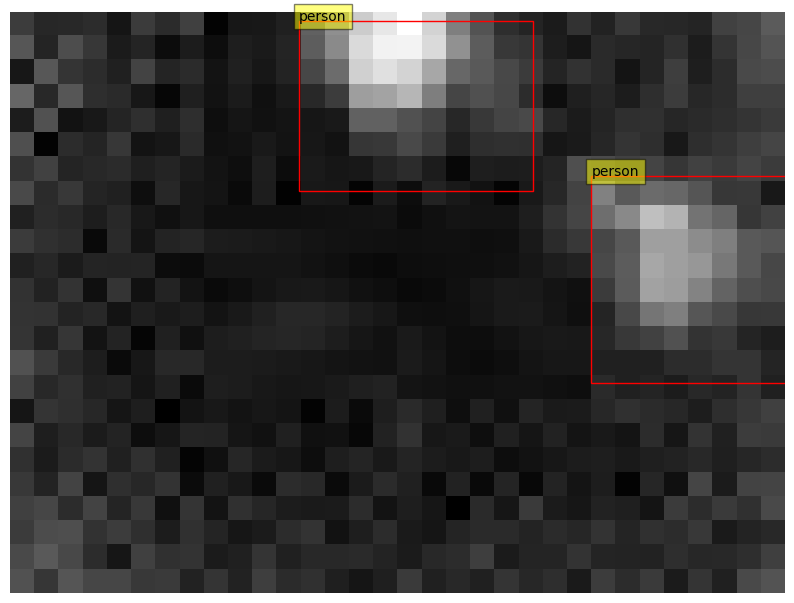

1/1 [==============================] - 0s 37ms/step
[[13.346527    0.04214239 22.283298    7.423079    1.1298046 ]
 [22.842592    6.375216   30.645445   14.26232     0.9573081 ]]


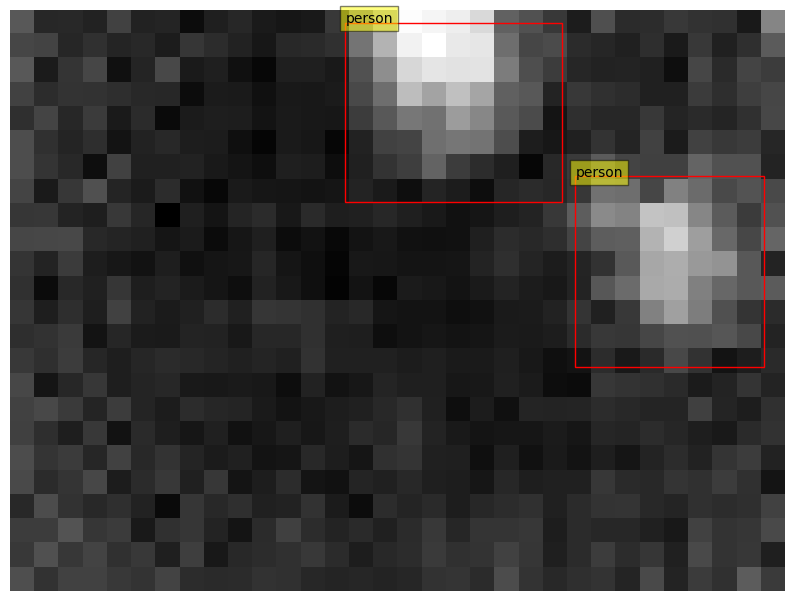

1/1 [==============================] - 0s 36ms/step
[[4.4416285e+00 1.6934526e+01 1.3009107e+01 2.4034548e+01 1.0525687e+00]
 [2.1793751e+01 2.1822929e-02 3.0194561e+01 7.4945593e+00 1.0085931e+00]]


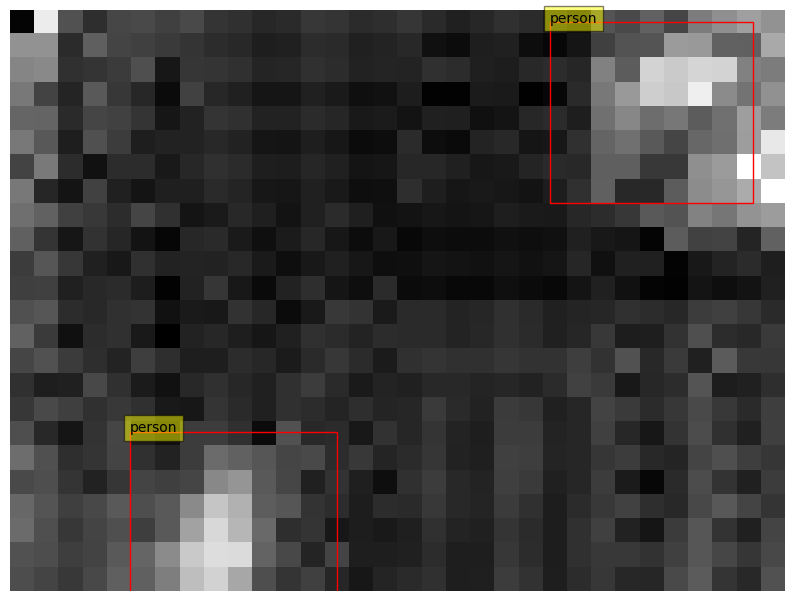

1/1 [==============================] - 0s 36ms/step
[[16.254429   15.555897   23.066143   23.940151    0.93406755]
 [20.947695   12.723427   29.662949   20.399666    0.8276892 ]]


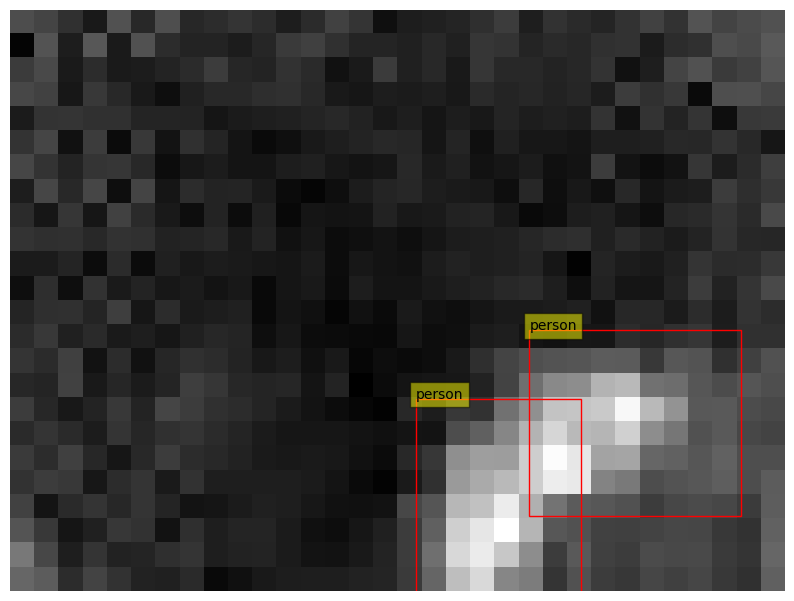

1/1 [==============================] - 0s 31ms/step
[[ 4.2308154  12.748015   14.12789    21.393814    1.3065493 ]
 [23.858208   15.607479   31.996605   23.843159    0.89547205]]


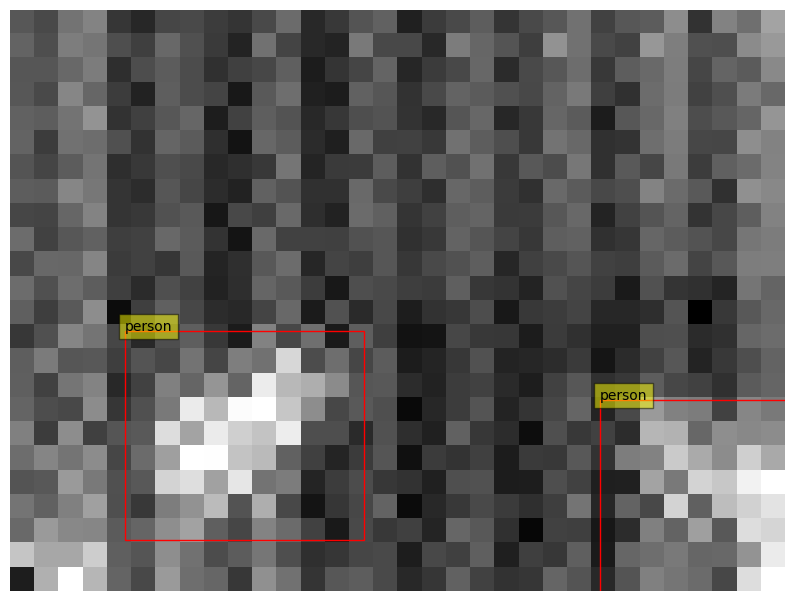

1/1 [==============================] - 0s 31ms/step
[[ 1.2584332e+01  9.3977537e+00  2.2182827e+01  2.2044758e+01
   1.0141940e+00]
 [ 1.1631311e+01 -8.7559223e-03  1.9195938e+01  5.3885117e+00
   6.4268732e-01]]


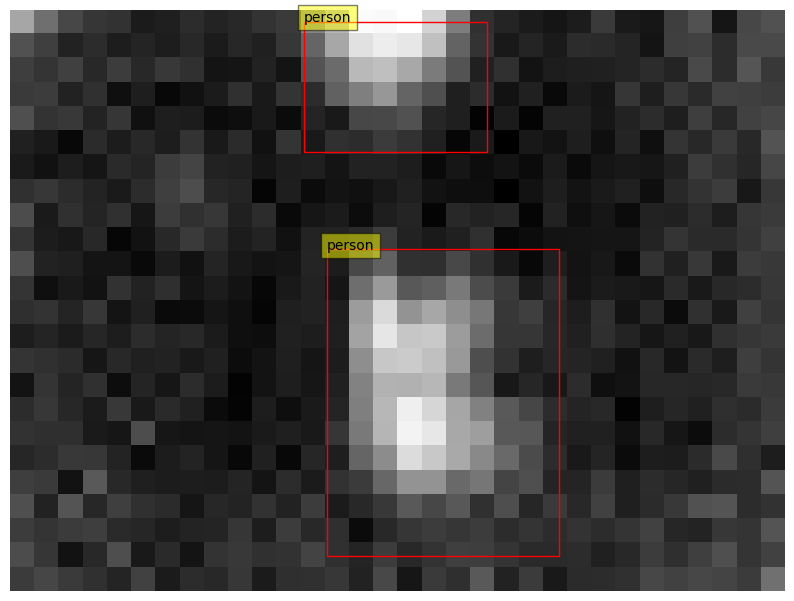

1/1 [==============================] - 0s 37ms/step
[[19.756226   11.276832   29.458815   18.201473    1.360319  ]
 [ 1.8388805  15.264702    9.408527   23.210205    0.94290376]
 [ 9.945221   10.920097   17.772789   20.39573     0.84723675]]


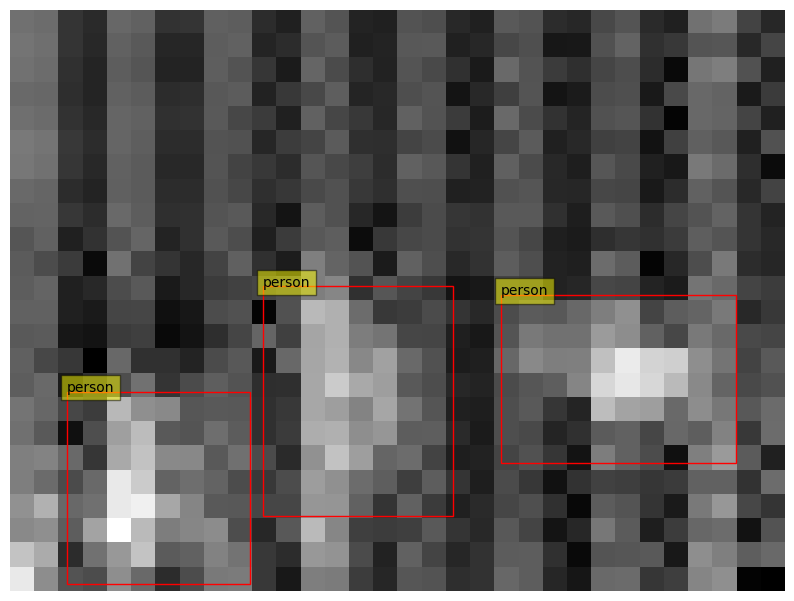

1/1 [==============================] - 0s 37ms/step
[[ 0.19431925  5.4812713  10.275486   13.7199      1.2491214 ]]


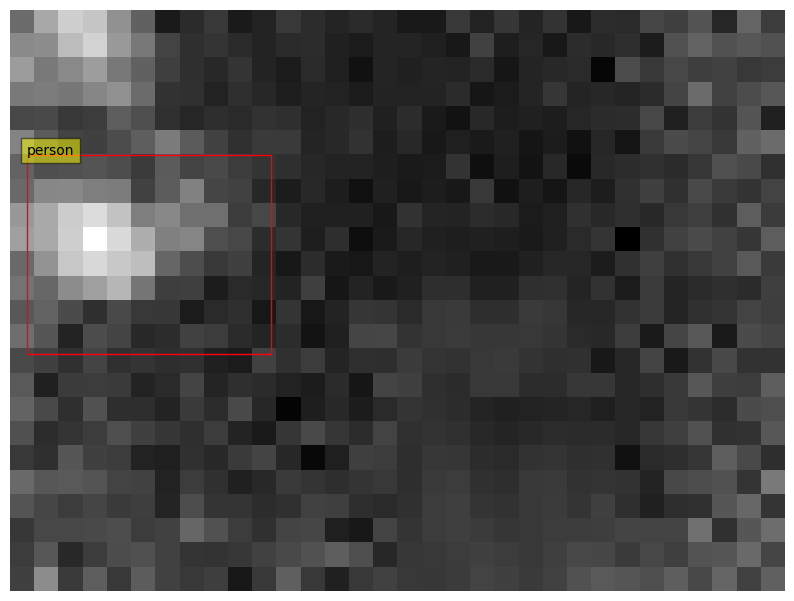

1/1 [==============================] - 0s 36ms/step
[[ 6.053099   11.713992   16.60871    19.882313    0.98362315]
 [24.845236   14.116792   31.971104   21.30846     0.9154372 ]]


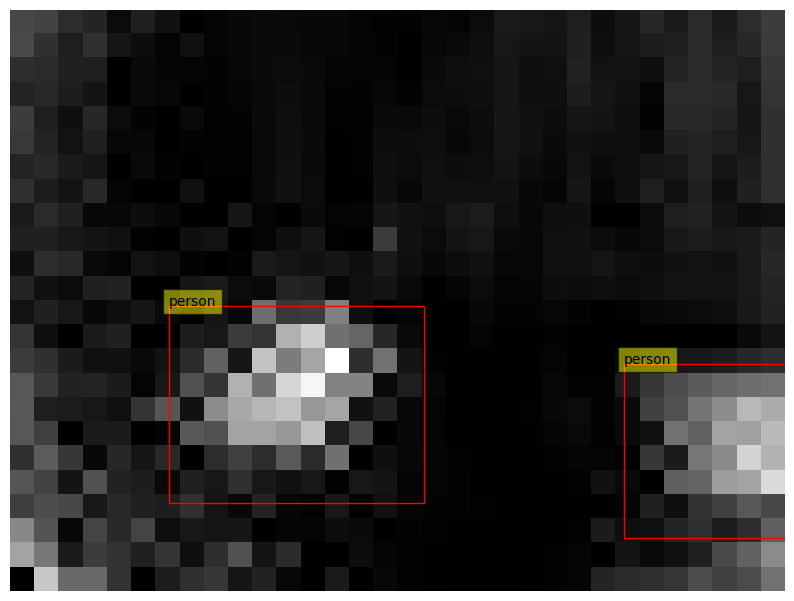

1/1 [==============================] - 0s 36ms/step
[[ 5.307445   14.223507   14.44989    23.083172    1.2256955 ]
 [22.911926   12.006745   32.06128    19.578333    0.94762796]]


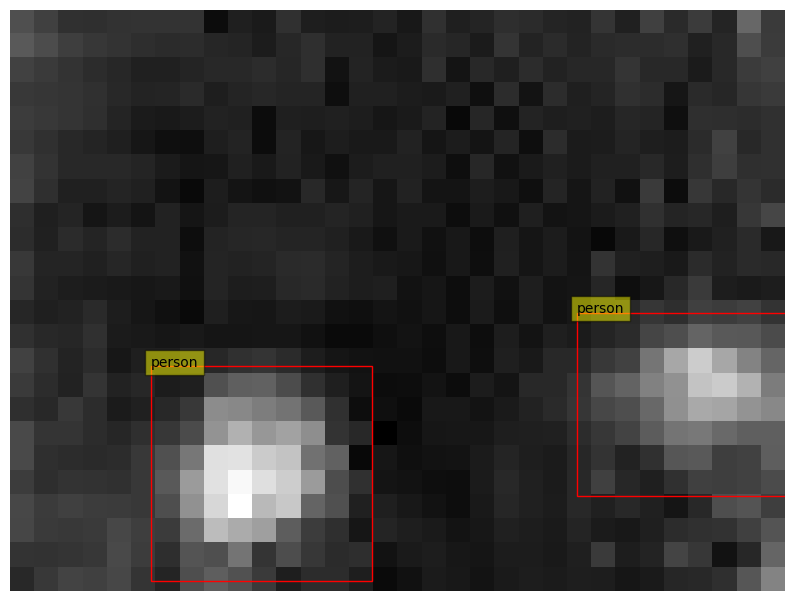

1/1 [==============================] - 0s 37ms/step
[[15.892052   11.9145355  25.824379   22.596718    1.2682315 ]
 [-0.18921661 16.57515     8.405264   24.006586    0.8950269 ]]


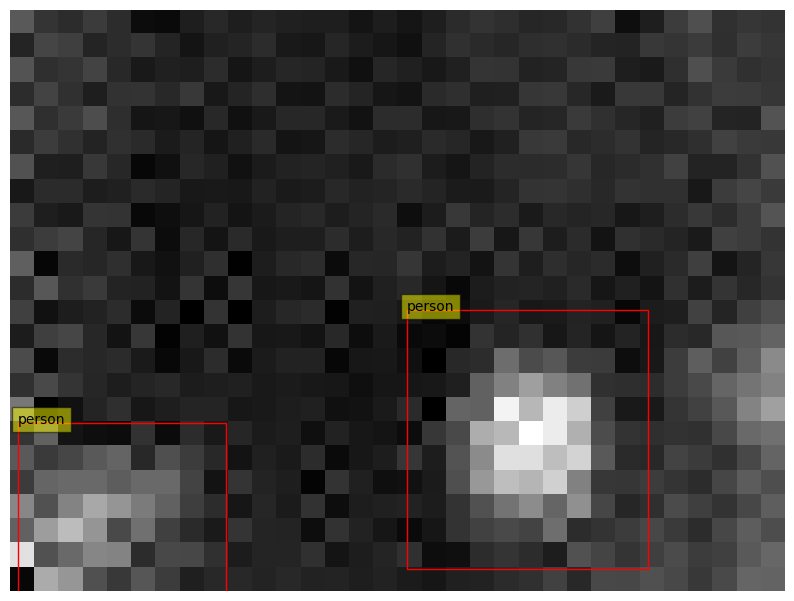

1/1 [==============================] - 0s 37ms/step
[[ 2.0339123e+01  7.2214975e+00  3.2031467e+01  1.5461877e+01
   8.1674784e-01]
 [-3.1875372e-02  4.0786457e+00  7.9924927e+00  1.1099943e+01
   8.0735725e-01]]


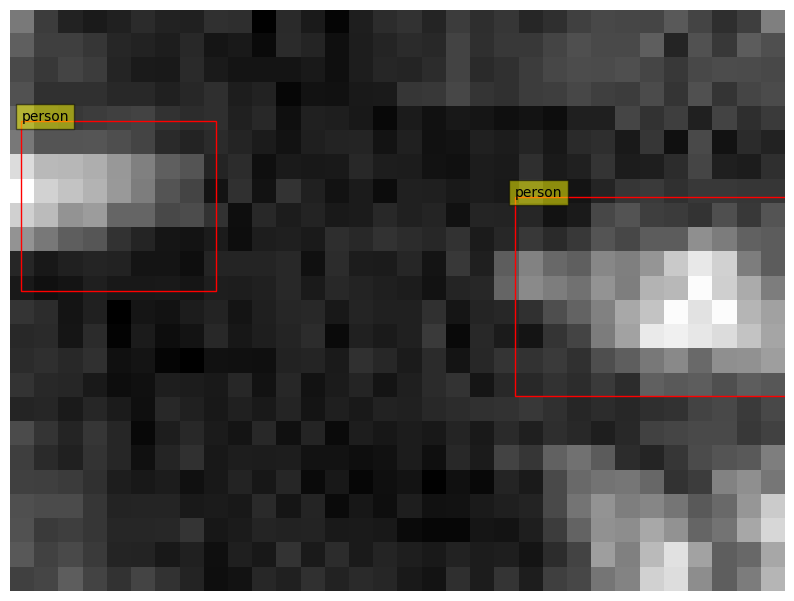

1/1 [==============================] - 0s 37ms/step
[[ 9.843748    2.44346    19.039402   14.430565    1.0626905 ]
 [11.837135   16.545473   18.73093    24.082336    0.71884036]]


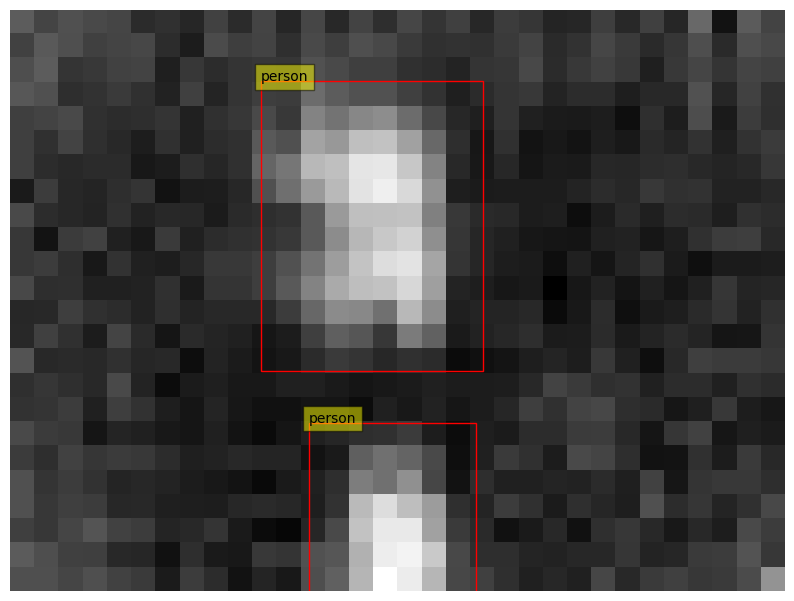

1/1 [==============================] - 0s 36ms/step
[[19.93285     8.03161    28.005297   15.196502    0.84986687]
 [ 0.5030124   6.0549335   8.363181   12.285749    0.78849226]
 [14.998535    0.1233871  21.60833     5.8823442   0.69638854]]


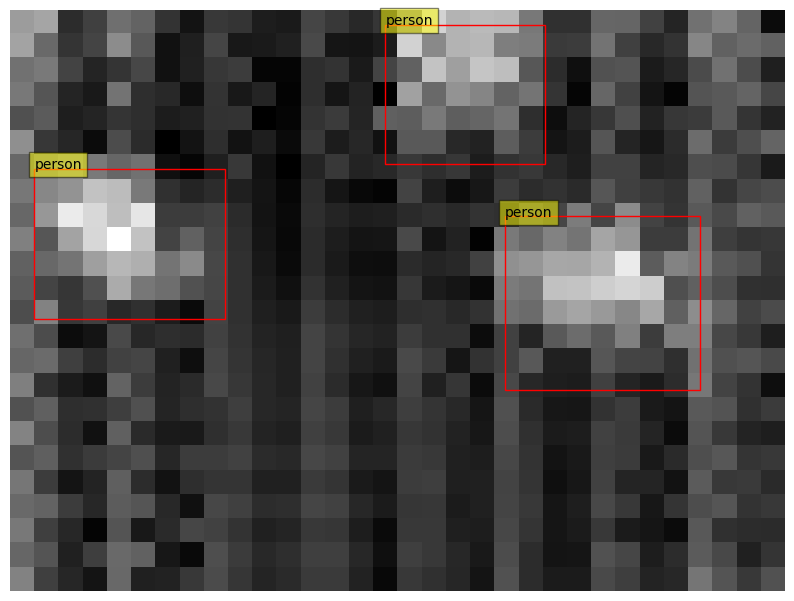

1/1 [==============================] - 0s 36ms/step
[[21.840736  11.099901  31.665064  19.49535    1.2019558]
 [ 0.8856535  2.8854847 10.134473  11.157009   1.1537441]
 [11.312308  17.541904  19.566643  23.886131   0.8383193]]


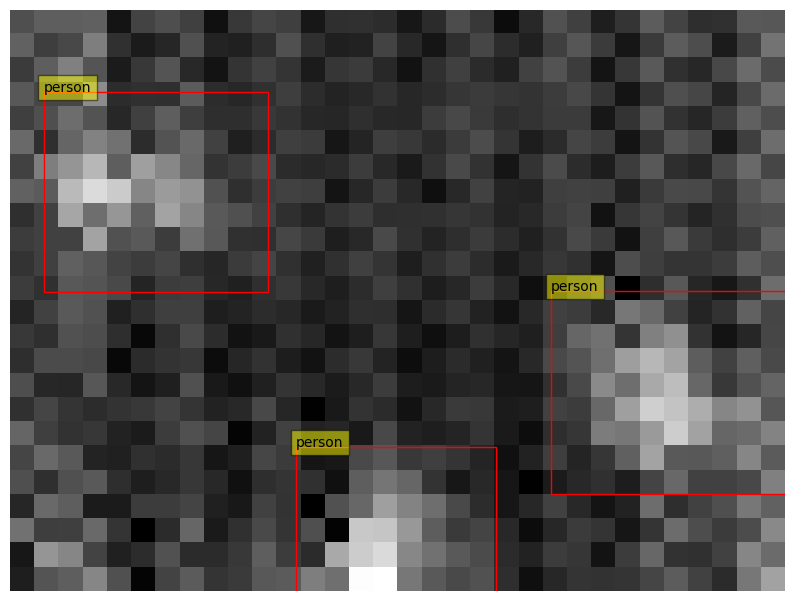

1/1 [==============================] - 0s 29ms/step
[[ 1.00153570e+01  2.13554859e-01  2.06932945e+01  1.00709305e+01
   1.36782610e+00]
 [-1.35726929e-02  6.50724220e+00  7.46148300e+00  1.33961811e+01
   7.57762492e-01]]


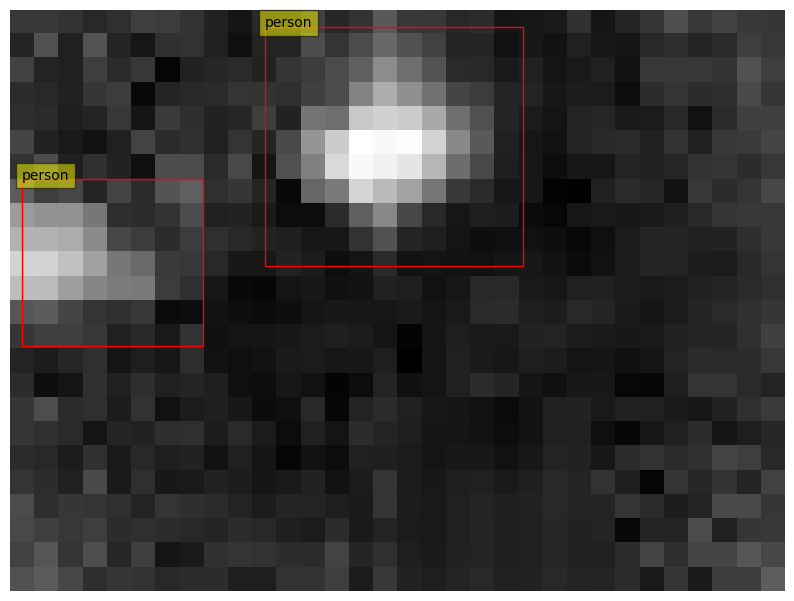

1/1 [==============================] - 0s 35ms/step
[[ 6.087952    7.288268   17.688211   17.386951    1.152916  ]
 [22.799417   10.339876   31.111582   18.573345    0.9308286 ]
 [ 2.2598767   0.0501132   9.545078    7.5663      0.6503785 ]
 [-0.11752152 13.729557    5.4418325  22.55296     0.5932184 ]]


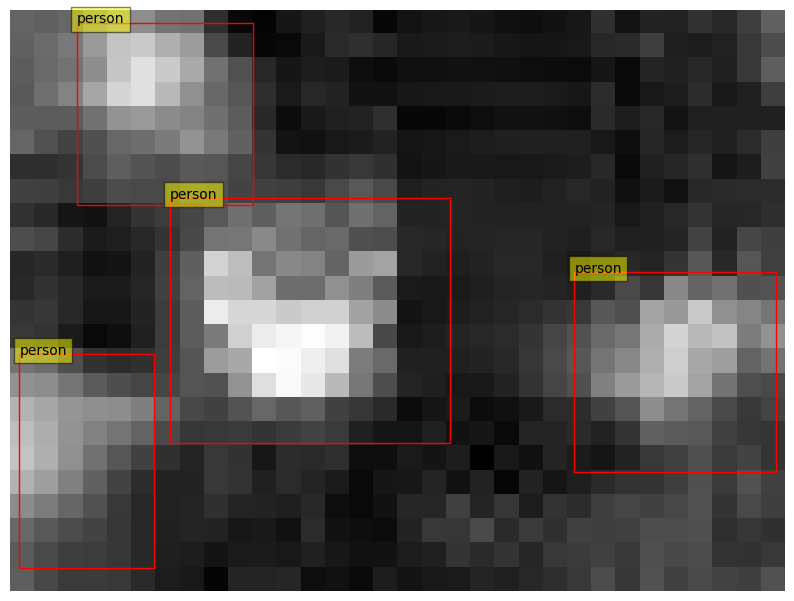

1/1 [==============================] - 0s 36ms/step
[[12.526646    0.04473329 20.407734    7.7067804   1.0865129 ]
 [-0.06954408 16.887358    6.8971815  24.180254    0.84743917]]


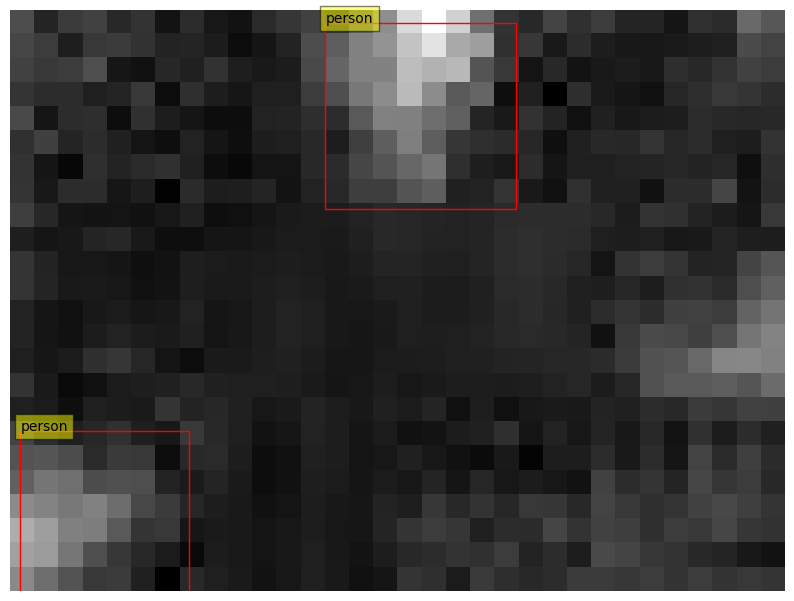

1/1 [==============================] - 0s 36ms/step
[[ 7.269999    7.3652134  18.157545   16.918013    0.92839587]]


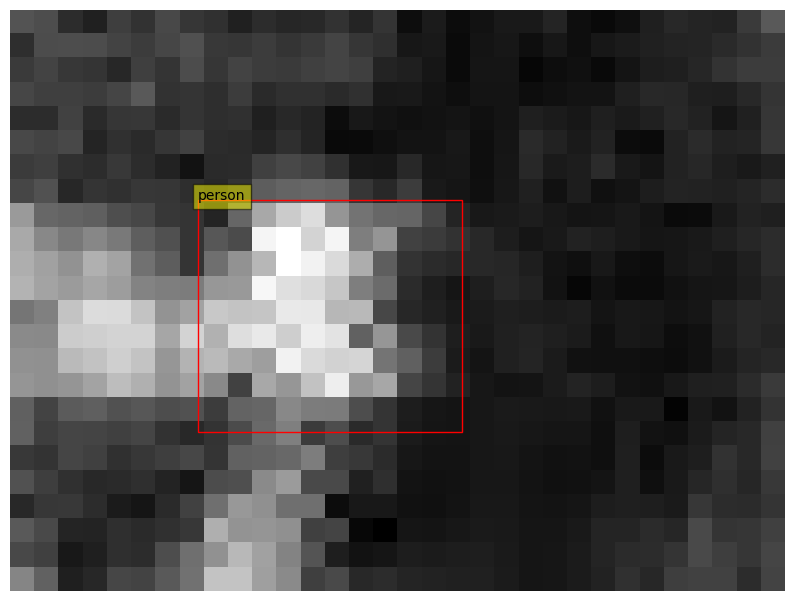

1/1 [==============================] - 0s 36ms/step
[[-0.0617013 11.600939  10.357664  19.048859   0.8840777]]


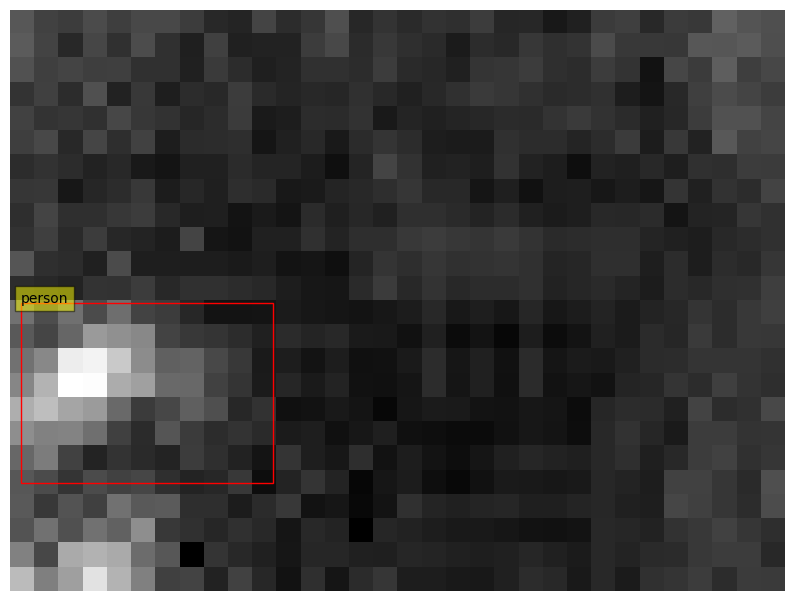

1/1 [==============================] - 0s 35ms/step
[[13.670971    6.434143   22.309544   16.626554    1.1150982 ]
 [24.117582   12.966874   31.957115   21.034912    1.0083272 ]
 [ 0.08812952 11.68667     8.506994   19.24097     0.9283782 ]
 [22.690876   -0.20969391 31.224388    8.268627    0.92370456]]


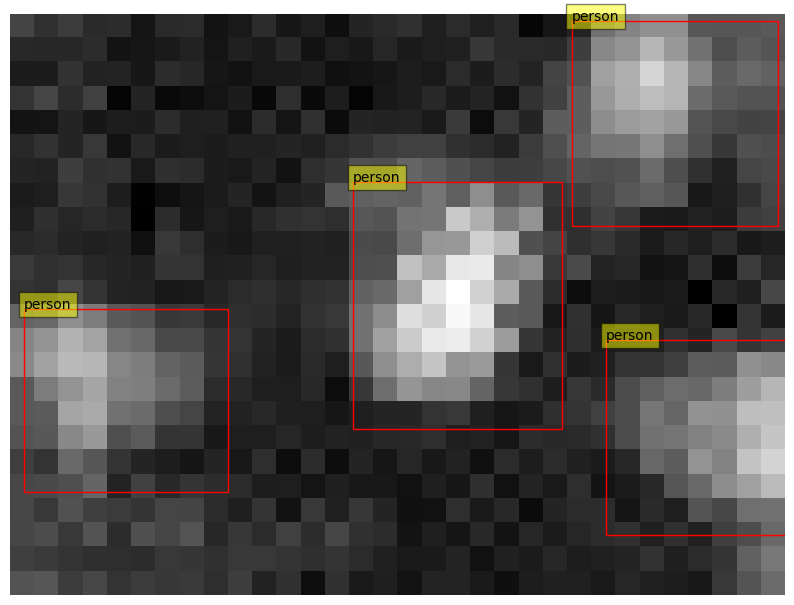

1/1 [==============================] - 0s 36ms/step
[[24.457798  12.510637  31.984703  20.17527    0.8631499]
 [12.835841  17.838205  20.571127  23.97803    0.8557292]
 [ 0.2084074  6.969264   8.67446   12.894237   0.6799983]]


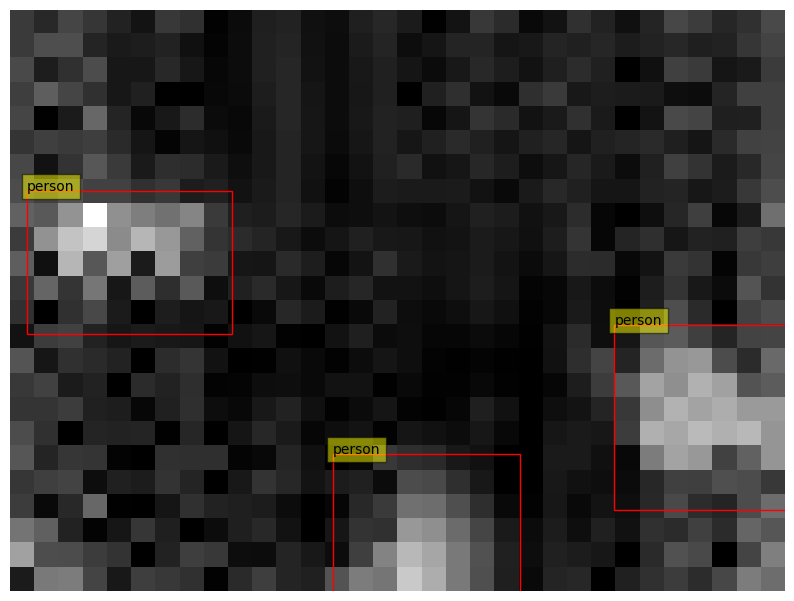

1/1 [==============================] - 0s 42ms/step
[[21.883446   5.118504  31.01797   13.212564   1.0802494]]


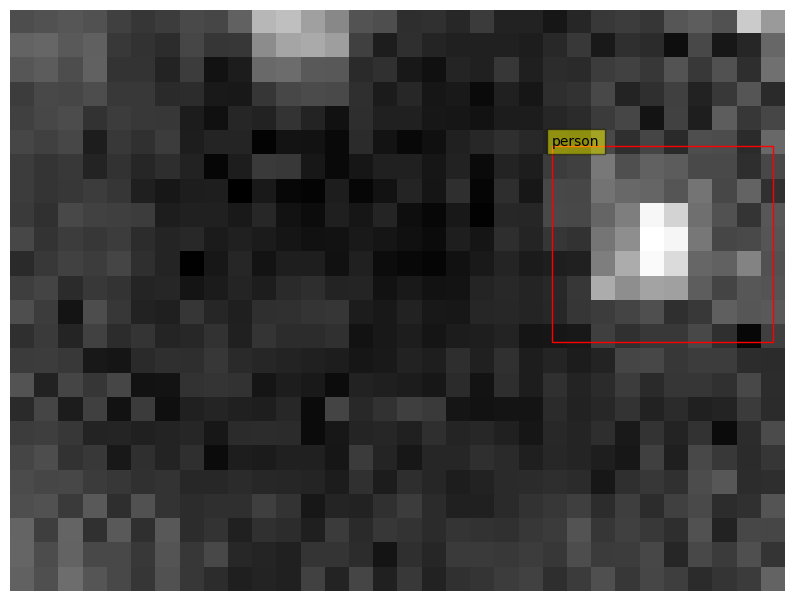

1/1 [==============================] - 0s 36ms/step
[[ 9.828278   2.8757033 17.99765   11.242353   1.0610793]
 [23.097645  14.213929  30.748966  21.33274    1.0540873]]


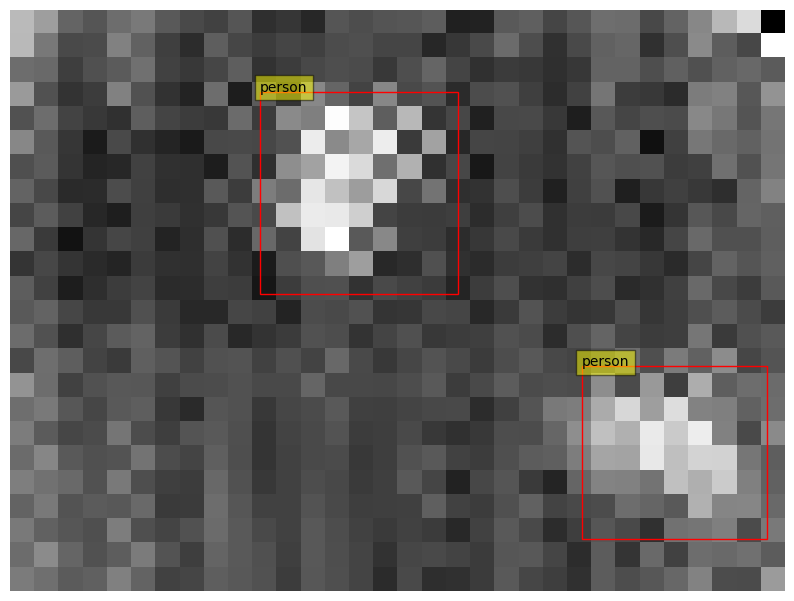

1/1 [==============================] - 0s 36ms/step
[[23.426733    4.6701055  31.985147   14.426846    0.999263  ]
 [25.276318    0.10974646 31.834648    5.78898     0.5494767 ]]


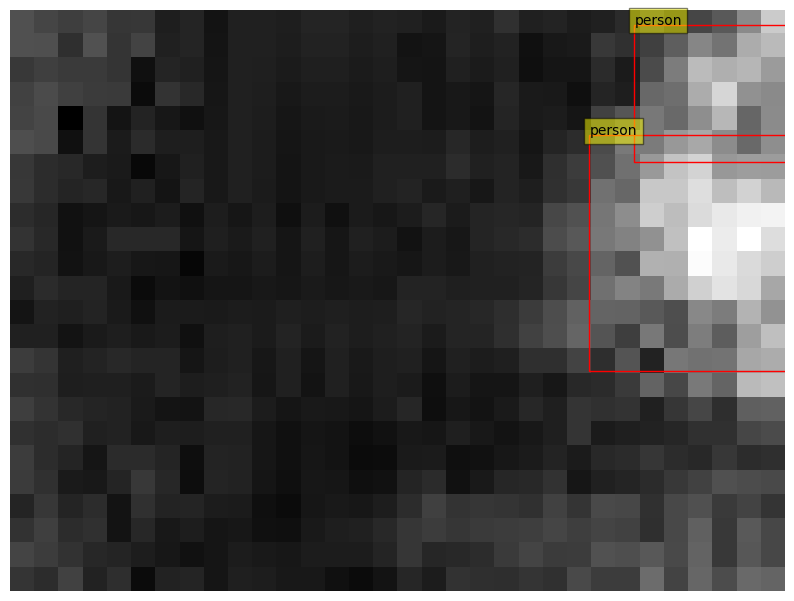

1/1 [==============================] - 0s 36ms/step
[[ 2.419098  13.220255  12.073785  22.994408   0.9334662]
 [23.984308   9.449294  31.952747  17.531334   0.8623798]
 [12.875919  14.851885  20.054512  23.99237    0.6614235]
 [26.008463  18.392786  31.828611  23.853664   0.5622437]]


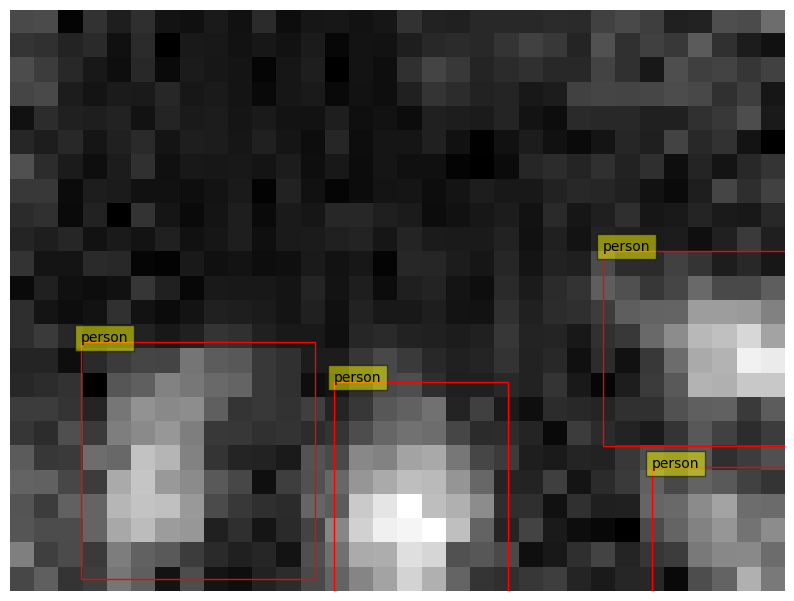

1/1 [==============================] - 0s 35ms/step
[[-1.0061741e-02  7.7021480e+00  7.1809206e+00  1.4793392e+01
   9.4959682e-01]
 [-1.4669418e-02 -4.3712854e-02  6.3681517e+00  6.3788738e+00
   7.7827656e-01]]


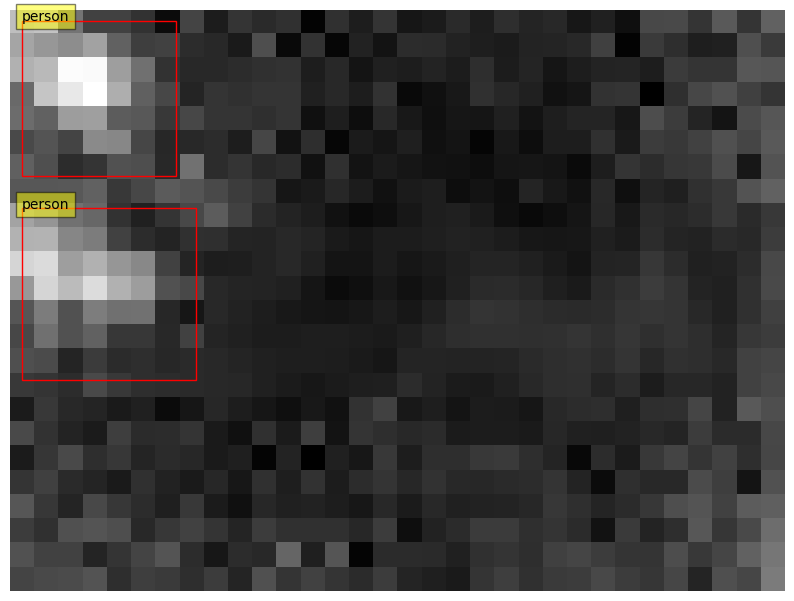

1/1 [==============================] - 0s 35ms/step
[[15.58062    1.7920027 25.877876  10.939925   1.1808516]
 [ 7.718729   4.812519  17.26417   12.825409   1.0034492]]


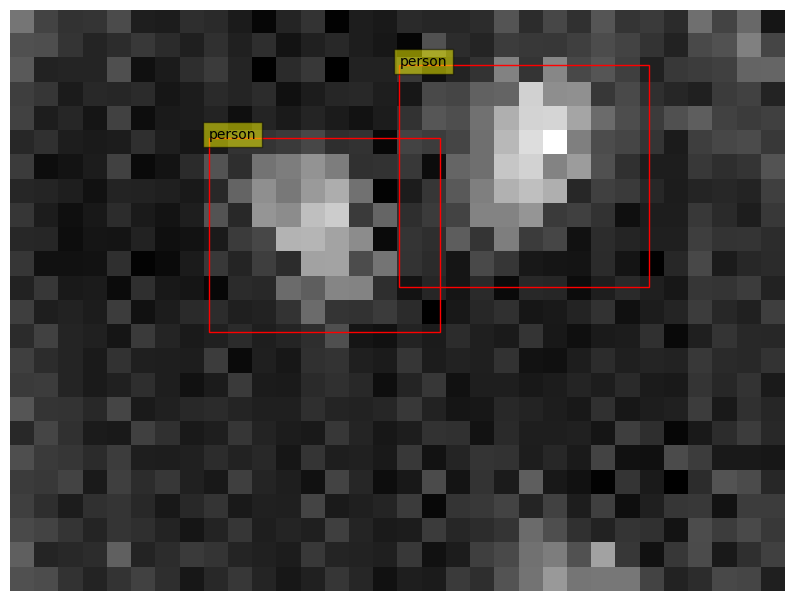

1/1 [==============================] - 0s 35ms/step
[[ 8.029396    6.037576   18.317972   14.896477    1.4152867 ]
 [17.686243   10.211542   28.899555   18.70411     0.99303097]
 [13.419252    9.969839   24.543066   17.98518     0.606822  ]
 [16.493414    0.09476447 24.2727      5.566594    0.5374021 ]]


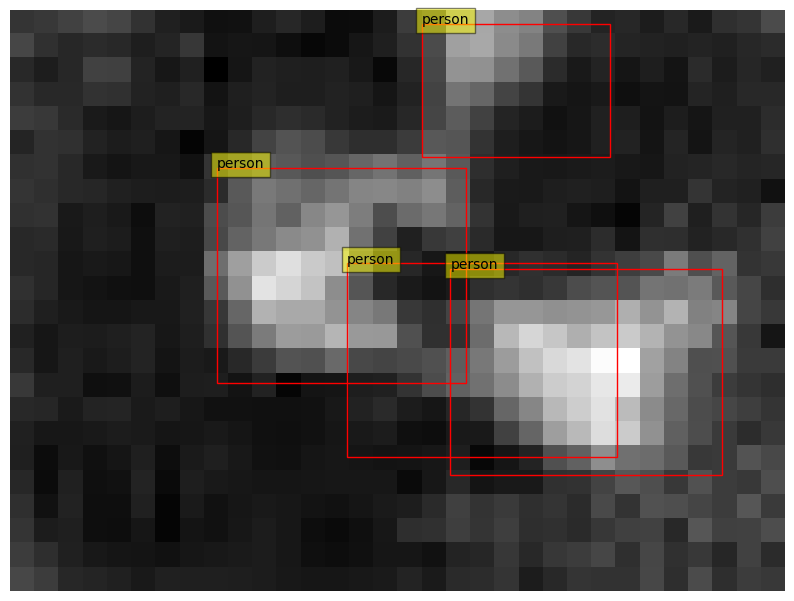

1/1 [==============================] - 0s 28ms/step
[[24.177559   10.825743   31.979822   19.639757    0.94825226]
 [-0.16350555  4.9996176   8.8294115  12.604132    0.8917012 ]]


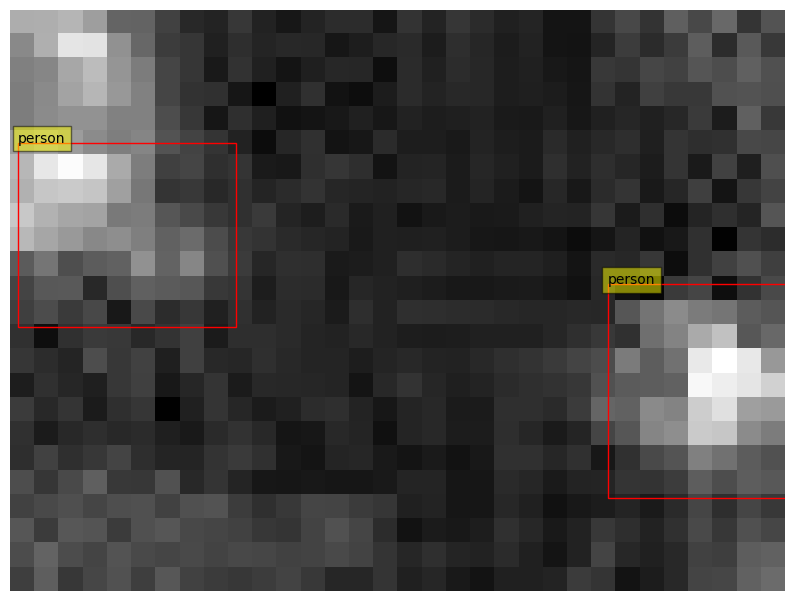

1/1 [==============================] - 0s 36ms/step
[[25.171768    0.88219976 31.926659    9.853954    0.864107  ]]


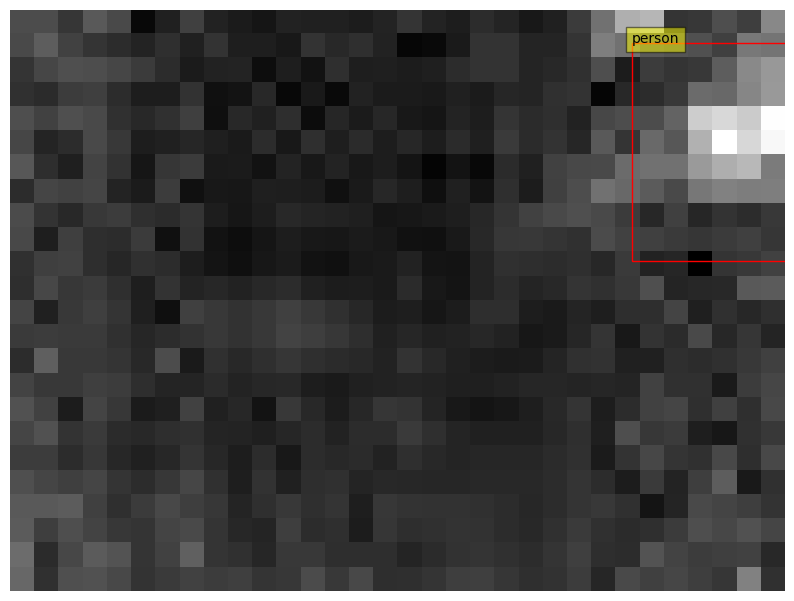

1/1 [==============================] - 0s 29ms/step
[[24.561274 11.084551 31.8245   17.937391  0.955313]]


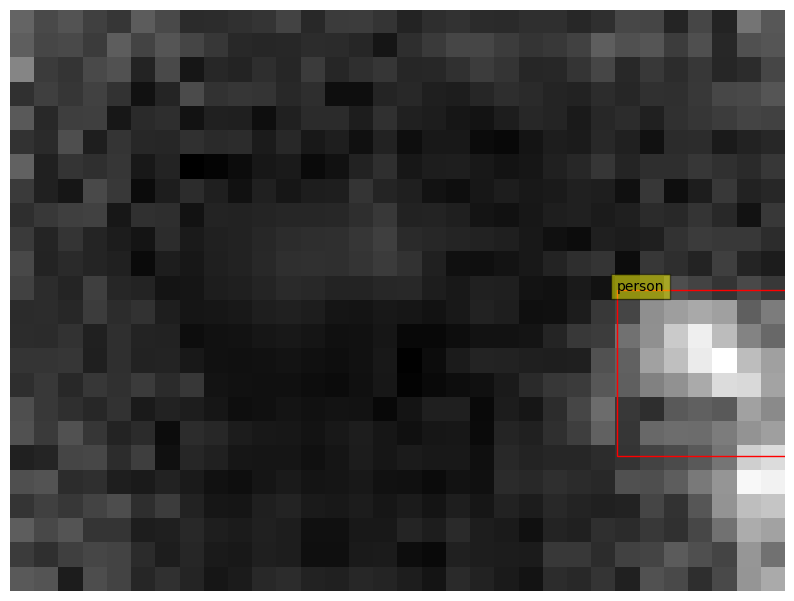

1/1 [==============================] - 0s 35ms/step
[[ 1.6466999  1.350379   9.51117    9.729776   1.2541654]
 [19.002346  18.569033  26.976885  24.00843    0.7681664]]


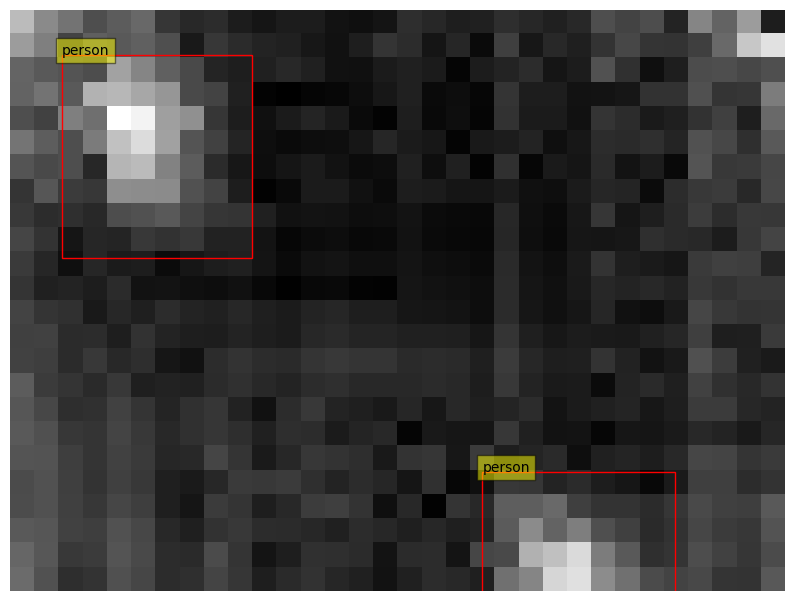

1/1 [==============================] - 0s 36ms/step
[[ 6.9300017 10.967777  14.243568  18.305855   0.9393876]]


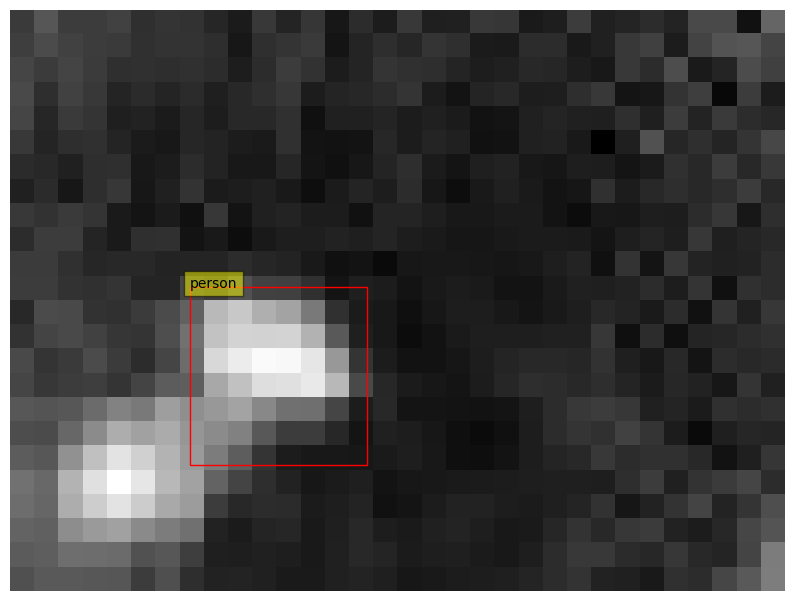

1/1 [==============================] - 0s 38ms/step
[[22.928314    6.960895   31.981365   15.763023    1.1704712 ]
 [25.910213   -0.0585885  32.013844    7.020555    0.56224483]]


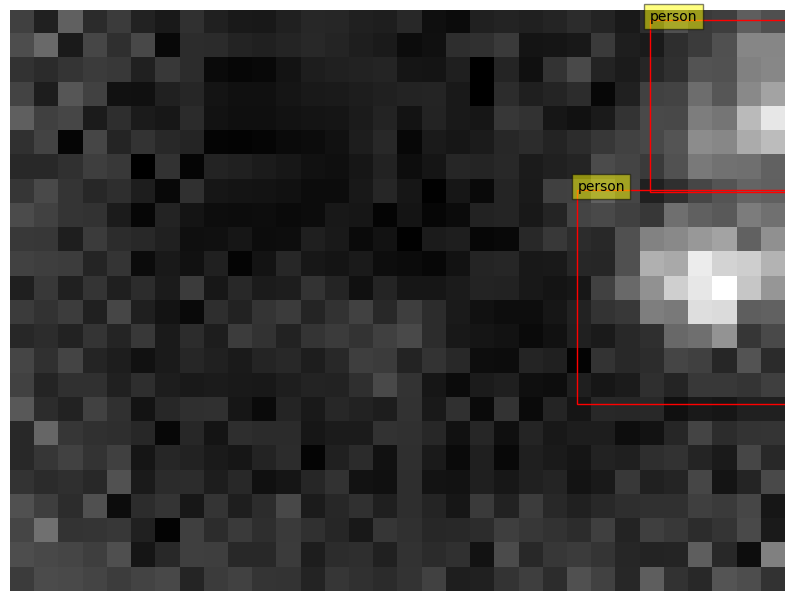

1/1 [==============================] - 0s 37ms/step
[[18.072458  15.982396  26.691847  24.147831   0.8618306]
 [24.683828   9.242172  31.960434  17.048233   0.8275624]
 [25.977343  16.721113  31.956478  24.278328   0.5904358]]


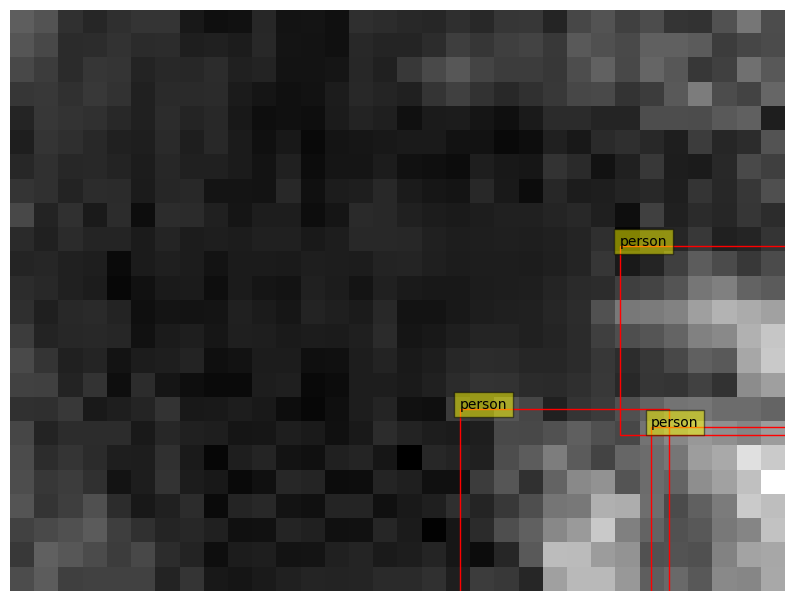

1/1 [==============================] - 0s 35ms/step
[[-0.09150934 11.4808655   9.394344   18.916025    0.9090902 ]]


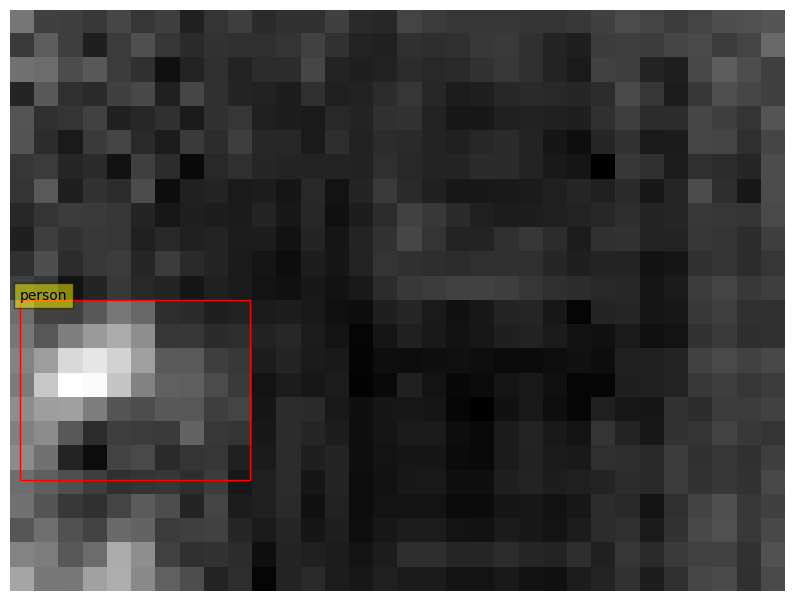

1/1 [==============================] - 0s 35ms/step
[[ 4.335089    5.4684877  14.349333   13.851562    1.2126198 ]
 [22.224806   10.364836   32.038273   16.71426     0.94069386]]


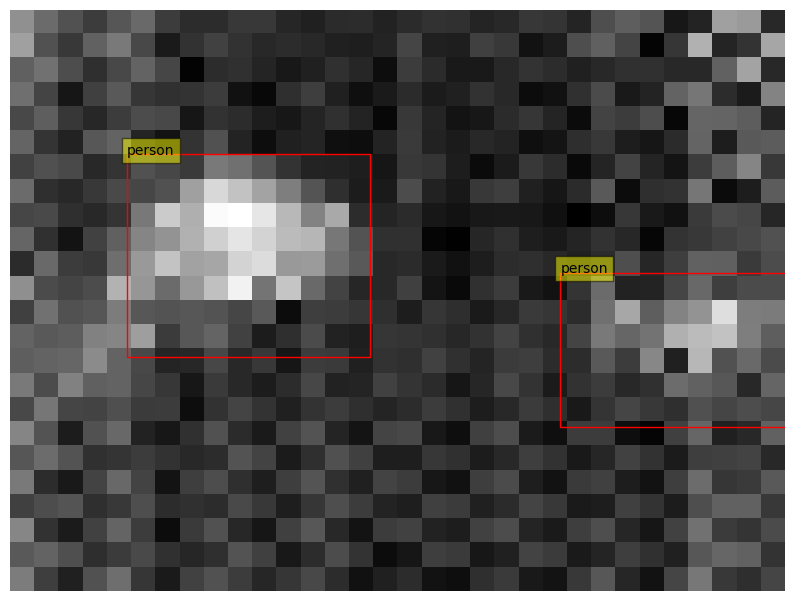

1/1 [==============================] - 0s 35ms/step
[[16.322224   3.3861866 26.232908  12.051889   1.144838 ]
 [ 9.548785   4.3523064 19.253464  14.219061   1.0277045]]


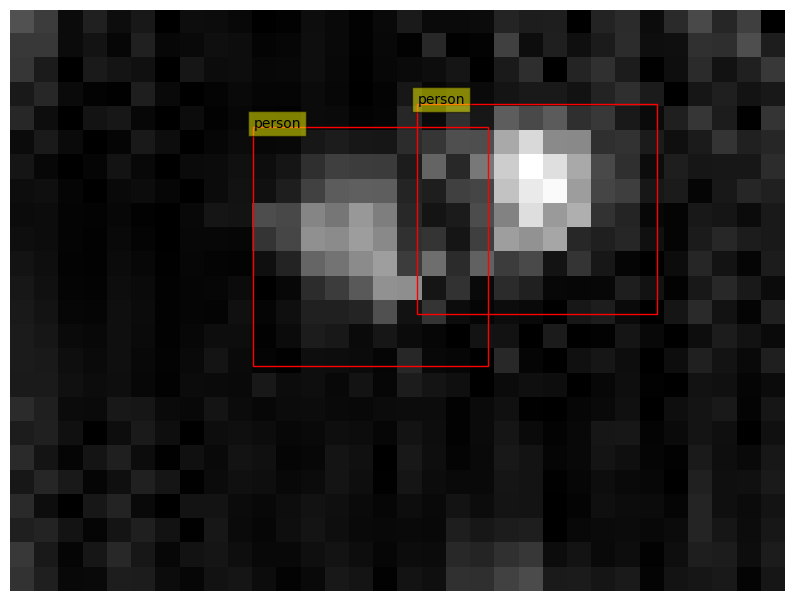

1/1 [==============================] - 0s 37ms/step
[[10.211558    9.44792    18.704273   21.460629    1.0757164 ]
 [13.29911     0.14667058 21.051868    4.6580715   0.5359553 ]]


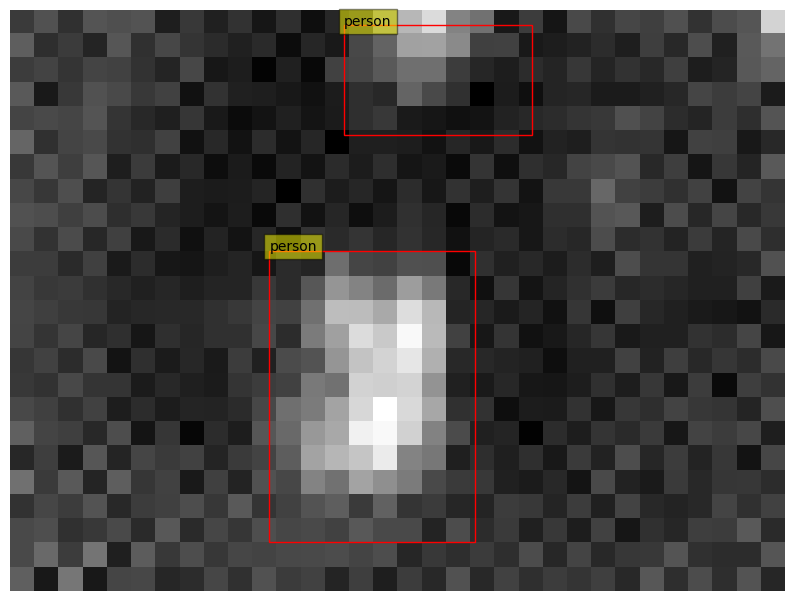

1/1 [==============================] - 0s 35ms/step
[[21.21331    14.161944   29.388775   23.16957     1.0861593 ]
 [ 2.1853337   8.261817   11.861221   15.52732     0.99621975]]


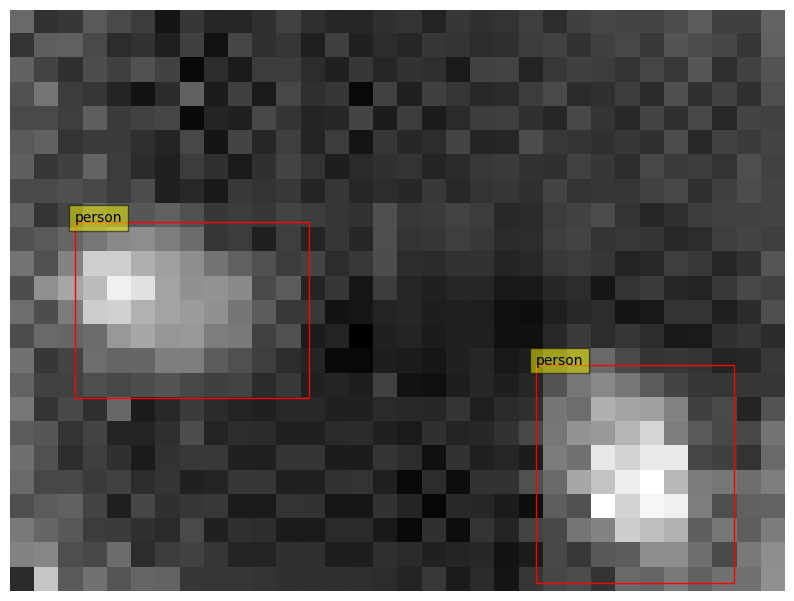

1/1 [==============================] - 0s 35ms/step
[[12.983359   9.240812  21.601856  20.85748    1.1530473]
 [19.932772   2.233673  26.816113   9.3712015  0.8155491]]


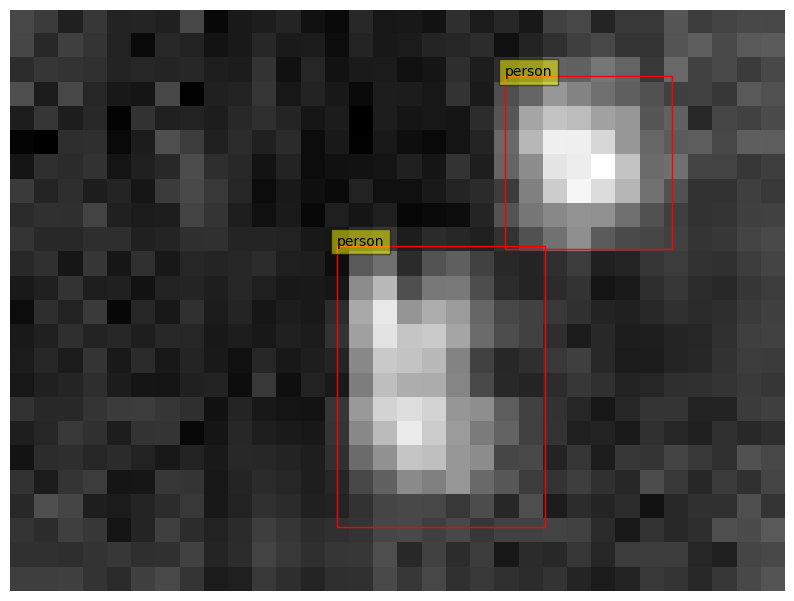

1/1 [==============================] - 0s 37ms/step
[[13.059333   10.201513   23.192017   21.25555     0.9859736 ]
 [ 0.10946512 15.615313   10.221748   23.255882    0.9757346 ]
 [-0.26839304  8.964708   10.019686   15.989912    0.8075066 ]]


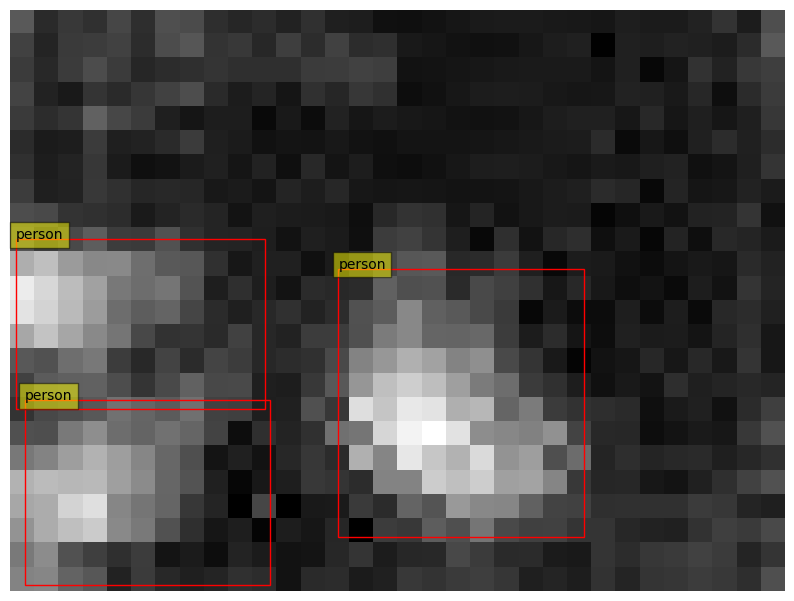

1/1 [==============================] - 0s 36ms/step
[[ 2.1996777e+01  2.1284752e+00  3.0797968e+01  1.0840493e+01
   1.2278801e+00]
 [ 1.4222076e+01  4.6590176e+00  2.2643322e+01  1.2625771e+01
   1.1603040e+00]
 [ 7.9210396e+00 -1.8735409e-02  1.5083588e+01  6.1638527e+00
   6.9990247e-01]]


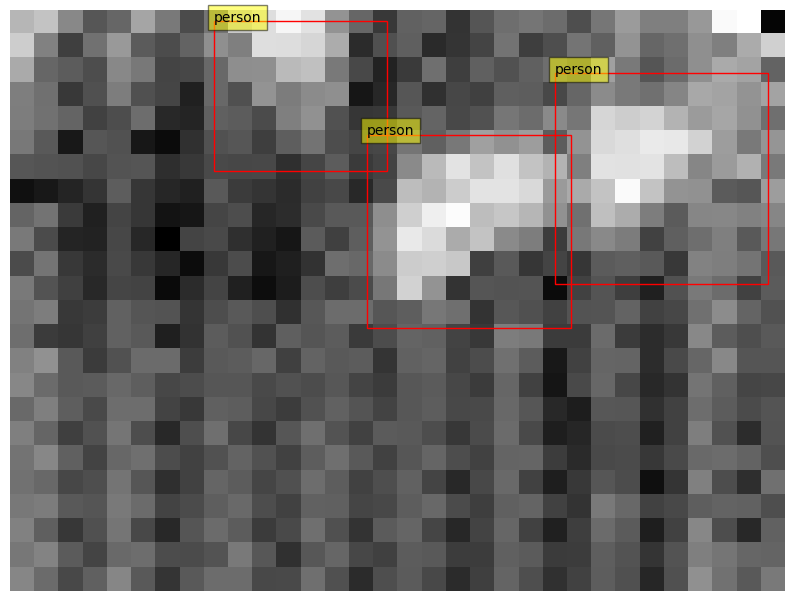

1/1 [==============================] - 0s 36ms/step
[[1.1672848e+01 1.7224073e-02 2.1802486e+01 7.2996016e+00 1.0126224e+00]
 [2.3488258e+01 5.5927739e+00 3.1260822e+01 1.4358143e+01 9.7931719e-01]]


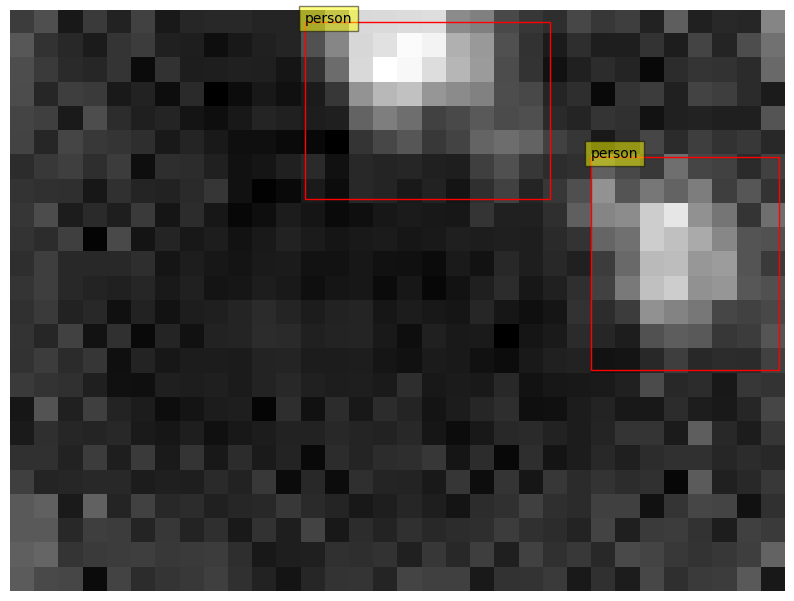

1/1 [==============================] - 0s 36ms/step
[[11.526321   13.226336   21.59372    21.007845    1.2367252 ]
 [19.08232    19.193947   24.60146    24.226694    0.57763445]]


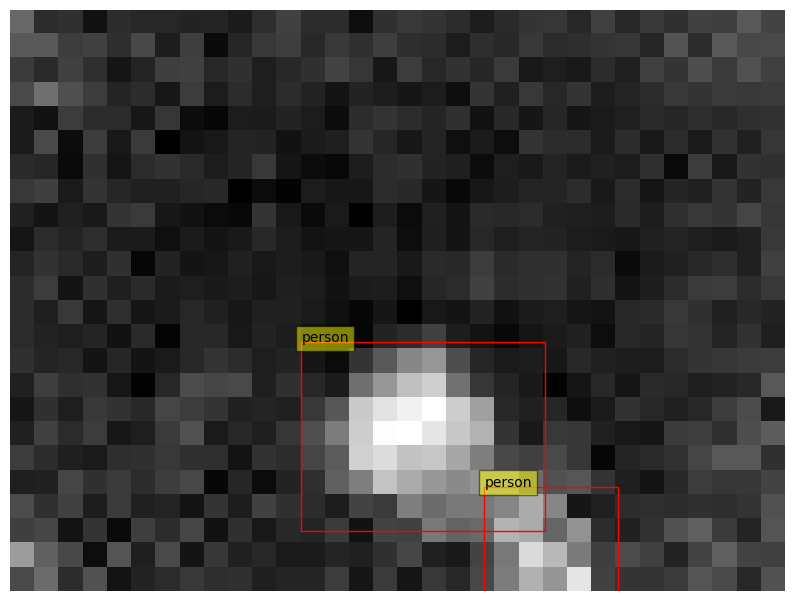

1/1 [==============================] - 0s 37ms/step
[[-0.16488266  9.005501    7.753249   16.588573    1.0167996 ]
 [13.960716    4.5461793  22.168125   16.338219    0.9580306 ]
 [ 9.250256   16.64492    16.261555   24.0623      0.7900271 ]]


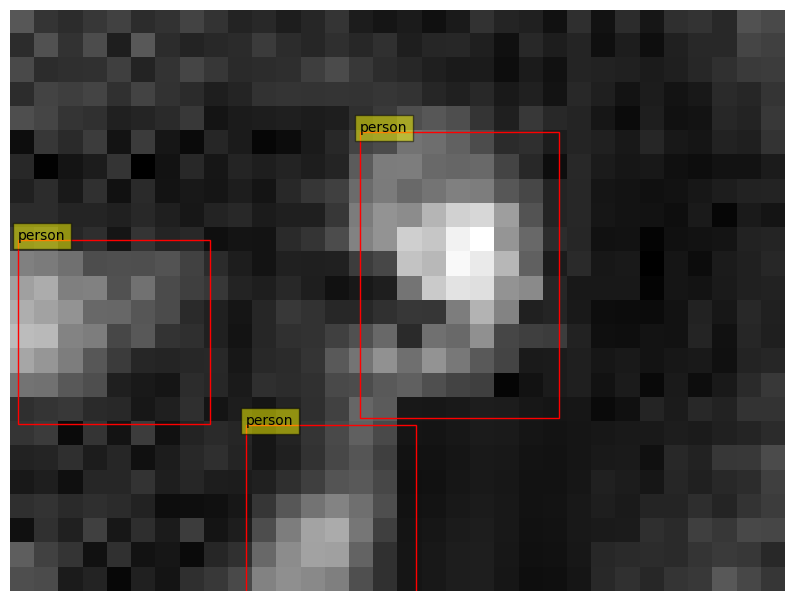

1/1 [==============================] - 0s 35ms/step
[[-0.0316813   0.33906364  7.118223    8.675282    0.9224584 ]
 [ 5.5052443   0.13613677 13.439888    7.488906    0.81443584]]


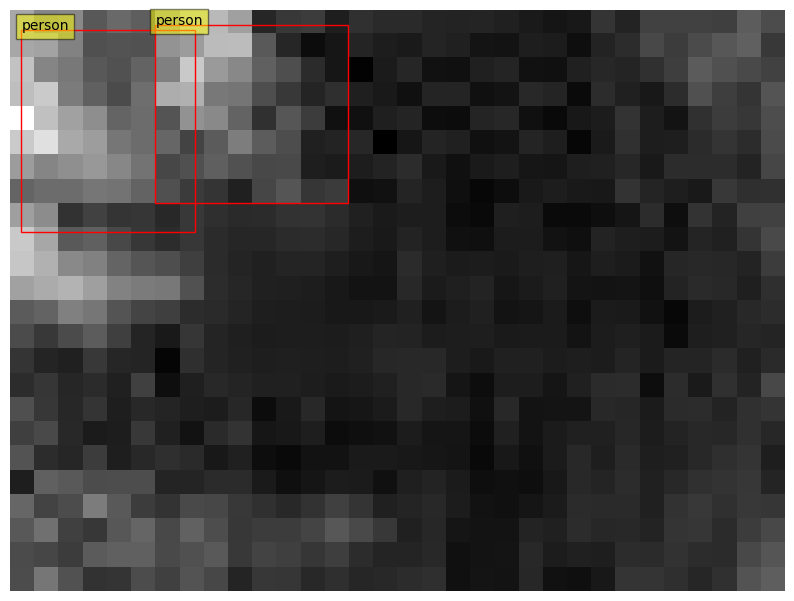

1/1 [==============================] - 0s 36ms/step
[[-0.07197976  7.4589114   7.3042173  16.266853    0.98334664]
 [-0.07153964 -0.10508871  7.1137247   5.4050846   0.53586864]]


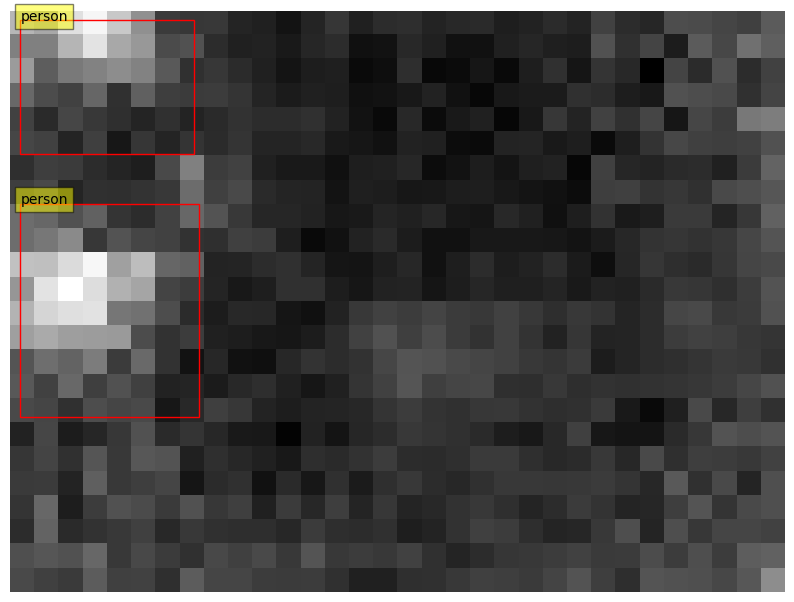

1/1 [==============================] - 0s 36ms/step
[[ 5.8687057   6.4230404  12.18647    15.766739    0.9705424 ]
 [11.192751    2.2806053  20.15102    15.627989    0.88143605]]


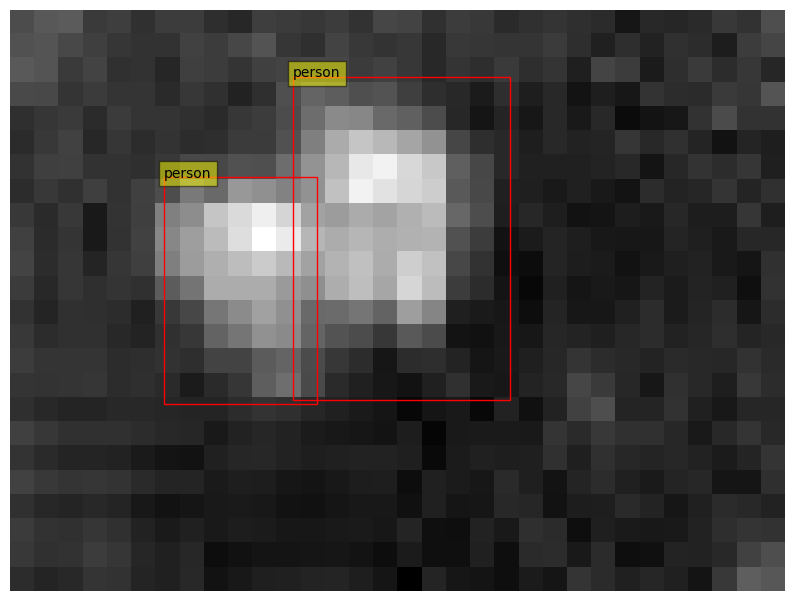

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf

def iou(box1, box2):
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2

    x_overlap = max(0, min(x2, x4) - max(x1, x3))
    y_overlap = max(0, min(y2, y4) - max(y1, y3))

    intersection = x_overlap * y_overlap
    area1 = (x2 - x1) * (y2 - y1)
    area2 = (x4 - x3) * (y4 - y3)
    union = area1 + area2 - intersection

    return intersection / union

def decode_predictions(predictions, anchors, box_variance=[0.1, 0.1, 0.2, 0.2], iou_threshold=0.5, score_threshold=0.5, top_n=100):
    decoded_boxes = []
    scores = []
    for i, prediction in enumerate(predictions):
        score = prediction[-1]
        if score > score_threshold:
            scores.append((score, i))

    # 점수에 따라 내림차순 정렬
    scores.sort(reverse=True)

    # 상위 N개 선택
    scores = scores[:top_n]

    # NMS 적용
    while scores:
        score, i = scores.pop(0)
        prediction = predictions[i]
        dx, dy, dw, dh = prediction[:4]
        anchor = anchors[i]
        anchor_x, anchor_y, anchor_w, anchor_h = anchor
        cx = dx * box_variance[0] * anchor_w + anchor_x
        cy = dy * box_variance[1] * anchor_h + anchor_y
        width = np.exp(dw * box_variance[2]) * anchor_w
        height = np.exp(dh * box_variance[3]) * anchor_h
        x_min = cx - width / 2
        y_min = cy - height / 2
        decoded_box = [x_min, y_min, x_min + width, y_min + height, score]
        keep = True
        for other_box in decoded_boxes:
            if iou(decoded_box[:4], other_box[:4]) >= iou_threshold:
                keep = False
                break
        if keep:
            decoded_boxes.append(decoded_box)

    return decoded_boxes

def draw_bounding_boxes(image, boxes, class_names):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')  # 이미지가 grayscale인 경우 cmap='gray'를 추가합니다.
    ax = plt.gca()
    for box in boxes:
        x_min, y_min, x_max, y_max, score = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # 박스 위에 클래스 이름과 확률 표시
        class_name = class_names[0]  # 예시로 'person' 클래스를 사용합니다.
        # text = f'{class_name}: {score / 4:.2f}'
        text = f'{class_name}'
        ax.text(x_min, y_min, text, fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

# AnchorBox 클래스와 get_anchors 함수가 필요합니다.
anchor_box = AnchorBox()
anchors = anchor_box.get_anchors(24, 32)  # 앵커 박스 생성 예시

class_names = ['person']  # 클래스 이름 리스트

for img, _, _ in val_dataset.take(50):    
    predictions = model.predict(tf.expand_dims(img[0], axis=0))[0]  # 첫 번째 이미지에 대한 예측 결과
    decoded_boxes = decode_predictions(predictions, anchors)  # 예측된 바운딩 박스 디코딩
    print(np.array(decoded_boxes))
    draw_bounding_boxes(img[0].numpy(), decoded_boxes, class_names)  # 디코딩된 바운딩 박스를 이미지에 그리기


In [ ]:
anchor_box = AnchorBox()
anchors = anchor_box.get_anchors(24, 32)

In [ ]:
class DecodePredictions(tf.keras.layers.Layer):
    def __init__(self, confidence_threshold=0.9, iou_threshold=0.5, top_k=100, num_classes=1, **kwargs):
        super().__init__(**kwargs)
        self.confidence_threshold = confidence_threshold
        self.iou_threshold = iou_threshold
        self.top_k = top_k
        self.num_classes = num_classes

    def call(self, inputs):
        predictions = inputs

        # 앵커 박스 생성
        anchor_box = AnchorBox()
        anchors = anchor_box.get_anchors(24, 32)

        # 스코어 필터링
        scores = predictions[..., -1]
        score_mask = scores > self.confidence_threshold
        filtered_predictions = tf.boolean_mask(predictions, score_mask)
        filtered_anchors = tf.boolean_mask(anchors, tf.reshape(score_mask, [-1]))

        # NMS 적용
        boxes = self.decode_boxes(filtered_predictions, filtered_anchors)
        nms_indices = tf.image.non_max_suppression(boxes, tf.boolean_mask(scores, score_mask), max_output_size=self.top_k, iou_threshold=self.iou_threshold)
        decoded_boxes = tf.gather(boxes, nms_indices)
        decoded_scores = tf.gather(tf.boolean_mask(scores, score_mask), nms_indices)

        # 바운딩 박스와 스코어 합치기
        decoded_predictions = tf.concat([decoded_boxes, tf.expand_dims(decoded_scores, axis=-1)], axis=-1)

        return decoded_predictions

    def decode_boxes(self, predictions, anchors):
        box_variance = [0.1, 0.1, 0.2, 0.2]
        dx = predictions[..., 0]
        dy = predictions[..., 1]
        dw = predictions[..., 2]
        dh = predictions[..., 3]
        anchor_x = anchors[..., 0]
        anchor_y = anchors[..., 1]
        anchor_w = anchors[..., 2]
        anchor_h = anchors[..., 3]

        cx = dx * box_variance[0] * anchor_w + anchor_x
        cy = dy * box_variance[1] * anchor_h + anchor_y
        width = tf.exp(dw * box_variance[2]) * anchor_w
        height = tf.exp(dh * box_variance[3]) * anchor_h

        x_min = cx - width / 2
        y_min = cy - height / 2
        x_max = x_min + width
        y_max = y_min + height

        boxes = tf.stack([x_min, y_min, x_max, y_max], axis=-1)
        return boxes



In [ ]:
# 추론 모델 생성
image = tf.keras.Input(shape=[24, 32, 1], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

1/1 [==============================] - 1s 1s/step
[[12.0206785   1.6107845  20.288063   10.826748    0.9530128 ]
 [23.212744    4.5572295  31.749268   12.249929    0.85634273]]


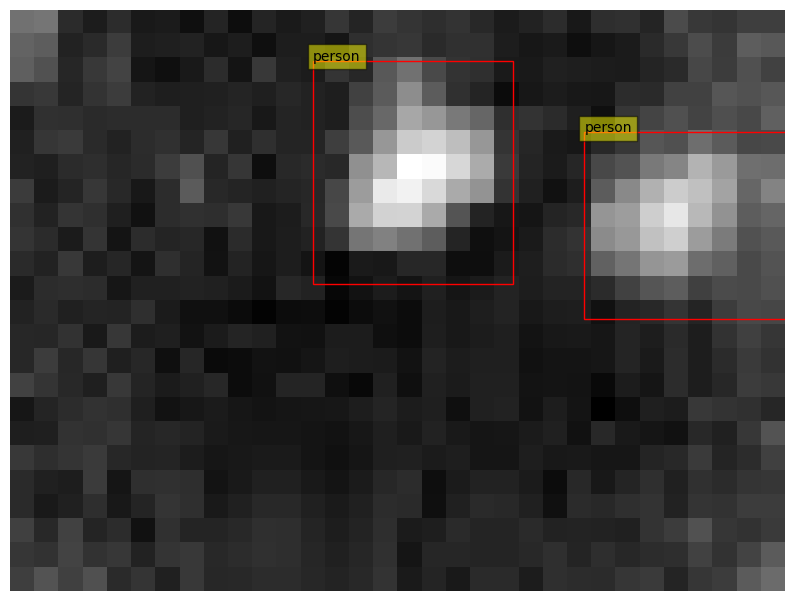

In [ ]:
class_names = ['person']  # 클래스 이름 리스트

for img, _, _ in val_dataset.take(1):    
    predictions = inference_model.predict(tf.expand_dims(img[0], axis=0))  # 첫 번째 이미지에 대한 예측 결과
    print(predictions)
    draw_bounding_boxes(img[0].numpy(), predictions, class_names)  # 디코딩된 바운딩 박스를 이미지에 그리기
    

In [ ]:
from tensorflow import keras
custom_objects = {
    'DepthwiseSeparableConv': DepthwiseSeparableConv,
    'DepthwiseConv': DepthwiseConv,
    'Conv': Conv,
    'Bottleneck': Bottleneck,
    'CSPDenseLayer': CSPDenseLayer,
    'ChannelAttention': ChannelAttention,
    'SpatialAttention': SpatialAttention,
    'CBAM': CBAM,
    'SPPF': SPPFast,
    'BackBone': BackBone,
    'NeckLayer': NeckLayer,
    'HeadLayer': HeadLayer,
    'CustomModel': CustomModel,
    'DecodePredictions': DecodePredictions
}

export_path = 'ObjectDetection/model_v6_backup_plan'
inference_model.save(export_path, save_format="tf")

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca842421f0>, 140537728700800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca842421f0>, 140537728700800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8424c6d0>, 140537729000928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8424c6d0>, 140537729000928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8425b700>, 140537729327312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8425b700>, 140537729327312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8426a6a0>, 140537729253904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8426a6a0>, 140537729253904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841fe5b0>, 140548309242864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841fe5b0>, 140548309242864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca842124f0>, 140548309243344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca842124f0>, 140548309243344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 4, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84225430>, 140507910703184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 4, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84225430>, 140507910703184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84235400>, 140507910704784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84235400>, 140507910704784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841c83a0>, 140537728064528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841c83a0>, 140537728064528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841d9340>, 140537728064688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841d9340>, 140537728064688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 4, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841ea250>, 140537727778608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 4, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841ea250>, 140537727778608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8417e220>, 140537727647792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8417e220>, 140537727647792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8418f1c0>, 140537727648592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8418f1c0>, 140537727648592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841a1160>, 140537727648752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841a1160>, 140537727648752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 8, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841b4070>, 140537727651472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 8, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841b4070>, 140537727651472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8414a040>, 140537727651632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8414a040>, 140537727651632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8414afa0>, 140537729830960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8414afa0>, 140537729830960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8415bf40>, 140537729831840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8415bf40>, 140537729831840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 4, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8416fe50>, 140537730359664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 4, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8416fe50>, 140537730359664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84100e20>, 140537730359824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84100e20>, 140537730359824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8410fdc0>, 140537729683504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8410fdc0>, 140537729683504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84124d60>, 140537731303360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84124d60>, 140537731303360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 4, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84136c70>, 140537730479088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 4, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84136c70>, 140537730479088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840c8c40>, 140537730479248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840c8c40>, 140537730479248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840d9be0>, 140537730096976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840d9be0>, 140537730096976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840ebb80>, 140537730095744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840ebb80>, 140537730095744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8407ca90>, 140537732703856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8407ca90>, 140537732703856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8408da60>, 140537732704016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8408da60>, 140537732704016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8409fa00>, 140537732704816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8409fa00>, 140537732704816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840b29a0>, 140537732704976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840b29a0>, 140537732704976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 8, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840438b0>, 140537731367184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 8, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840438b0>, 140537731367184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84055880>, 140537731368416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84055880>, 140537731368416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84067820>, 140537731372496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84067820>, 140537731372496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840787c0>, 140537731372656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840787c0>, 140537731372656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7cd6d0>, 140537731374096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7cd6d0>, 140537731374096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7dc610>, 140537731374576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7dc610>, 140537731374576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 8, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7f6550>, 140537732403248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 8, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7f6550>, 140537732403248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e788520>, 140537732403408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e788520>, 140537732403408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7984c0>, 140537732404208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7984c0>, 140537732404208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7aa460>, 140537732404368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7aa460>, 140537732404368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 8, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7bc370>, 140537732407088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 8, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7bc370>, 140537732407088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e74d340>, 140537732223024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e74d340>, 140537732223024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e75f2e0>, 140537732223824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e75f2e0>, 140537732223824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e771280>, 140537732223984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e771280>, 140537732223984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e703190>, 140537732226704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e703190>, 140537732226704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e715160>, 140537732226864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e715160>, 140537732226864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e728100>, 140537732011616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e728100>, 140537732011616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6bf0a0>, 140537732011088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6bf0a0>, 140537732011088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 8, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6bff70>, 140537732108656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 8, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6bff70>, 140537732108656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6d3f40>, 140537732108816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6d3f40>, 140537732108816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6e3ee0>, 140537732416768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6e3ee0>, 140537732416768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6f6e80>, 140537732418880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6f6e80>, 140537732418880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 8, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e687d90>, 140537731691504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 8, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e687d90>, 140537731691504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e69bd60>, 140537731691664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e69bd60>, 140537731691664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6abd00>, 140537730518512), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6abd00>, 140537730518512), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6bbca0>, 140537730515696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6bbca0>, 140537730515696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e64ebb0>, 140537731655280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e64ebb0>, 140537731655280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e660b80>, 140537731655440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e660b80>, 140537731655440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e671b20>, 140537731656400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e671b20>, 140537731656400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e603ac0>, 140537731656560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e603ac0>, 140537731656560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 80, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6179d0>, 140537731970528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 80, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6179d0>, 140537731970528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e627910>, 140537731970864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e627910>, 140537731970864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6388e0>, 140537731971312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6388e0>, 140537731971312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5cb880>, 140537731471280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5cb880>, 140537731471280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5dd820>, 140537731471440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5dd820>, 140537731471440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5ed730>, 140537731472880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5ed730>, 140537731472880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e57e670>, 140537731743952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e57e670>, 140537731743952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5965b0>, 140537731744592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5965b0>, 140537731744592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5a8580>, 140537731744752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5a8580>, 140537731744752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5ba520>, 140537731745712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5ba520>, 140537731745712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e54c4c0>, 140537731745872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e54c4c0>, 140537731745872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e55c3d0>, 140537726657360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e55c3d0>, 140537726657360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e56f3a0>, 140537726657520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e56f3a0>, 140537726657520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1dc340>, 140537726658480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1dc340>, 140537726658480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1ed2e0>, 140537726658640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1ed2e0>, 140537726658640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1ff1f0>, 140537726686032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1ff1f0>, 140537726686032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c2151c0>, 140537726686192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c2151c0>, 140537726686192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1a8160>, 140537732712032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1a8160>, 140537732712032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1b7100>, 140537732712208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1b7100>, 140537732712208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1d1040>, 140537726727792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1d1040>, 140537726727792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1d1fa0>, 140537726727952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1d1fa0>, 140537726727952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c161f40>, 140537737042736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c161f40>, 140537737042736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c175ee0>, 140537732686928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c175ee0>, 140537732686928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c185df0>, 140537726237072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c185df0>, 140537726237072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c198dc0>, 140537726237232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c198dc0>, 140537726237232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c12ad60>, 140537731030336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c12ad60>, 140537731030336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c13bd00>, 140537730988672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c13bd00>, 140537730988672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c14dc10>, 140537726266544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c14dc10>, 140537726266544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0dfbe0>, 140537726266704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0dfbe0>, 140537726266704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0efb80>, 140537726292336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0efb80>, 140537726292336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c101b20>, 140537726292496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c101b20>, 140537726292496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c113a30>, 140537726318384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c113a30>, 140537726318384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0a4a00>, 140537726318720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0a4a00>, 140537726318720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0b69a0>, 140537726295376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0b69a0>, 140537726295376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0c9940>, 140537726295536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0c9940>, 140537726295536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c05c850>, 140537726347728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c05c850>, 140537726347728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c06b820>, 140537726370400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c06b820>, 140537726370400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c07d730>, 140537726350640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c07d730>, 140537726350640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c08f700>, 140537726350800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c08f700>, 140537726350800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0206a0>, 140537726351760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0206a0>, 140537726351760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c036640>, 140537726351920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c036640>, 140537726351920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c04a550>, 140537726449264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c04a550>, 140537726449264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42fc2520>, 140537726449424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42fc2520>, 140537726449424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42fd34c0>, 140537726450384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42fd34c0>, 140537726450384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42fe5460>, 140537726450544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42fe5460>, 140537726450544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42ff8370>, 140537725978544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42ff8370>, 140537725978544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f88340>, 140537725978704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f88340>, 140537725978704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f9b2e0>, 140537726018288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f9b2e0>, 140537726018288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42fac280>, 140537726018816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42fac280>, 140537726018816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f3f190>, 140537726027696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f3f190>, 140537726027696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f51160>, 140537726027856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f51160>, 140537726027856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f63100>, 140537726083824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f63100>, 140537726083824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f7c0a0>, 140537726084352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f7c0a0>, 140537726084352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f7cf70>, 140537726093232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f7cf70>, 140537726093232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f0ef40>, 140537726093392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f0ef40>, 140537726093392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f1fee0>, 140537726152928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f1fee0>, 140537726152928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f32e80>, 140537726153456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f32e80>, 140537726153456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42ec4d90>, 140537726162864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42ec4d90>, 140537726162864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42ed7d60>, 140537726163024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42ed7d60>, 140537726163024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42ee6d00>, 140537726163984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42ee6d00>, 140537726163984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42ef8ca0>, 140537726164144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42ef8ca0>, 140537726164144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e8cbb0>, 140537725700224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e8cbb0>, 140537725700224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e9db80>, 140537725700560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e9db80>, 140537725700560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42eb0b20>, 140537726220688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42eb0b20>, 140537726220688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e40ac0>, 140537726220848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e40ac0>, 140537726220848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e529d0>, 140537725737760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e529d0>, 140537725737760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e649a0>, 140537725776816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e649a0>, 140537725776816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 12, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e748b0>, 140537725825392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 12, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e748b0>, 140537725825392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e05880>, 140537725825552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e05880>, 140537725825552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e1a820>, 140537725826512), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e1a820>, 140537725826512), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e2c7c0>, 140537725826672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e2c7c0>, 140537725826672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 12, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42dbe6d0>, 140537725870768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 12, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42dbe6d0>, 140537725870768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42dd06a0>, 140537725870928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42dd06a0>, 140537725870928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42de6640>, 140537725871888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42de6640>, 140537725871888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42dfa5e0>, 140537725872048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42dfa5e0>, 140537725872048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d8b4f0>, 140537725932528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d8b4f0>, 140537725932528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d9c4c0>, 140537725932688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d9c4c0>, 140537725932688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42daf460>, 140537725930464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42daf460>, 140537725930464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d40400>, 140537725930992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d40400>, 140537725930992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 8, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d53310>, 140537725490160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 8, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d53310>, 140537725490160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d642e0>, 140537725490320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d642e0>, 140537725490320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d79280>, 140537725467616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d79280>, 140537725467616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d09220>, 140537725468144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d09220>, 140537725468144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 8, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d1c130>, 140537725551600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 8, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d1c130>, 140537725551600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d2f100>, 140537725551760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d2f100>, 140537725551760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4018a0a0>, 140537725541344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4018a0a0>, 140537725541344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4019f040>, 140537725541872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4019f040>, 140537725541872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4019ff10>, 140537725613040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4019ff10>, 140537725613040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca401b0ee0>, 140537725613200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca401b0ee0>, 140537725613200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40143e80>, 140537725614160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40143e80>, 140537725614160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40154e20>, 140537725614320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40154e20>, 140537725614320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40165d30>, 140537725565728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40165d30>, 140537725565728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40175d00>, 140537725566064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40175d00>, 140537725566064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 160, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4010ac10>, 140537725666768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 160, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4010ac10>, 140537725666768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4011ab50>, 140537725667408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4011ab50>, 140537725667408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 40, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4012ca90>, 140537725668048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 40, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4012ca90>, 140537725668048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4013fa60>, 140537725668208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4013fa60>, 140537725668208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400d2a00>, 140537725669168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400d2a00>, 140537725669168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400e49a0>, 140537725239344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400e49a0>, 140537725239344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 40, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400f68b0>, 140537725242384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 40, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400f68b0>, 140537725242384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40086880>, 140537725242544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40086880>, 140537725242544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40097820>, 140537725296848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40097820>, 140537725296848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400aa7c0>, 140537725297008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400aa7c0>, 140537725297008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400bd6d0>, 140537725300048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400bd6d0>, 140537725300048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4004e6a0>, 140537725300208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4004e6a0>, 140537725300208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40065640>, 140537725343152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40065640>, 140537725343152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400785e0>, 140537725343680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400785e0>, 140537725343680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4000d4f0>, 140537725365584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4000d4f0>, 140537725365584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4001e4c0>, 140537725365744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4001e4c0>, 140537725365744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4002e460>, 140537725408688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4002e460>, 140537725408688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40042400>, 140537725409216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40042400>, 140537725409216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca387c9310>, 140537725418832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca387c9310>, 140537725418832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca387dc2e0>, 140537725418992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca387dc2e0>, 140537725418992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca387ee280>, 140537724957600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca387ee280>, 140537724957600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3877f220>, 140537724958128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3877f220>, 140537724958128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38794130>, 140537724951888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38794130>, 140537724951888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca387a6100>, 140537724952048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca387a6100>, 140537724952048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3873e0a0>, 140537725018640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3873e0a0>, 140537725018640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38750040>, 140537725018800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38750040>, 140537725018800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38750f10>, 140537724986624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38750f10>, 140537724986624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38764ee0>, 140537724986960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38764ee0>, 140537724986960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 192, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38774df0>, 140537725022000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 192, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38774df0>, 140537725022000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38704d30>, 140537725112848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38704d30>, 140537725112848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38717c70>, 140537725113488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38717c70>, 140537725113488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38729c40>, 140537725113648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38729c40>, 140537725113648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386bbbe0>, 140537725114608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386bbbe0>, 140537725114608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386cdb80>, 140537725114768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386cdb80>, 140537725114768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386dea90>, 140537724650960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386dea90>, 140537724650960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386f1a60>, 140537724651120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386f1a60>, 140537724651120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38682a00>, 140537724652080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38682a00>, 140537724652080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386959a0>, 140537724652240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386959a0>, 140537724652240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386a58b0>, 140537724712720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386a58b0>, 140537724712720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386b7880>, 140537724712880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386b7880>, 140537724712880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3864b820>, 140537724722144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3864b820>, 140537724722144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3865d7c0>, 140537724722672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3865d7c0>, 140537724722672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386706d0>, 140537724761872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386706d0>, 140537724761872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386006a0>, 140537724762032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386006a0>, 140537724762032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38617640>, 140537724799968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38617640>, 140537724799968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3862b5e0>, 140537724800496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3862b5e0>, 140537724800496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385bb4f0>, 140537724831504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385bb4f0>, 140537724831504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385cd4c0>, 140537724831664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385cd4c0>, 140537724831664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385df460>, 140537724864976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385df460>, 140537724864976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385f1400>, 140537724865504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385f1400>, 140537724865504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 128, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38583310>, 140537724897040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 128, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38583310>, 140537724897040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385952e0>, 140537724897200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385952e0>, 140537724897200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385a5280>, 140537724898160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385a5280>, 140537724898160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385b8220>, 140537724898320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385b8220>, 140537724898320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38549130>, 140537724486320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38549130>, 140537724486320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3855d100>, 140537724750416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3855d100>, 140537724750416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385740a0>, 140537724750704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385740a0>, 140537724750704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38574f70>, 140537724541568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38574f70>, 140537724541568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38507f40>, 140537724750224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38507f40>, 140537724750224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38518ee0>, 140537724511984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38518ee0>, 140537724511984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 9), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38529df0>, 140537724602048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 9), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38529df0>, 140537724602048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(9,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca384bddc0>, 140537724514096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(9,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca384bddc0>, 140537724514096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(9,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca384ccd60>, 140537724513040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(9,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca384ccd60>, 140537724513040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca384dfc70>, 140532745841440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca384dfc70>, 140532745841440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca384f0c40>, 140532745841280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca384f0c40>, 140532745841280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38482b50>, 140532745869712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38482b50>, 140532745869712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38494b20>, 140532745869552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38494b20>, 140532745869552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 36), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca384a7a30>, 140532745869312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 36), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca384a7a30>, 140532745869312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(36,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3843aa00>, 140532745868592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(36,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3843aa00>, 140532745868592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca842421f0>, 140537728700800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca842421f0>, 140537728700800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8424c6d0>, 140537729000928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8424c6d0>, 140537729000928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8425b700>, 140537729327312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8425b700>, 140537729327312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8426a6a0>, 140537729253904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8426a6a0>, 140537729253904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841fe5b0>, 140548309242864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841fe5b0>, 140548309242864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca842124f0>, 140548309243344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca842124f0>, 140548309243344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 4, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84225430>, 140507910703184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 4, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84225430>, 140507910703184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84235400>, 140507910704784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84235400>, 140507910704784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841c83a0>, 140537728064528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841c83a0>, 140537728064528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841d9340>, 140537728064688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841d9340>, 140537728064688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 4, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841ea250>, 140537727778608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 4, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841ea250>, 140537727778608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8417e220>, 140537727647792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8417e220>, 140537727647792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8418f1c0>, 140537727648592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8418f1c0>, 140537727648592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841a1160>, 140537727648752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841a1160>, 140537727648752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 8, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841b4070>, 140537727651472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 8, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca841b4070>, 140537727651472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8414a040>, 140537727651632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8414a040>, 140537727651632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8414afa0>, 140537729830960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8414afa0>, 140537729830960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8415bf40>, 140537729831840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8415bf40>, 140537729831840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 4, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8416fe50>, 140537730359664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 4, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8416fe50>, 140537730359664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84100e20>, 140537730359824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84100e20>, 140537730359824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8410fdc0>, 140537729683504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8410fdc0>, 140537729683504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84124d60>, 140537731303360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84124d60>, 140537731303360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 4, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84136c70>, 140537730479088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 4, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84136c70>, 140537730479088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840c8c40>, 140537730479248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840c8c40>, 140537730479248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840d9be0>, 140537730096976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840d9be0>, 140537730096976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840ebb80>, 140537730095744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840ebb80>, 140537730095744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8407ca90>, 140537732703856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8407ca90>, 140537732703856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8408da60>, 140537732704016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8408da60>, 140537732704016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8409fa00>, 140537732704816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca8409fa00>, 140537732704816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840b29a0>, 140537732704976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840b29a0>, 140537732704976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 8, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840438b0>, 140537731367184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 8, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840438b0>, 140537731367184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84055880>, 140537731368416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84055880>, 140537731368416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84067820>, 140537731372496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca84067820>, 140537731372496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840787c0>, 140537731372656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca840787c0>, 140537731372656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7cd6d0>, 140537731374096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7cd6d0>, 140537731374096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7dc610>, 140537731374576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7dc610>, 140537731374576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 8, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7f6550>, 140537732403248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 8, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7f6550>, 140537732403248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e788520>, 140537732403408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e788520>, 140537732403408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7984c0>, 140537732404208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7984c0>, 140537732404208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7aa460>, 140537732404368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7aa460>, 140537732404368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 8, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7bc370>, 140537732407088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 8, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e7bc370>, 140537732407088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e74d340>, 140537732223024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e74d340>, 140537732223024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e75f2e0>, 140537732223824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e75f2e0>, 140537732223824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e771280>, 140537732223984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e771280>, 140537732223984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e703190>, 140537732226704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e703190>, 140537732226704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e715160>, 140537732226864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e715160>, 140537732226864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e728100>, 140537732011616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e728100>, 140537732011616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6bf0a0>, 140537732011088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6bf0a0>, 140537732011088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 8, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6bff70>, 140537732108656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 8, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6bff70>, 140537732108656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6d3f40>, 140537732108816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6d3f40>, 140537732108816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6e3ee0>, 140537732416768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6e3ee0>, 140537732416768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6f6e80>, 140537732418880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6f6e80>, 140537732418880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 8, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e687d90>, 140537731691504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 8, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e687d90>, 140537731691504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e69bd60>, 140537731691664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e69bd60>, 140537731691664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6abd00>, 140537730518512), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6abd00>, 140537730518512), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6bbca0>, 140537730515696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6bbca0>, 140537730515696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e64ebb0>, 140537731655280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e64ebb0>, 140537731655280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e660b80>, 140537731655440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e660b80>, 140537731655440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e671b20>, 140537731656400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e671b20>, 140537731656400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e603ac0>, 140537731656560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e603ac0>, 140537731656560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 80, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6179d0>, 140537731970528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 80, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6179d0>, 140537731970528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e627910>, 140537731970864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e627910>, 140537731970864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6388e0>, 140537731971312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e6388e0>, 140537731971312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5cb880>, 140537731471280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5cb880>, 140537731471280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5dd820>, 140537731471440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5dd820>, 140537731471440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5ed730>, 140537731472880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5ed730>, 140537731472880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e57e670>, 140537731743952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e57e670>, 140537731743952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5965b0>, 140537731744592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5965b0>, 140537731744592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5a8580>, 140537731744752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5a8580>, 140537731744752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5ba520>, 140537731745712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e5ba520>, 140537731745712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e54c4c0>, 140537731745872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e54c4c0>, 140537731745872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e55c3d0>, 140537726657360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e55c3d0>, 140537726657360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e56f3a0>, 140537726657520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6e56f3a0>, 140537726657520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1dc340>, 140537726658480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1dc340>, 140537726658480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1ed2e0>, 140537726658640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1ed2e0>, 140537726658640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1ff1f0>, 140537726686032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1ff1f0>, 140537726686032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c2151c0>, 140537726686192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c2151c0>, 140537726686192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1a8160>, 140537732712032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1a8160>, 140537732712032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1b7100>, 140537732712208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1b7100>, 140537732712208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1d1040>, 140537726727792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1d1040>, 140537726727792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1d1fa0>, 140537726727952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c1d1fa0>, 140537726727952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c161f40>, 140537737042736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c161f40>, 140537737042736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c175ee0>, 140537732686928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c175ee0>, 140537732686928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c185df0>, 140537726237072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c185df0>, 140537726237072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c198dc0>, 140537726237232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c198dc0>, 140537726237232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c12ad60>, 140537731030336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c12ad60>, 140537731030336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c13bd00>, 140537730988672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c13bd00>, 140537730988672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c14dc10>, 140537726266544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c14dc10>, 140537726266544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0dfbe0>, 140537726266704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0dfbe0>, 140537726266704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0efb80>, 140537726292336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0efb80>, 140537726292336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c101b20>, 140537726292496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c101b20>, 140537726292496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c113a30>, 140537726318384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c113a30>, 140537726318384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0a4a00>, 140537726318720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0a4a00>, 140537726318720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0b69a0>, 140537726295376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0b69a0>, 140537726295376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0c9940>, 140537726295536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0c9940>, 140537726295536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c05c850>, 140537726347728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c05c850>, 140537726347728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c06b820>, 140537726370400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c06b820>, 140537726370400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c07d730>, 140537726350640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c07d730>, 140537726350640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c08f700>, 140537726350800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c08f700>, 140537726350800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0206a0>, 140537726351760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c0206a0>, 140537726351760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c036640>, 140537726351920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c036640>, 140537726351920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c04a550>, 140537726449264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca6c04a550>, 140537726449264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42fc2520>, 140537726449424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42fc2520>, 140537726449424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42fd34c0>, 140537726450384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42fd34c0>, 140537726450384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42fe5460>, 140537726450544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42fe5460>, 140537726450544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42ff8370>, 140537725978544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42ff8370>, 140537725978544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f88340>, 140537725978704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f88340>, 140537725978704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f9b2e0>, 140537726018288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f9b2e0>, 140537726018288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42fac280>, 140537726018816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42fac280>, 140537726018816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f3f190>, 140537726027696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f3f190>, 140537726027696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f51160>, 140537726027856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f51160>, 140537726027856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f63100>, 140537726083824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f63100>, 140537726083824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f7c0a0>, 140537726084352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f7c0a0>, 140537726084352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f7cf70>, 140537726093232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f7cf70>, 140537726093232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f0ef40>, 140537726093392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f0ef40>, 140537726093392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f1fee0>, 140537726152928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f1fee0>, 140537726152928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f32e80>, 140537726153456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42f32e80>, 140537726153456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42ec4d90>, 140537726162864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42ec4d90>, 140537726162864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42ed7d60>, 140537726163024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42ed7d60>, 140537726163024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42ee6d00>, 140537726163984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42ee6d00>, 140537726163984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42ef8ca0>, 140537726164144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42ef8ca0>, 140537726164144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e8cbb0>, 140537725700224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e8cbb0>, 140537725700224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e9db80>, 140537725700560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e9db80>, 140537725700560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42eb0b20>, 140537726220688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42eb0b20>, 140537726220688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e40ac0>, 140537726220848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e40ac0>, 140537726220848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e529d0>, 140537725737760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e529d0>, 140537725737760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e649a0>, 140537725776816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e649a0>, 140537725776816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 12, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e748b0>, 140537725825392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 12, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e748b0>, 140537725825392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e05880>, 140537725825552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e05880>, 140537725825552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e1a820>, 140537725826512), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e1a820>, 140537725826512), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e2c7c0>, 140537725826672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42e2c7c0>, 140537725826672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 12, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42dbe6d0>, 140537725870768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 12, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42dbe6d0>, 140537725870768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42dd06a0>, 140537725870928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42dd06a0>, 140537725870928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42de6640>, 140537725871888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42de6640>, 140537725871888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42dfa5e0>, 140537725872048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42dfa5e0>, 140537725872048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d8b4f0>, 140537725932528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d8b4f0>, 140537725932528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d9c4c0>, 140537725932688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d9c4c0>, 140537725932688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42daf460>, 140537725930464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42daf460>, 140537725930464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d40400>, 140537725930992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d40400>, 140537725930992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 8, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d53310>, 140537725490160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 8, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d53310>, 140537725490160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d642e0>, 140537725490320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d642e0>, 140537725490320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d79280>, 140537725467616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d79280>, 140537725467616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d09220>, 140537725468144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d09220>, 140537725468144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 8, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d1c130>, 140537725551600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 8, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d1c130>, 140537725551600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d2f100>, 140537725551760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca42d2f100>, 140537725551760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4018a0a0>, 140537725541344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4018a0a0>, 140537725541344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4019f040>, 140537725541872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4019f040>, 140537725541872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4019ff10>, 140537725613040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4019ff10>, 140537725613040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca401b0ee0>, 140537725613200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca401b0ee0>, 140537725613200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40143e80>, 140537725614160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40143e80>, 140537725614160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40154e20>, 140537725614320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40154e20>, 140537725614320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40165d30>, 140537725565728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40165d30>, 140537725565728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40175d00>, 140537725566064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40175d00>, 140537725566064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 160, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4010ac10>, 140537725666768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 160, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4010ac10>, 140537725666768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4011ab50>, 140537725667408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4011ab50>, 140537725667408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 40, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4012ca90>, 140537725668048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 40, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4012ca90>, 140537725668048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4013fa60>, 140537725668208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4013fa60>, 140537725668208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400d2a00>, 140537725669168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400d2a00>, 140537725669168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400e49a0>, 140537725239344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400e49a0>, 140537725239344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 40, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400f68b0>, 140537725242384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 40, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400f68b0>, 140537725242384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40086880>, 140537725242544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40086880>, 140537725242544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40097820>, 140537725296848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40097820>, 140537725296848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400aa7c0>, 140537725297008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400aa7c0>, 140537725297008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400bd6d0>, 140537725300048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400bd6d0>, 140537725300048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4004e6a0>, 140537725300208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4004e6a0>, 140537725300208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40065640>, 140537725343152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40065640>, 140537725343152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400785e0>, 140537725343680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca400785e0>, 140537725343680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4000d4f0>, 140537725365584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4000d4f0>, 140537725365584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4001e4c0>, 140537725365744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4001e4c0>, 140537725365744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4002e460>, 140537725408688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca4002e460>, 140537725408688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40042400>, 140537725409216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca40042400>, 140537725409216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca387c9310>, 140537725418832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 16, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca387c9310>, 140537725418832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca387dc2e0>, 140537725418992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca387dc2e0>, 140537725418992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca387ee280>, 140537724957600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca387ee280>, 140537724957600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3877f220>, 140537724958128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3877f220>, 140537724958128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38794130>, 140537724951888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38794130>, 140537724951888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca387a6100>, 140537724952048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca387a6100>, 140537724952048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3873e0a0>, 140537725018640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3873e0a0>, 140537725018640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38750040>, 140537725018800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38750040>, 140537725018800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38750f10>, 140537724986624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38750f10>, 140537724986624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38764ee0>, 140537724986960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38764ee0>, 140537724986960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 192, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38774df0>, 140537725022000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 192, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38774df0>, 140537725022000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38704d30>, 140537725112848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38704d30>, 140537725112848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38717c70>, 140537725113488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38717c70>, 140537725113488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38729c40>, 140537725113648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38729c40>, 140537725113648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386bbbe0>, 140537725114608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386bbbe0>, 140537725114608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386cdb80>, 140537725114768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386cdb80>, 140537725114768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386dea90>, 140537724650960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386dea90>, 140537724650960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386f1a60>, 140537724651120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386f1a60>, 140537724651120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38682a00>, 140537724652080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38682a00>, 140537724652080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386959a0>, 140537724652240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386959a0>, 140537724652240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386a58b0>, 140537724712720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386a58b0>, 140537724712720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386b7880>, 140537724712880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386b7880>, 140537724712880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3864b820>, 140537724722144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3864b820>, 140537724722144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3865d7c0>, 140537724722672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3865d7c0>, 140537724722672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386706d0>, 140537724761872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386706d0>, 140537724761872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386006a0>, 140537724762032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca386006a0>, 140537724762032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38617640>, 140537724799968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38617640>, 140537724799968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3862b5e0>, 140537724800496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3862b5e0>, 140537724800496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385bb4f0>, 140537724831504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385bb4f0>, 140537724831504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385cd4c0>, 140537724831664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385cd4c0>, 140537724831664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385df460>, 140537724864976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385df460>, 140537724864976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385f1400>, 140537724865504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385f1400>, 140537724865504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 128, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38583310>, 140537724897040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 128, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38583310>, 140537724897040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385952e0>, 140537724897200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385952e0>, 140537724897200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385a5280>, 140537724898160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385a5280>, 140537724898160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385b8220>, 140537724898320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385b8220>, 140537724898320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38549130>, 140537724486320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38549130>, 140537724486320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3855d100>, 140537724750416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3855d100>, 140537724750416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385740a0>, 140537724750704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca385740a0>, 140537724750704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38574f70>, 140537724541568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38574f70>, 140537724541568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38507f40>, 140537724750224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38507f40>, 140537724750224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38518ee0>, 140537724511984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38518ee0>, 140537724511984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 9), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38529df0>, 140537724602048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 9), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38529df0>, 140537724602048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(9,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca384bddc0>, 140537724514096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(9,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca384bddc0>, 140537724514096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(9,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca384ccd60>, 140537724513040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(9,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca384ccd60>, 140537724513040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca384dfc70>, 140532745841440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca384dfc70>, 140532745841440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca384f0c40>, 140532745841280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca384f0c40>, 140532745841280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38482b50>, 140532745869712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38482b50>, 140532745869712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38494b20>, 140532745869552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca38494b20>, 140532745869552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 36), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca384a7a30>, 140532745869312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 64, 36), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca384a7a30>, 140532745869312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(36,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3843aa00>, 140532745868592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(36,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fca3843aa00>, 140532745868592), {}).


INFO:tensorflow:Assets written to: ObjectDetection/model_v6_backup_plan/assets


INFO:tensorflow:Assets written to: ObjectDetection/model_v6_backup_plan/assets


In [ ]:
import tensorflow as tf

custom_objects = {
    'DepthwiseSeparableConv': DepthwiseSeparableConv,
    'DepthwiseConv': DepthwiseConv,
    'Conv': Conv,
    'Bottleneck': Bottleneck,
    'CSPDenseLayer': CSPDenseLayer,
    'ChannelAttention': ChannelAttention,
    'SpatialAttention': SpatialAttention,
    'CBAM': CBAM,
    'SPPF': SPPFast,
    'BackBone': BackBone,
    'NeckLayer': NeckLayer,
    'HeadLayer': HeadLayer,
    'CustomModel': CustomModel,
    'DecodePredictions': DecodePredictions
}

export_path = 'ObjectDetection/model_v6_backup_plan'
loaded_model = tf.keras.models.load_model(export_path, custom_objects=custom_objects, compile=False)

1/1 [==============================] - 2s 2s/step
[[13.264364    6.1343675  23.527485   15.475422    0.9024629 ]
 [ 2.8286781  15.528865   10.256084   24.222515    0.78454024]
 [17.876837   12.115752   26.438547   22.692638    0.68433684]]


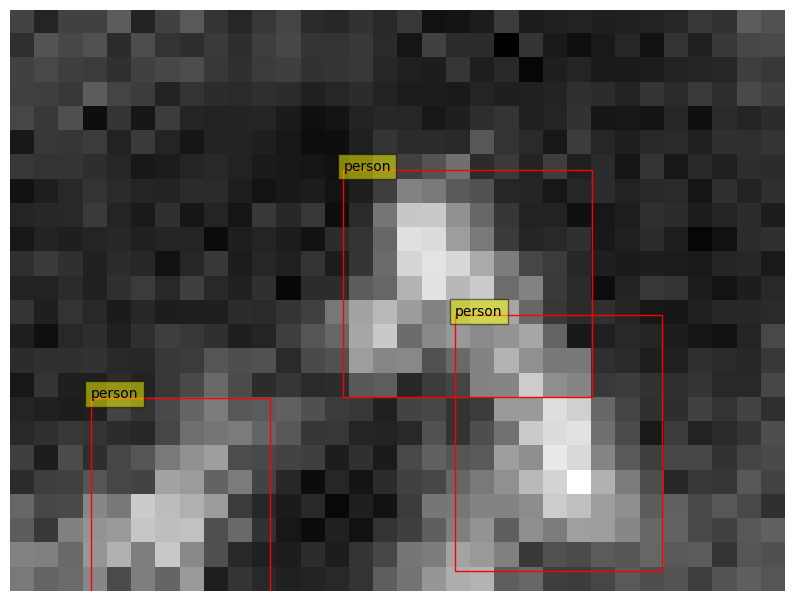

In [ ]:
class_names = ['person']  # 클래스 이름 리스트

for img, _, _ in val_dataset.take(1):    
    predictions = loaded_model.predict(tf.expand_dims(img[0], axis=0))  # 첫 번째 이미지에 대한 예측 결과
    print(predictions)
    draw_bounding_boxes(img[0].numpy(), predictions, class_names)  # 디코딩된 바운딩 박스를 이미지에 그리기
    

In [ ]:
import tensorflow as tf

saved_model_dir = 'ObjectDetection/model_v6_backup_plan'

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# 입력과 출력의 데이터 타입을 설정
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

tflite_model = converter.convert()
open('ObjectDetection/tflite/model_v6_backup_plan.tflite', 'wb').write(tflite_model)

2024-04-10 06:55:57.637005: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-10 06:55:57.637040: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-10 06:55:57.637232: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: ObjectDetection/model_v6_backup_plan
2024-04-10 06:55:57.689486: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-10 06:55:57.689518: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: ObjectDetection/model_v6_backup_plan
2024-04-10 06:55:57.832287: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-10 06:55:58.922800: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: ObjectDetection/model_v6_backup_plan
2024-04-10 06:55:59.277313: I tensorflow/cc/saved_model/loader.cc:316] SavedMode

512672

[[ 4.0808682  10.832113   15.307293   18.991947    0.8641057 ]
 [23.070305   16.131454   31.841785   23.00701     0.80745226]
 [ 4.0808682  10.832113   15.307293   18.991947    0.8641057 ]
 [ 4.0808682  10.832113   15.307293   18.991947    0.8641057 ]
 [ 4.0808682  10.832113   15.307293   18.991947    0.8641057 ]
 [ 4.0808682  10.832113   15.307293   18.991947    0.8641057 ]
 [ 4.0808682  10.832113   15.307293   18.991947    0.8641057 ]
 [ 4.0808682  10.832113   15.307293   18.991947    0.8641057 ]
 [ 4.0808682  10.832113   15.307293   18.991947    0.8641057 ]
 [ 4.0808682  10.832113   15.307293   18.991947    0.8641057 ]
 [ 4.0808682  10.832113   15.307293   18.991947    0.8641057 ]
 [ 4.0808682  10.832113   15.307293   18.991947    0.8641057 ]
 [ 4.0808682  10.832113   15.307293   18.991947    0.8641057 ]
 [ 4.0808682  10.832113   15.307293   18.991947    0.8641057 ]
 [ 4.0808682  10.832113   15.307293   18.991947    0.8641057 ]
 [ 4.0808682  10.832113   15.307293   18.991947    0.86

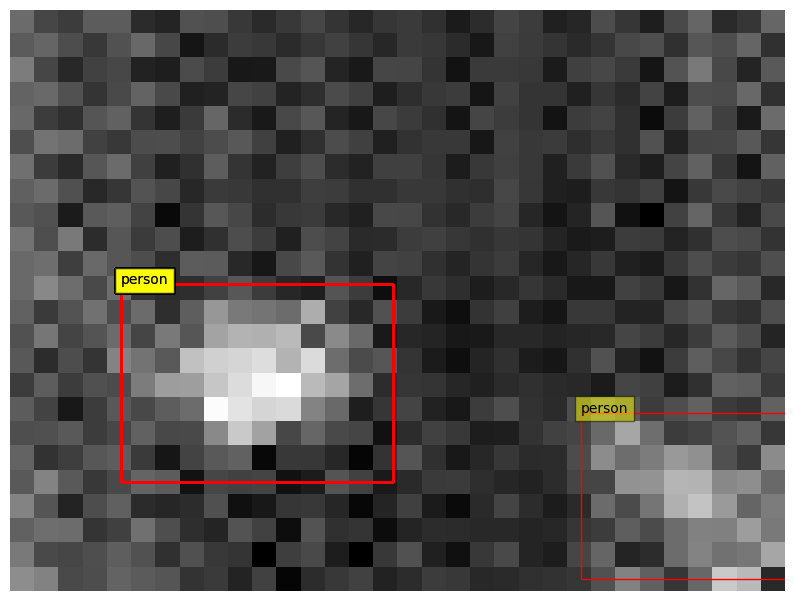

[[ 3.972959    6.9863644  13.930937   12.6434      0.61572945]
 [ 3.6598792   7.141263   14.434311   12.511196    0.5066445 ]
 [ 3.6598792   7.141263   14.434311   12.511196    0.5066445 ]
 [ 3.6598792   7.141263   14.434311   12.511196    0.5066445 ]
 [ 3.6598792   7.141263   14.434311   12.511196    0.5066445 ]
 [ 3.6598792   7.141263   14.434311   12.511196    0.5066445 ]
 [ 3.6598792   7.141263   14.434311   12.511196    0.5066445 ]
 [ 3.6598792   7.141263   14.434311   12.511196    0.5066445 ]
 [ 3.6598792   7.141263   14.434311   12.511196    0.5066445 ]
 [ 3.6598792   7.141263   14.434311   12.511196    0.5066445 ]
 [ 3.6598792   7.141263   14.434311   12.511196    0.5066445 ]
 [ 3.6598792   7.141263   14.434311   12.511196    0.5066445 ]
 [ 3.6598792   7.141263   14.434311   12.511196    0.5066445 ]
 [ 3.6598792   7.141263   14.434311   12.511196    0.5066445 ]
 [ 3.6598792   7.141263   14.434311   12.511196    0.5066445 ]
 [ 3.6598792   7.141263   14.434311   12.511196    0.50

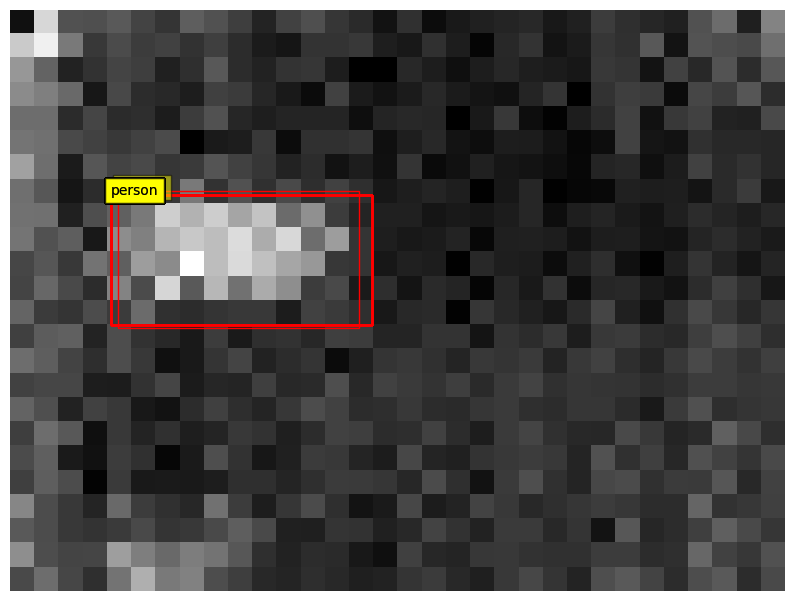

[[ 6.348988    4.516023   16.664595   15.150518    1.2606082 ]
 [24.720041    3.621109   32.03759    11.454997    0.900549  ]
 [24.666218    3.6172411  32.219387   11.43867     0.51220787]
 [24.666218    3.6172411  32.219387   11.43867     0.51220787]
 [24.666218    3.6172411  32.219387   11.43867     0.51220787]
 [24.666218    3.6172411  32.219387   11.43867     0.51220787]
 [24.666218    3.6172411  32.219387   11.43867     0.51220787]
 [24.666218    3.6172411  32.219387   11.43867     0.51220787]
 [24.666218    3.6172411  32.219387   11.43867     0.51220787]
 [24.666218    3.6172411  32.219387   11.43867     0.51220787]
 [24.666218    3.6172411  32.219387   11.43867     0.51220787]
 [24.666218    3.6172411  32.219387   11.43867     0.51220787]
 [24.666218    3.6172411  32.219387   11.43867     0.51220787]
 [24.666218    3.6172411  32.219387   11.43867     0.51220787]
 [24.666218    3.6172411  32.219387   11.43867     0.51220787]
 [24.666218    3.6172411  32.219387   11.43867     0.51

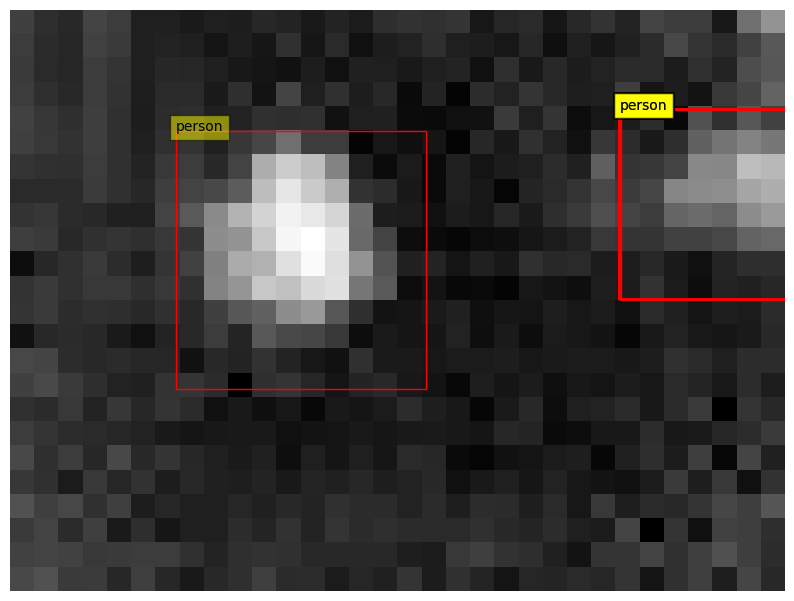

[[23.54891    12.354023   32.05356    18.78785     0.81840634]
 [23.482943   12.412833   32.132187   18.73338     0.77101034]
 [23.482943   12.412833   32.132187   18.73338     0.77101034]
 [23.482943   12.412833   32.132187   18.73338     0.77101034]
 [23.482943   12.412833   32.132187   18.73338     0.77101034]
 [23.482943   12.412833   32.132187   18.73338     0.77101034]
 [23.482943   12.412833   32.132187   18.73338     0.77101034]
 [23.482943   12.412833   32.132187   18.73338     0.77101034]
 [23.482943   12.412833   32.132187   18.73338     0.77101034]
 [23.482943   12.412833   32.132187   18.73338     0.77101034]
 [23.482943   12.412833   32.132187   18.73338     0.77101034]
 [23.482943   12.412833   32.132187   18.73338     0.77101034]
 [23.482943   12.412833   32.132187   18.73338     0.77101034]
 [23.482943   12.412833   32.132187   18.73338     0.77101034]
 [23.482943   12.412833   32.132187   18.73338     0.77101034]
 [23.482943   12.412833   32.132187   18.73338     0.77

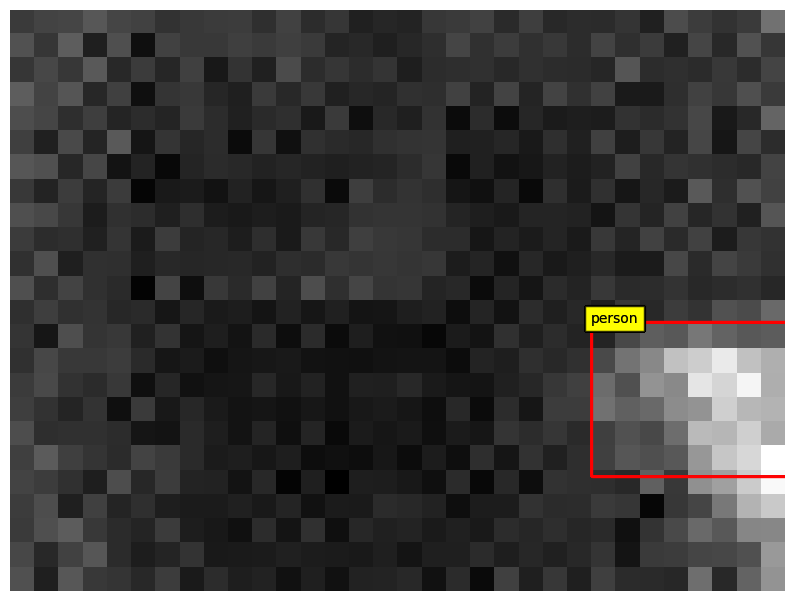

[[3.08981466e+00 5.50358915e+00 1.30821323e+01 1.39457798e+01
  1.07881165e+00]
 [2.33253403e+01 1.64604187e-02 3.21412125e+01 8.95724869e+00
  1.05952442e+00]
 [2.33267403e+01 1.20780945e-01 3.21873398e+01 9.14571857e+00
  8.03362131e-01]
 [2.33267403e+01 1.20780945e-01 3.21873398e+01 9.14571857e+00
  8.03362131e-01]
 [2.33267403e+01 1.20780945e-01 3.21873398e+01 9.14571857e+00
  8.03362131e-01]
 [2.33267403e+01 1.20780945e-01 3.21873398e+01 9.14571857e+00
  8.03362131e-01]
 [2.33267403e+01 1.20780945e-01 3.21873398e+01 9.14571857e+00
  8.03362131e-01]
 [2.33267403e+01 1.20780945e-01 3.21873398e+01 9.14571857e+00
  8.03362131e-01]
 [2.33267403e+01 1.20780945e-01 3.21873398e+01 9.14571857e+00
  8.03362131e-01]
 [2.33267403e+01 1.20780945e-01 3.21873398e+01 9.14571857e+00
  8.03362131e-01]
 [2.33267403e+01 1.20780945e-01 3.21873398e+01 9.14571857e+00
  8.03362131e-01]
 [2.33267403e+01 1.20780945e-01 3.21873398e+01 9.14571857e+00
  8.03362131e-01]
 [2.33267403e+01 1.20780945e-01 3.218733

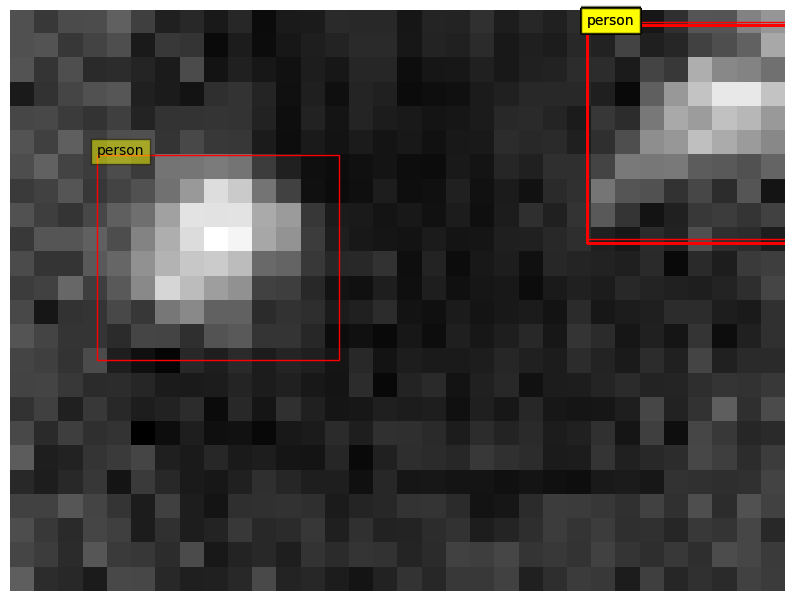

[[21.543594    1.4961653  31.872803   11.543779    1.3702296 ]
 [10.125526   12.975121   16.902967   23.392551    0.7593684 ]
 [21.530674    1.6547866  31.965858   11.734205    0.61078846]
 [21.530674    1.6547866  31.965858   11.734205    0.61078846]
 [21.530674    1.6547866  31.965858   11.734205    0.61078846]
 [21.530674    1.6547866  31.965858   11.734205    0.61078846]
 [21.530674    1.6547866  31.965858   11.734205    0.61078846]
 [21.530674    1.6547866  31.965858   11.734205    0.61078846]
 [21.530674    1.6547866  31.965858   11.734205    0.61078846]
 [21.530674    1.6547866  31.965858   11.734205    0.61078846]
 [21.530674    1.6547866  31.965858   11.734205    0.61078846]
 [21.530674    1.6547866  31.965858   11.734205    0.61078846]
 [21.530674    1.6547866  31.965858   11.734205    0.61078846]
 [21.530674    1.6547866  31.965858   11.734205    0.61078846]
 [21.530674    1.6547866  31.965858   11.734205    0.61078846]
 [21.530674    1.6547866  31.965858   11.734205    0.61

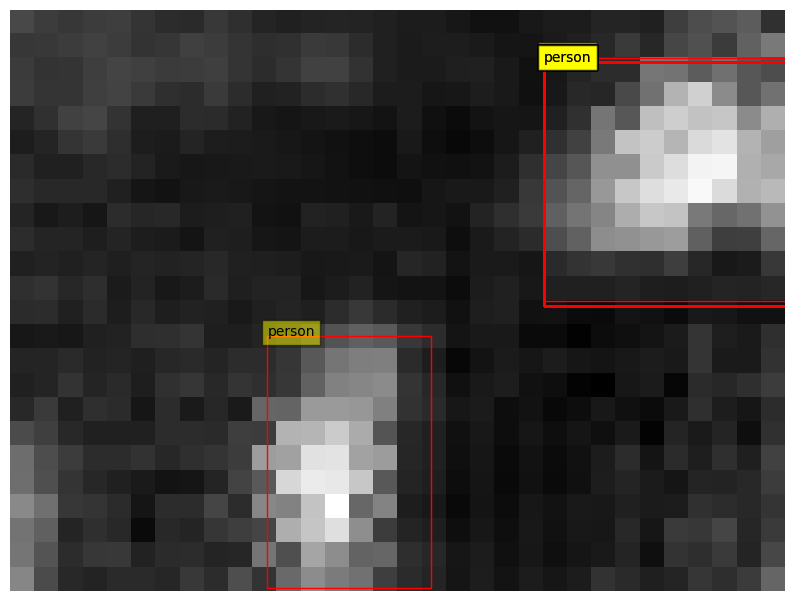

[[21.529657   9.444435  31.695671  17.358435   1.1488252]
 [ 3.4519377 11.320825  14.416587  18.555147   0.9220903]
 [ 5.102698   5.7664156 14.034586  12.780065   0.8490761]
 [ 5.132984   5.796644  13.684036  12.545219   0.7050559]
 [ 5.132984   5.796644  13.684036  12.545219   0.7050559]
 [ 5.132984   5.796644  13.684036  12.545219   0.7050559]
 [ 5.132984   5.796644  13.684036  12.545219   0.7050559]
 [ 5.132984   5.796644  13.684036  12.545219   0.7050559]
 [ 5.132984   5.796644  13.684036  12.545219   0.7050559]
 [ 5.132984   5.796644  13.684036  12.545219   0.7050559]
 [ 5.132984   5.796644  13.684036  12.545219   0.7050559]
 [ 5.132984   5.796644  13.684036  12.545219   0.7050559]
 [ 5.132984   5.796644  13.684036  12.545219   0.7050559]
 [ 5.132984   5.796644  13.684036  12.545219   0.7050559]
 [ 5.132984   5.796644  13.684036  12.545219   0.7050559]
 [ 5.132984   5.796644  13.684036  12.545219   0.7050559]
 [ 5.132984   5.796644  13.684036  12.545219   0.7050559]
 [ 5.132984   

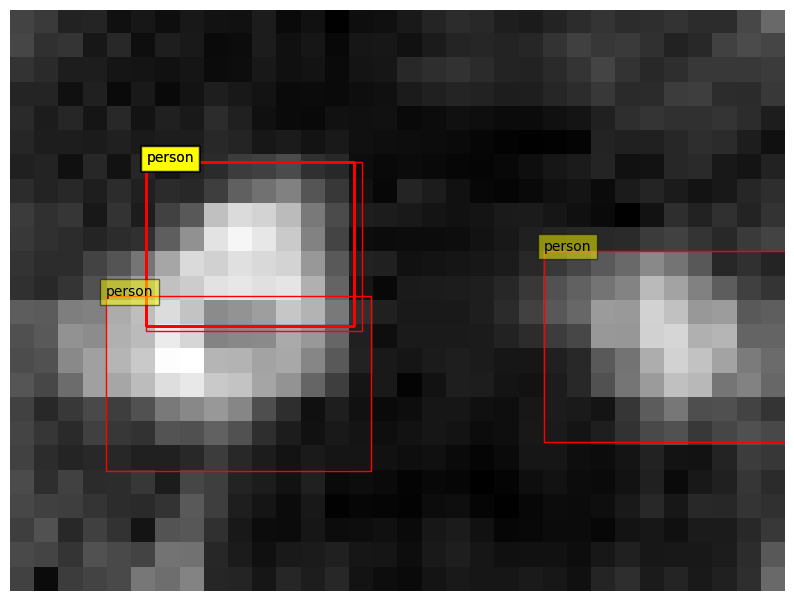

[[20.589043    0.98947144 32.329117   10.413987    1.1871943 ]
 [21.152515    9.850306   32.17014    16.670517    0.6834707 ]
 [20.373455    0.9755931  32.35       10.615711    0.6566682 ]
 [20.373455    0.9755931  32.35       10.615711    0.6566682 ]
 [20.373455    0.9755931  32.35       10.615711    0.6566682 ]
 [20.373455    0.9755931  32.35       10.615711    0.6566682 ]
 [20.373455    0.9755931  32.35       10.615711    0.6566682 ]
 [20.373455    0.9755931  32.35       10.615711    0.6566682 ]
 [20.373455    0.9755931  32.35       10.615711    0.6566682 ]
 [20.373455    0.9755931  32.35       10.615711    0.6566682 ]
 [20.373455    0.9755931  32.35       10.615711    0.6566682 ]
 [20.373455    0.9755931  32.35       10.615711    0.6566682 ]
 [20.373455    0.9755931  32.35       10.615711    0.6566682 ]
 [20.373455    0.9755931  32.35       10.615711    0.6566682 ]
 [20.373455    0.9755931  32.35       10.615711    0.6566682 ]
 [20.373455    0.9755931  32.35       10.615711    0.65

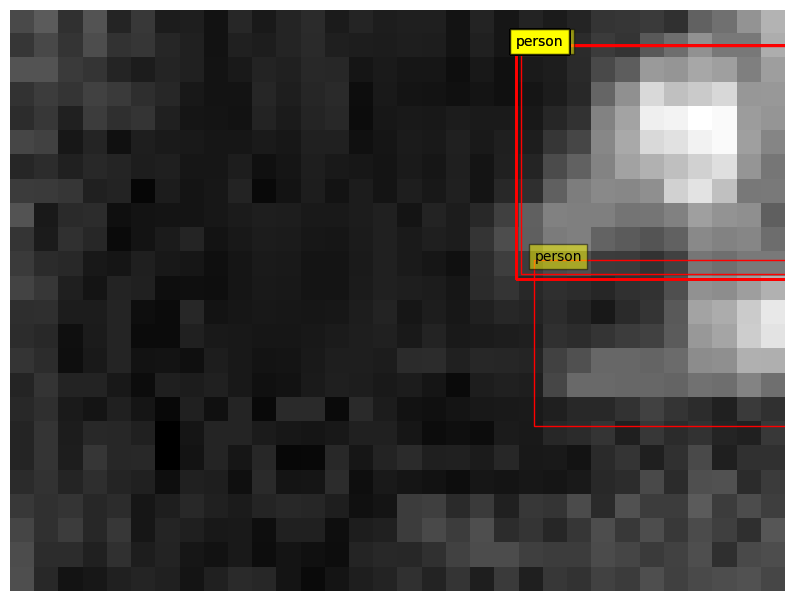

[[-0.22280216 14.7901     10.535398   23.92828     1.2816849 ]
 [22.779287    8.296628   32.08619    17.685532    1.1314186 ]
 [ 1.8810053   6.197585   11.776957   13.07655     0.77300847]
 [ 1.8387766   6.2336645  11.719382   13.0098915   0.7378698 ]
 [ 1.8387766   6.2336645  11.719382   13.0098915   0.7378698 ]
 [ 1.8387766   6.2336645  11.719382   13.0098915   0.7378698 ]
 [ 1.8387766   6.2336645  11.719382   13.0098915   0.7378698 ]
 [ 1.8387766   6.2336645  11.719382   13.0098915   0.7378698 ]
 [ 1.8387766   6.2336645  11.719382   13.0098915   0.7378698 ]
 [ 1.8387766   6.2336645  11.719382   13.0098915   0.7378698 ]
 [ 1.8387766   6.2336645  11.719382   13.0098915   0.7378698 ]
 [ 1.8387766   6.2336645  11.719382   13.0098915   0.7378698 ]
 [ 1.8387766   6.2336645  11.719382   13.0098915   0.7378698 ]
 [ 1.8387766   6.2336645  11.719382   13.0098915   0.7378698 ]
 [ 1.8387766   6.2336645  11.719382   13.0098915   0.7378698 ]
 [ 1.8387766   6.2336645  11.719382   13.0098915   0.73

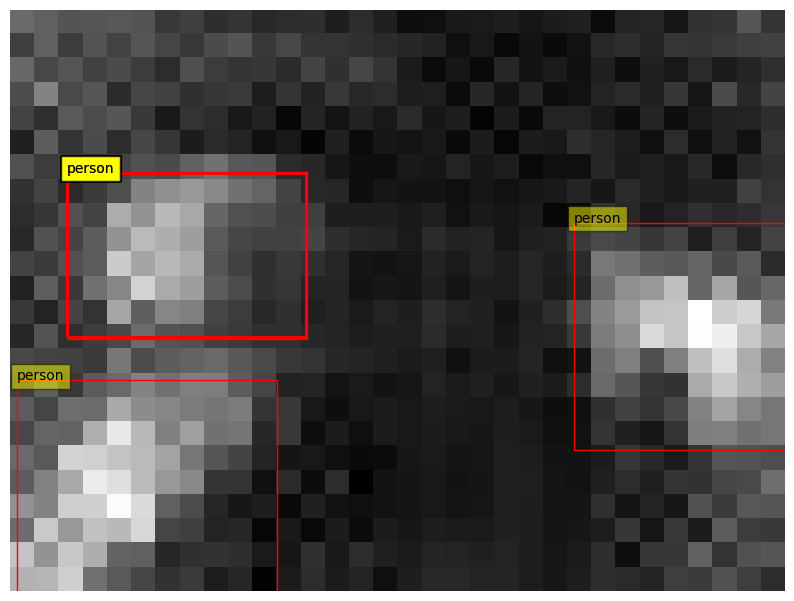

[[11.42402     8.456961   22.016418   18.075558    1.0930213 ]
 [ 8.889961    0.20487499 17.975006    8.823693    0.52995527]
 [ 8.889961    0.20487499 17.975006    8.823693    0.52995527]
 [ 8.889961    0.20487499 17.975006    8.823693    0.52995527]
 [ 8.889961    0.20487499 17.975006    8.823693    0.52995527]
 [ 8.889961    0.20487499 17.975006    8.823693    0.52995527]
 [ 8.889961    0.20487499 17.975006    8.823693    0.52995527]
 [ 8.889961    0.20487499 17.975006    8.823693    0.52995527]
 [ 8.889961    0.20487499 17.975006    8.823693    0.52995527]
 [ 8.889961    0.20487499 17.975006    8.823693    0.52995527]
 [ 8.889961    0.20487499 17.975006    8.823693    0.52995527]
 [ 8.889961    0.20487499 17.975006    8.823693    0.52995527]
 [ 8.889961    0.20487499 17.975006    8.823693    0.52995527]
 [ 8.889961    0.20487499 17.975006    8.823693    0.52995527]
 [ 8.889961    0.20487499 17.975006    8.823693    0.52995527]
 [ 8.889961    0.20487499 17.975006    8.823693    0.52

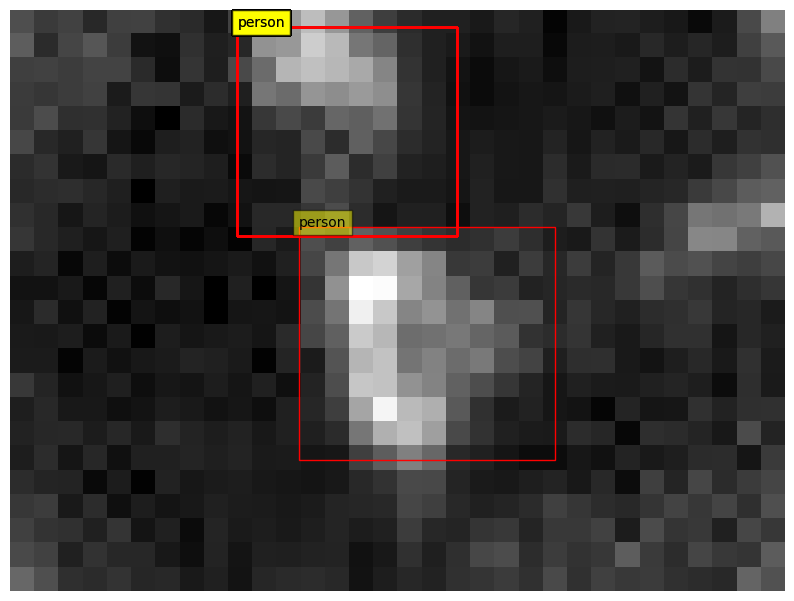

[[12.852024   3.202433  22.117699  13.932005   1.3187447]
 [13.499814  16.723515  21.19496   24.209846   0.936711 ]
 [12.903215   3.2950735 22.179588  14.01246    1.0033095]
 [12.903215   3.2950735 22.179588  14.01246    1.0033095]
 [12.903215   3.2950735 22.179588  14.01246    1.0033095]
 [12.903215   3.2950735 22.179588  14.01246    1.0033095]
 [12.903215   3.2950735 22.179588  14.01246    1.0033095]
 [12.903215   3.2950735 22.179588  14.01246    1.0033095]
 [12.903215   3.2950735 22.179588  14.01246    1.0033095]
 [12.903215   3.2950735 22.179588  14.01246    1.0033095]
 [12.903215   3.2950735 22.179588  14.01246    1.0033095]
 [12.903215   3.2950735 22.179588  14.01246    1.0033095]
 [12.903215   3.2950735 22.179588  14.01246    1.0033095]
 [12.903215   3.2950735 22.179588  14.01246    1.0033095]
 [12.903215   3.2950735 22.179588  14.01246    1.0033095]
 [12.903215   3.2950735 22.179588  14.01246    1.0033095]
 [12.903215   3.2950735 22.179588  14.01246    1.0033095]
 [12.903215   

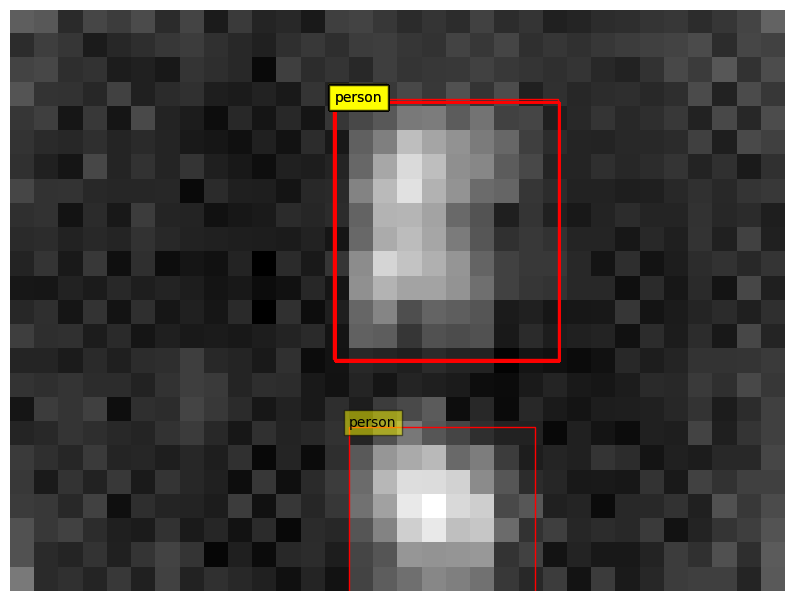

[[ 1.1710980e+01 -2.0892620e-03  2.2015633e+01  7.2920218e+00
   1.0176383e+00]
 [ 2.3469530e+01  5.4449010e+00  3.1240620e+01  1.4252533e+01
   1.0100110e+00]
 [ 1.1422117e+01 -8.0185175e-02  2.1597294e+01  7.2201471e+00
   5.2929580e-01]
 [ 1.1422117e+01 -8.0185175e-02  2.1597294e+01  7.2201471e+00
   5.2929580e-01]
 [ 1.1422117e+01 -8.0185175e-02  2.1597294e+01  7.2201471e+00
   5.2929580e-01]
 [ 1.1422117e+01 -8.0185175e-02  2.1597294e+01  7.2201471e+00
   5.2929580e-01]
 [ 1.1422117e+01 -8.0185175e-02  2.1597294e+01  7.2201471e+00
   5.2929580e-01]
 [ 1.1422117e+01 -8.0185175e-02  2.1597294e+01  7.2201471e+00
   5.2929580e-01]
 [ 1.1422117e+01 -8.0185175e-02  2.1597294e+01  7.2201471e+00
   5.2929580e-01]
 [ 1.1422117e+01 -8.0185175e-02  2.1597294e+01  7.2201471e+00
   5.2929580e-01]
 [ 1.1422117e+01 -8.0185175e-02  2.1597294e+01  7.2201471e+00
   5.2929580e-01]
 [ 1.1422117e+01 -8.0185175e-02  2.1597294e+01  7.2201471e+00
   5.2929580e-01]
 [ 1.1422117e+01 -8.0185175e-02  2.15972

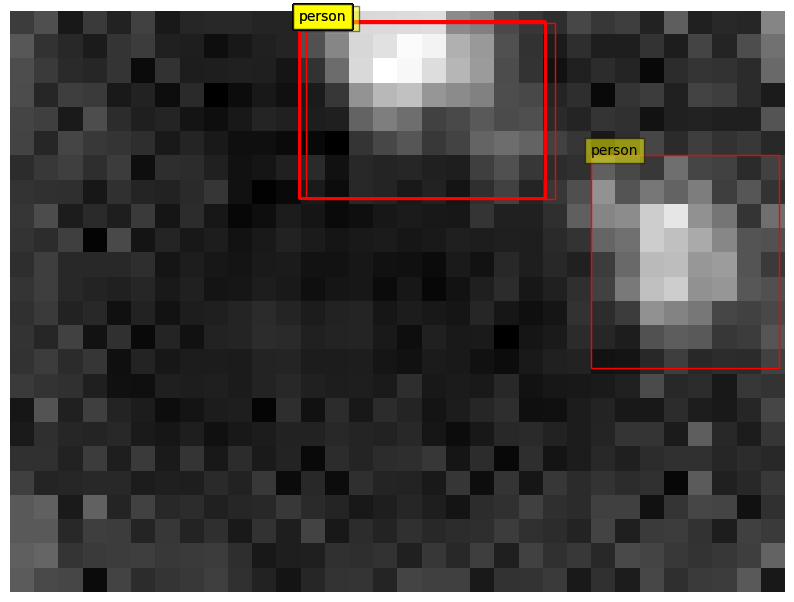

[[10.456955   2.067057  19.496162   8.540548   1.0058551]
 [22.654438   4.0581374 31.459053  12.93593    0.9533483]
 [10.417342   2.03925   19.47187    8.59193    0.5128888]
 [10.417342   2.03925   19.47187    8.59193    0.5128888]
 [10.417342   2.03925   19.47187    8.59193    0.5128888]
 [10.417342   2.03925   19.47187    8.59193    0.5128888]
 [10.417342   2.03925   19.47187    8.59193    0.5128888]
 [10.417342   2.03925   19.47187    8.59193    0.5128888]
 [10.417342   2.03925   19.47187    8.59193    0.5128888]
 [10.417342   2.03925   19.47187    8.59193    0.5128888]
 [10.417342   2.03925   19.47187    8.59193    0.5128888]
 [10.417342   2.03925   19.47187    8.59193    0.5128888]
 [10.417342   2.03925   19.47187    8.59193    0.5128888]
 [10.417342   2.03925   19.47187    8.59193    0.5128888]
 [10.417342   2.03925   19.47187    8.59193    0.5128888]
 [10.417342   2.03925   19.47187    8.59193    0.5128888]
 [10.417342   2.03925   19.47187    8.59193    0.5128888]
 [10.417342   

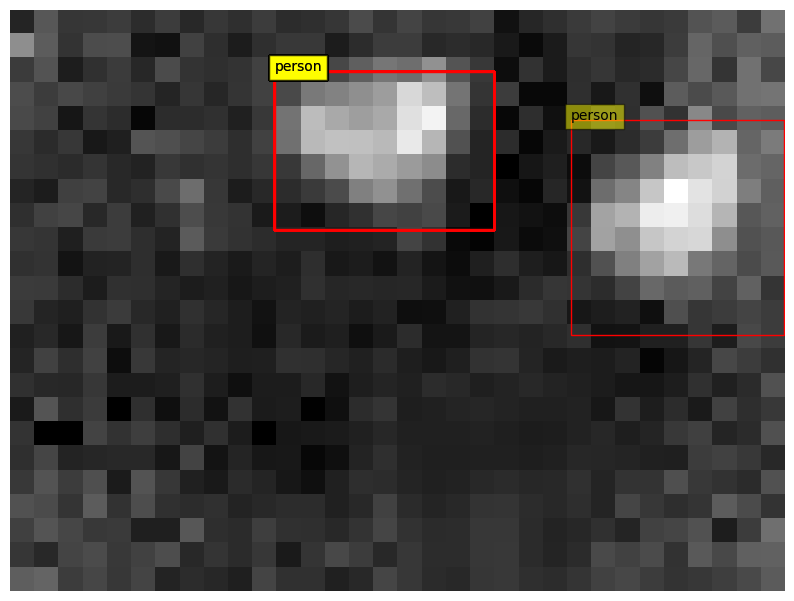

[[19.73587     5.608074   28.95727    13.005611    0.9791146 ]
 [ 8.635307    1.9976375  15.917205    9.931394    0.93225724]
 [ 8.676664    1.8909073  15.792365    9.972769    0.8140558 ]
 [ 8.676664    1.8909073  15.792365    9.972769    0.8140558 ]
 [ 8.676664    1.8909073  15.792365    9.972769    0.8140558 ]
 [ 8.676664    1.8909073  15.792365    9.972769    0.8140558 ]
 [ 8.676664    1.8909073  15.792365    9.972769    0.8140558 ]
 [ 8.676664    1.8909073  15.792365    9.972769    0.8140558 ]
 [ 8.676664    1.8909073  15.792365    9.972769    0.8140558 ]
 [ 8.676664    1.8909073  15.792365    9.972769    0.8140558 ]
 [ 8.676664    1.8909073  15.792365    9.972769    0.8140558 ]
 [ 8.676664    1.8909073  15.792365    9.972769    0.8140558 ]
 [ 8.676664    1.8909073  15.792365    9.972769    0.8140558 ]
 [ 8.676664    1.8909073  15.792365    9.972769    0.8140558 ]
 [ 8.676664    1.8909073  15.792365    9.972769    0.8140558 ]
 [ 8.676664    1.8909073  15.792365    9.972769    0.81

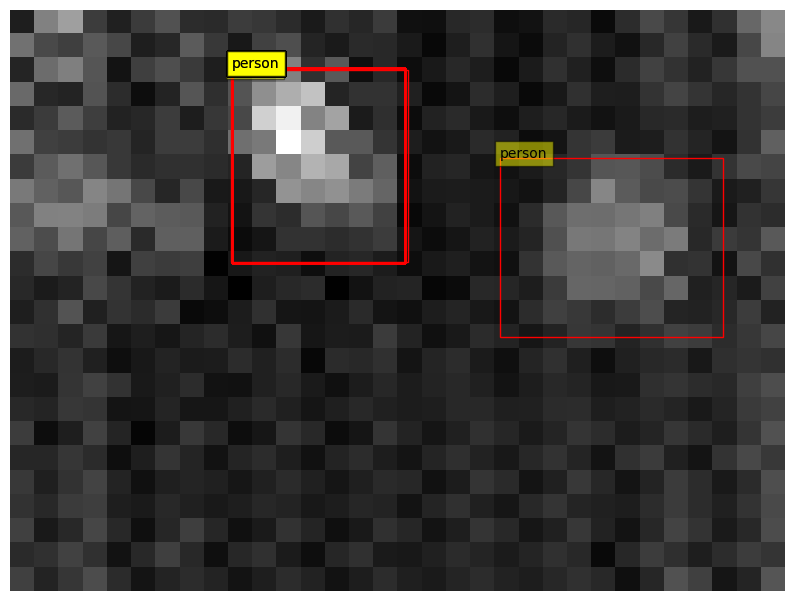

[[22.426985    0.26473284 31.362085   10.452791    1.2314147 ]
 [12.268446    1.2711539  20.354507   12.400797    0.8804388 ]
 [ 1.9706402   5.100956   10.829775   11.187275    0.80228156]
 [22.431936    0.46108532 31.286932   10.330504    0.58605313]
 [22.431936    0.46108532 31.286932   10.330504    0.58605313]
 [22.431936    0.46108532 31.286932   10.330504    0.58605313]
 [22.431936    0.46108532 31.286932   10.330504    0.58605313]
 [22.431936    0.46108532 31.286932   10.330504    0.58605313]
 [22.431936    0.46108532 31.286932   10.330504    0.58605313]
 [22.431936    0.46108532 31.286932   10.330504    0.58605313]
 [22.431936    0.46108532 31.286932   10.330504    0.58605313]
 [22.431936    0.46108532 31.286932   10.330504    0.58605313]
 [22.431936    0.46108532 31.286932   10.330504    0.58605313]
 [22.431936    0.46108532 31.286932   10.330504    0.58605313]
 [22.431936    0.46108532 31.286932   10.330504    0.58605313]
 [22.431936    0.46108532 31.286932   10.330504    0.58

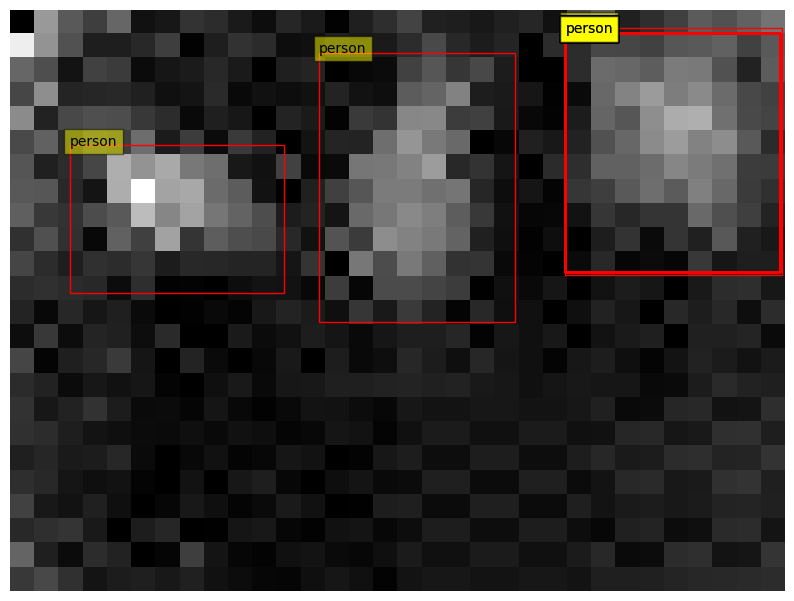

[[1.9004284e+01 5.8998652e+00 2.8289684e+01 1.4025569e+01 1.1890354e+00]
 [2.0804646e+01 7.0638180e-02 3.0217695e+01 7.8232279e+00 1.0028845e+00]
 [1.2485423e+00 8.9165459e+00 1.1846794e+01 1.6080416e+01 8.0940080e-01]
 [2.0942619e+01 2.5868654e-02 2.9988108e+01 7.8816996e+00 5.4808199e-01]
 [2.0942619e+01 2.5868654e-02 2.9988108e+01 7.8816996e+00 5.4808199e-01]
 [2.0942619e+01 2.5868654e-02 2.9988108e+01 7.8816996e+00 5.4808199e-01]
 [2.0942619e+01 2.5868654e-02 2.9988108e+01 7.8816996e+00 5.4808199e-01]
 [2.0942619e+01 2.5868654e-02 2.9988108e+01 7.8816996e+00 5.4808199e-01]
 [2.0942619e+01 2.5868654e-02 2.9988108e+01 7.8816996e+00 5.4808199e-01]
 [2.0942619e+01 2.5868654e-02 2.9988108e+01 7.8816996e+00 5.4808199e-01]
 [2.0942619e+01 2.5868654e-02 2.9988108e+01 7.8816996e+00 5.4808199e-01]
 [2.0942619e+01 2.5868654e-02 2.9988108e+01 7.8816996e+00 5.4808199e-01]
 [2.0942619e+01 2.5868654e-02 2.9988108e+01 7.8816996e+00 5.4808199e-01]
 [2.0942619e+01 2.5868654e-02 2.9988108e+01 7.88169

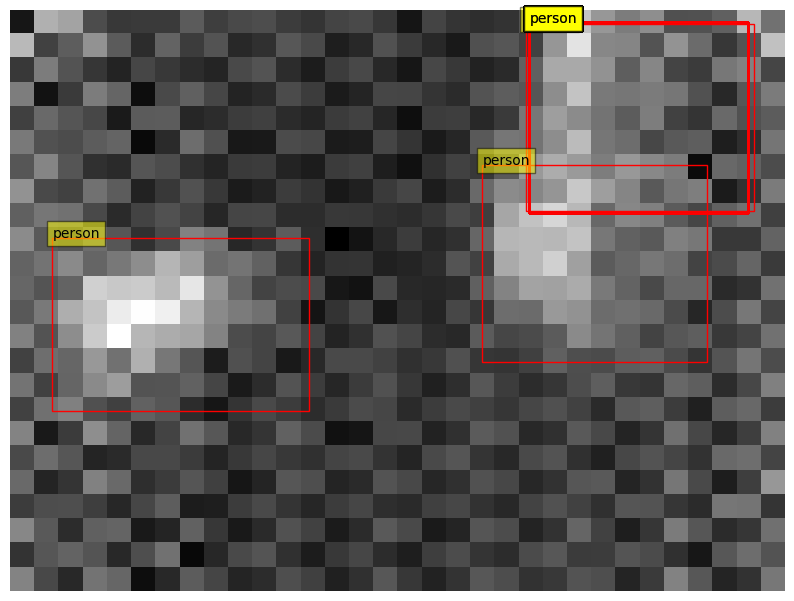

[[22.549818    0.2908094  30.021557    7.8898563   0.76725274]
 [22.467026    0.51182675 29.998484    7.887212    0.54919004]
 [22.467026    0.51182675 29.998484    7.887212    0.54919004]
 [22.467026    0.51182675 29.998484    7.887212    0.54919004]
 [22.467026    0.51182675 29.998484    7.887212    0.54919004]
 [22.467026    0.51182675 29.998484    7.887212    0.54919004]
 [22.467026    0.51182675 29.998484    7.887212    0.54919004]
 [22.467026    0.51182675 29.998484    7.887212    0.54919004]
 [22.467026    0.51182675 29.998484    7.887212    0.54919004]
 [22.467026    0.51182675 29.998484    7.887212    0.54919004]
 [22.467026    0.51182675 29.998484    7.887212    0.54919004]
 [22.467026    0.51182675 29.998484    7.887212    0.54919004]
 [22.467026    0.51182675 29.998484    7.887212    0.54919004]
 [22.467026    0.51182675 29.998484    7.887212    0.54919004]
 [22.467026    0.51182675 29.998484    7.887212    0.54919004]
 [22.467026    0.51182675 29.998484    7.887212    0.54

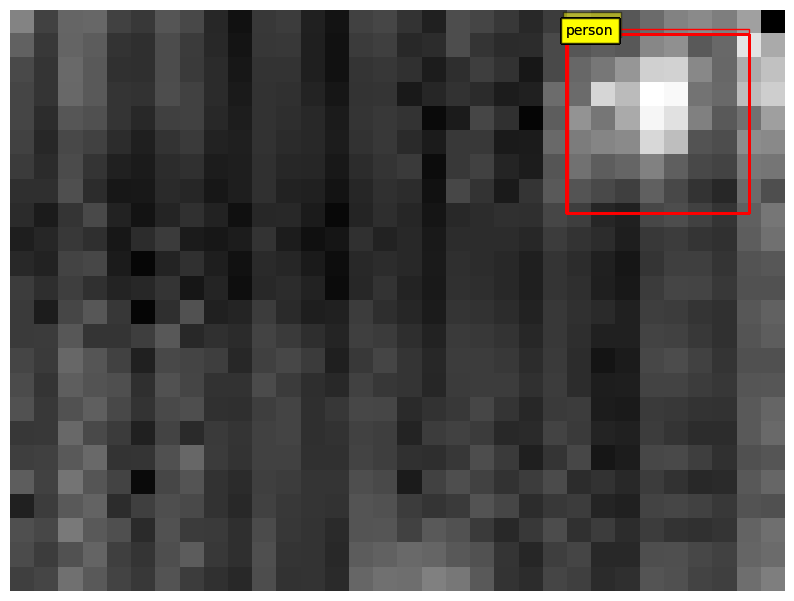

[[16.697693    0.18073082 25.043905   11.29783     0.99380577]
 [23.70041     0.503211   31.494213   11.2079315   0.5863632 ]
 [16.873909    0.10049915 25.129433   11.397672    0.57591105]
 [16.873909    0.10049915 25.129433   11.397672    0.57591105]
 [16.873909    0.10049915 25.129433   11.397672    0.57591105]
 [16.873909    0.10049915 25.129433   11.397672    0.57591105]
 [16.873909    0.10049915 25.129433   11.397672    0.57591105]
 [16.873909    0.10049915 25.129433   11.397672    0.57591105]
 [16.873909    0.10049915 25.129433   11.397672    0.57591105]
 [16.873909    0.10049915 25.129433   11.397672    0.57591105]
 [16.873909    0.10049915 25.129433   11.397672    0.57591105]
 [16.873909    0.10049915 25.129433   11.397672    0.57591105]
 [16.873909    0.10049915 25.129433   11.397672    0.57591105]
 [16.873909    0.10049915 25.129433   11.397672    0.57591105]
 [16.873909    0.10049915 25.129433   11.397672    0.57591105]
 [16.873909    0.10049915 25.129433   11.397672    0.57

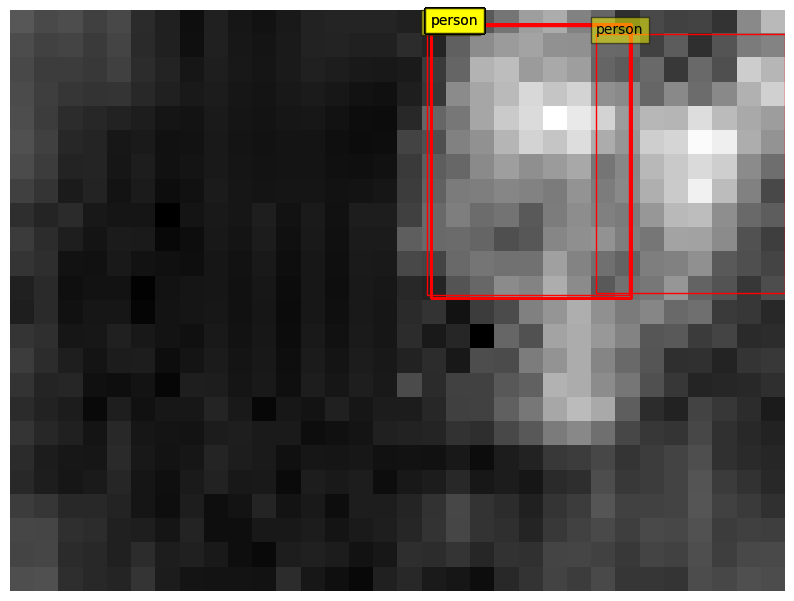

[[20.972942    1.4355884  32.15751    10.807022    1.1884968 ]
 [22.300743    9.917424   32.08641    17.085142    0.9340518 ]
 [20.83353     1.2784157  32.30107    10.851518    0.53012323]
 [20.83353     1.2784157  32.30107    10.851518    0.53012323]
 [20.83353     1.2784157  32.30107    10.851518    0.53012323]
 [20.83353     1.2784157  32.30107    10.851518    0.53012323]
 [20.83353     1.2784157  32.30107    10.851518    0.53012323]
 [20.83353     1.2784157  32.30107    10.851518    0.53012323]
 [20.83353     1.2784157  32.30107    10.851518    0.53012323]
 [20.83353     1.2784157  32.30107    10.851518    0.53012323]
 [20.83353     1.2784157  32.30107    10.851518    0.53012323]
 [20.83353     1.2784157  32.30107    10.851518    0.53012323]
 [20.83353     1.2784157  32.30107    10.851518    0.53012323]
 [20.83353     1.2784157  32.30107    10.851518    0.53012323]
 [20.83353     1.2784157  32.30107    10.851518    0.53012323]
 [20.83353     1.2784157  32.30107    10.851518    0.53

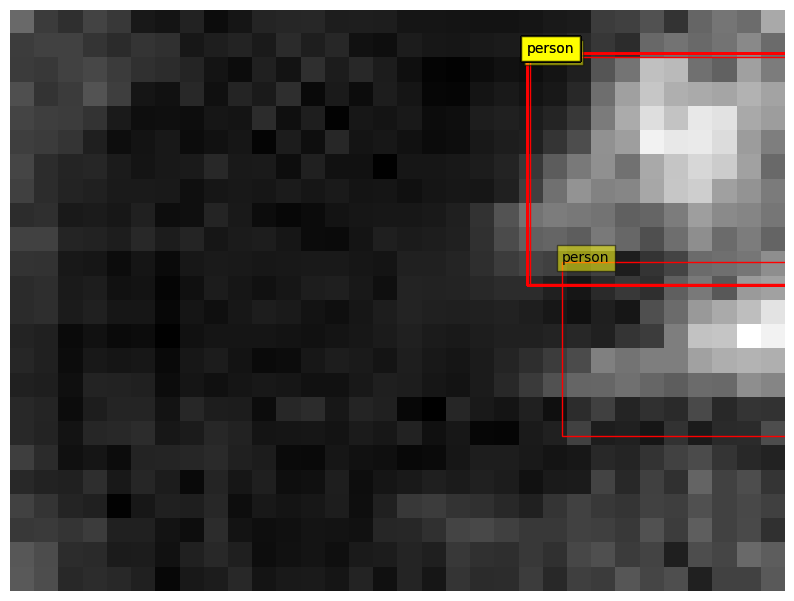

[[ 1.4728962e+01  1.3243488e+01  2.5360992e+01  2.2502663e+01
   1.2235463e+00]
 [ 1.0360928e+01  1.6603210e+01  1.7867687e+01  2.4190674e+01
   7.8946644e-01]
 [ 8.0626011e-03  1.8206358e-02  6.5992126e+00  7.4508514e+00
   7.1741033e-01]
 [-5.3314924e-02  5.0421476e-02  6.5831461e+00  7.2316999e+00
   5.3350180e-01]
 [-5.3314924e-02  5.0421476e-02  6.5831461e+00  7.2316999e+00
   5.3350180e-01]
 [-5.3314924e-02  5.0421476e-02  6.5831461e+00  7.2316999e+00
   5.3350180e-01]
 [-5.3314924e-02  5.0421476e-02  6.5831461e+00  7.2316999e+00
   5.3350180e-01]
 [-5.3314924e-02  5.0421476e-02  6.5831461e+00  7.2316999e+00
   5.3350180e-01]
 [-5.3314924e-02  5.0421476e-02  6.5831461e+00  7.2316999e+00
   5.3350180e-01]
 [-5.3314924e-02  5.0421476e-02  6.5831461e+00  7.2316999e+00
   5.3350180e-01]
 [-5.3314924e-02  5.0421476e-02  6.5831461e+00  7.2316999e+00
   5.3350180e-01]
 [-5.3314924e-02  5.0421476e-02  6.5831461e+00  7.2316999e+00
   5.3350180e-01]
 [-5.3314924e-02  5.0421476e-02  6.58314

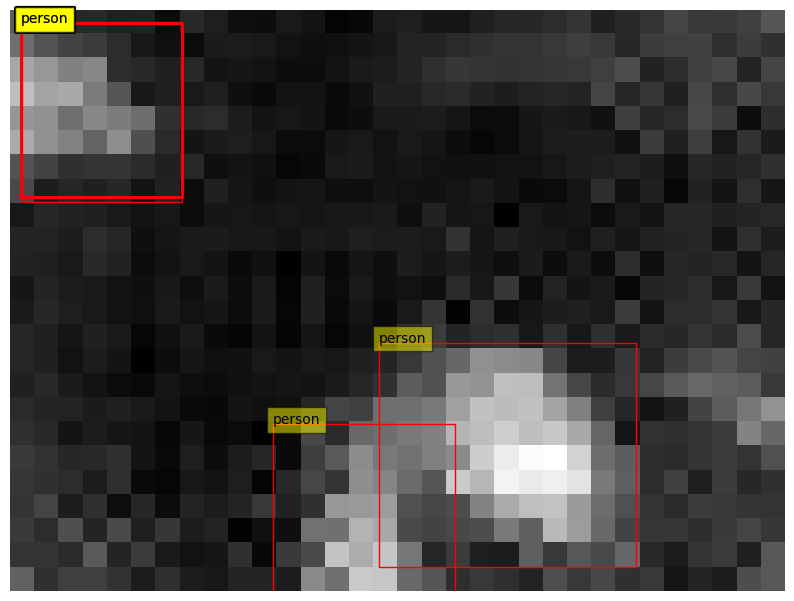

[[22.154675    7.3710985  30.634087   13.431093    0.7904625 ]
 [22.247025    7.300238   30.691105   13.625267    0.69818515]
 [22.247025    7.300238   30.691105   13.625267    0.69818515]
 [22.247025    7.300238   30.691105   13.625267    0.69818515]
 [22.247025    7.300238   30.691105   13.625267    0.69818515]
 [22.247025    7.300238   30.691105   13.625267    0.69818515]
 [22.247025    7.300238   30.691105   13.625267    0.69818515]
 [22.247025    7.300238   30.691105   13.625267    0.69818515]
 [22.247025    7.300238   30.691105   13.625267    0.69818515]
 [22.247025    7.300238   30.691105   13.625267    0.69818515]
 [22.247025    7.300238   30.691105   13.625267    0.69818515]
 [22.247025    7.300238   30.691105   13.625267    0.69818515]
 [22.247025    7.300238   30.691105   13.625267    0.69818515]
 [22.247025    7.300238   30.691105   13.625267    0.69818515]
 [22.247025    7.300238   30.691105   13.625267    0.69818515]
 [22.247025    7.300238   30.691105   13.625267    0.69

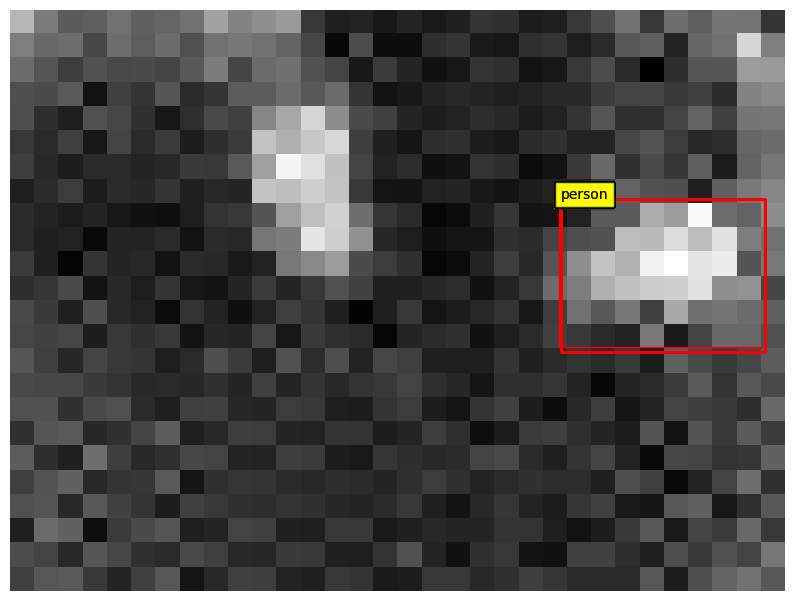

[[ 5.3221045   0.08618283 12.68508     6.0265903   0.8866062 ]
 [ 5.2786965  -0.02086735 12.764124    5.8540125   0.6655911 ]
 [ 5.2786965  -0.02086735 12.764124    5.8540125   0.6655911 ]
 [ 5.2786965  -0.02086735 12.764124    5.8540125   0.6655911 ]
 [ 5.2786965  -0.02086735 12.764124    5.8540125   0.6655911 ]
 [ 5.2786965  -0.02086735 12.764124    5.8540125   0.6655911 ]
 [ 5.2786965  -0.02086735 12.764124    5.8540125   0.6655911 ]
 [ 5.2786965  -0.02086735 12.764124    5.8540125   0.6655911 ]
 [ 5.2786965  -0.02086735 12.764124    5.8540125   0.6655911 ]
 [ 5.2786965  -0.02086735 12.764124    5.8540125   0.6655911 ]
 [ 5.2786965  -0.02086735 12.764124    5.8540125   0.6655911 ]
 [ 5.2786965  -0.02086735 12.764124    5.8540125   0.6655911 ]
 [ 5.2786965  -0.02086735 12.764124    5.8540125   0.6655911 ]
 [ 5.2786965  -0.02086735 12.764124    5.8540125   0.6655911 ]
 [ 5.2786965  -0.02086735 12.764124    5.8540125   0.6655911 ]
 [ 5.2786965  -0.02086735 12.764124    5.8540125   0.66

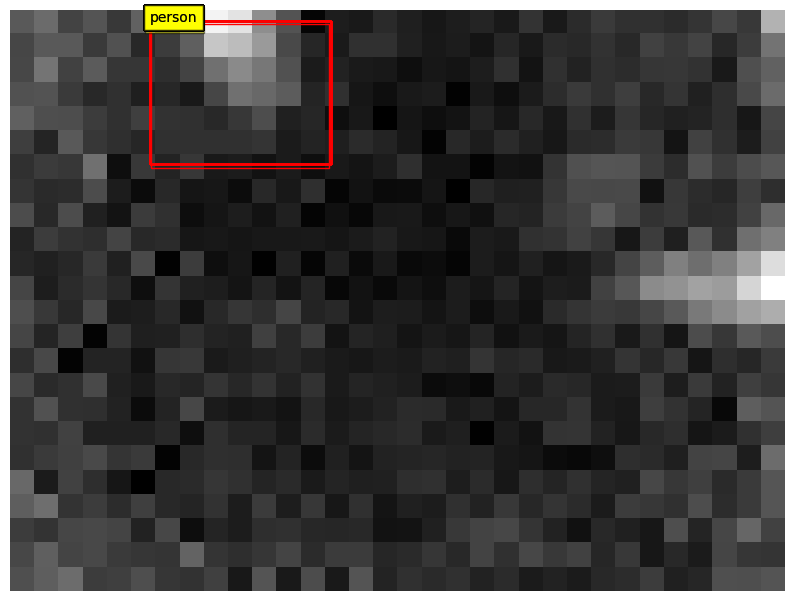

[[14.883123   5.1832147 26.250555  15.102434   1.1311163]
 [22.173317  13.212002  30.54562   22.182137   0.8105863]
 [14.619276   4.7209606 26.082897  15.075569   0.8227565]
 [14.619276   4.7209606 26.082897  15.075569   0.8227565]
 [14.619276   4.7209606 26.082897  15.075569   0.8227565]
 [14.619276   4.7209606 26.082897  15.075569   0.8227565]
 [14.619276   4.7209606 26.082897  15.075569   0.8227565]
 [14.619276   4.7209606 26.082897  15.075569   0.8227565]
 [14.619276   4.7209606 26.082897  15.075569   0.8227565]
 [14.619276   4.7209606 26.082897  15.075569   0.8227565]
 [14.619276   4.7209606 26.082897  15.075569   0.8227565]
 [14.619276   4.7209606 26.082897  15.075569   0.8227565]
 [14.619276   4.7209606 26.082897  15.075569   0.8227565]
 [14.619276   4.7209606 26.082897  15.075569   0.8227565]
 [14.619276   4.7209606 26.082897  15.075569   0.8227565]
 [14.619276   4.7209606 26.082897  15.075569   0.8227565]
 [14.619276   4.7209606 26.082897  15.075569   0.8227565]
 [14.619276   

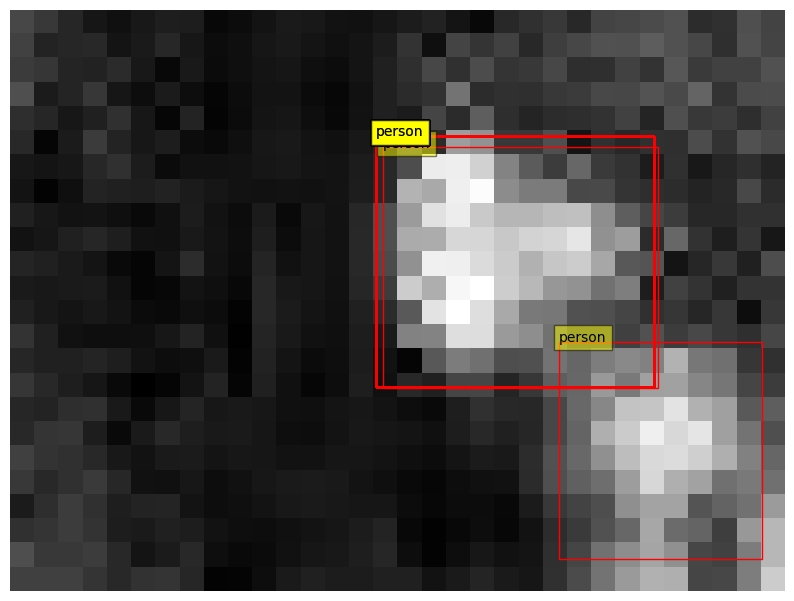

[[ 1.2758716e+01  4.3115616e-02  2.0884247e+01  8.1057148e+00
   1.1706393e+00]
 [-3.8781404e-02 -1.3890433e-01  7.6741114e+00  7.4622679e+00
   6.7219001e-01]
 [-1.2490749e-02 -1.9379067e-01  7.5199809e+00  7.5382032e+00
   5.6186259e-01]
 [-1.2490749e-02 -1.9379067e-01  7.5199809e+00  7.5382032e+00
   5.6186259e-01]
 [-1.2490749e-02 -1.9379067e-01  7.5199809e+00  7.5382032e+00
   5.6186259e-01]
 [-1.2490749e-02 -1.9379067e-01  7.5199809e+00  7.5382032e+00
   5.6186259e-01]
 [-1.2490749e-02 -1.9379067e-01  7.5199809e+00  7.5382032e+00
   5.6186259e-01]
 [-1.2490749e-02 -1.9379067e-01  7.5199809e+00  7.5382032e+00
   5.6186259e-01]
 [-1.2490749e-02 -1.9379067e-01  7.5199809e+00  7.5382032e+00
   5.6186259e-01]
 [-1.2490749e-02 -1.9379067e-01  7.5199809e+00  7.5382032e+00
   5.6186259e-01]
 [-1.2490749e-02 -1.9379067e-01  7.5199809e+00  7.5382032e+00
   5.6186259e-01]
 [-1.2490749e-02 -1.9379067e-01  7.5199809e+00  7.5382032e+00
   5.6186259e-01]
 [-1.2490749e-02 -1.9379067e-01  7.51998

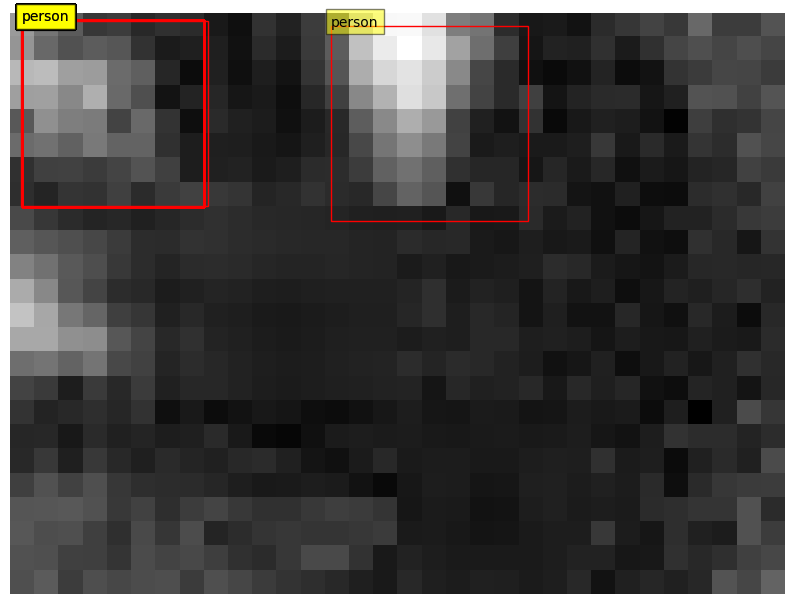

[[24.147264   12.953718   31.836618   21.213116    1.0191703 ]
 [24.050472   12.924315   31.838137   21.199902    0.71665764]
 [24.050472   12.924315   31.838137   21.199902    0.71665764]
 [24.050472   12.924315   31.838137   21.199902    0.71665764]
 [24.050472   12.924315   31.838137   21.199902    0.71665764]
 [24.050472   12.924315   31.838137   21.199902    0.71665764]
 [24.050472   12.924315   31.838137   21.199902    0.71665764]
 [24.050472   12.924315   31.838137   21.199902    0.71665764]
 [24.050472   12.924315   31.838137   21.199902    0.71665764]
 [24.050472   12.924315   31.838137   21.199902    0.71665764]
 [24.050472   12.924315   31.838137   21.199902    0.71665764]
 [24.050472   12.924315   31.838137   21.199902    0.71665764]
 [24.050472   12.924315   31.838137   21.199902    0.71665764]
 [24.050472   12.924315   31.838137   21.199902    0.71665764]
 [24.050472   12.924315   31.838137   21.199902    0.71665764]
 [24.050472   12.924315   31.838137   21.199902    0.71

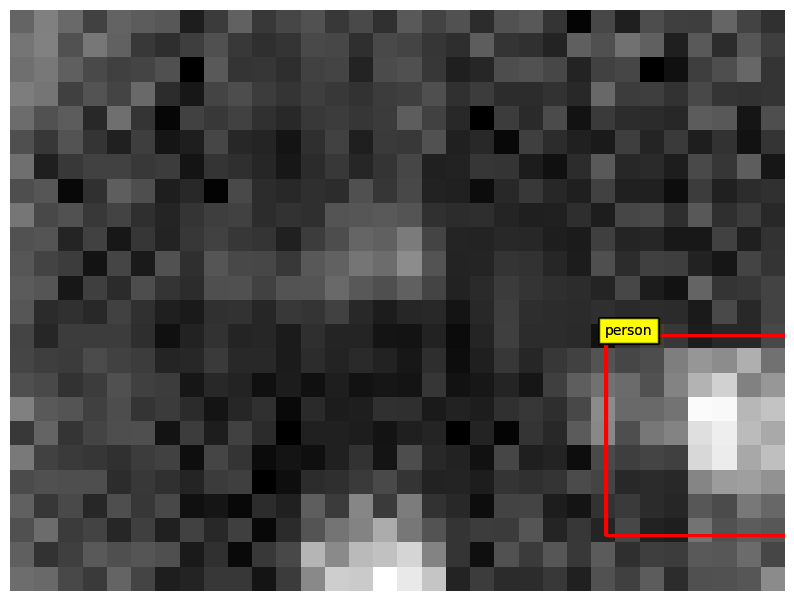

[[ 3.6588721  -0.05916691 13.226208    8.248604    1.0627508 ]
 [23.226288    6.31537    32.010986   14.177256    1.0171618 ]
 [ 3.5996714   0.04852676 13.268603    8.297102    0.8121643 ]
 [ 3.5996714   0.04852676 13.268603    8.297102    0.8121643 ]
 [ 3.5996714   0.04852676 13.268603    8.297102    0.8121643 ]
 [ 3.5996714   0.04852676 13.268603    8.297102    0.8121643 ]
 [ 3.5996714   0.04852676 13.268603    8.297102    0.8121643 ]
 [ 3.5996714   0.04852676 13.268603    8.297102    0.8121643 ]
 [ 3.5996714   0.04852676 13.268603    8.297102    0.8121643 ]
 [ 3.5996714   0.04852676 13.268603    8.297102    0.8121643 ]
 [ 3.5996714   0.04852676 13.268603    8.297102    0.8121643 ]
 [ 3.5996714   0.04852676 13.268603    8.297102    0.8121643 ]
 [ 3.5996714   0.04852676 13.268603    8.297102    0.8121643 ]
 [ 3.5996714   0.04852676 13.268603    8.297102    0.8121643 ]
 [ 3.5996714   0.04852676 13.268603    8.297102    0.8121643 ]
 [ 3.5996714   0.04852676 13.268603    8.297102    0.81

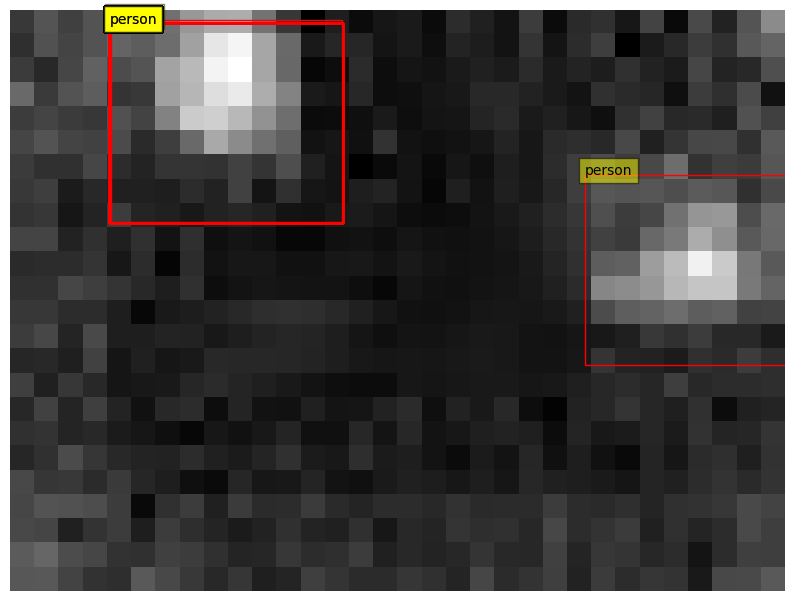

[[25.259705   17.220171   32.004562   24.156258    0.84819174]
 [25.471226   17.775433   31.90718    24.402939    0.52791834]
 [25.471226   17.775433   31.90718    24.402939    0.52791834]
 [25.471226   17.775433   31.90718    24.402939    0.52791834]
 [25.471226   17.775433   31.90718    24.402939    0.52791834]
 [25.471226   17.775433   31.90718    24.402939    0.52791834]
 [25.471226   17.775433   31.90718    24.402939    0.52791834]
 [25.471226   17.775433   31.90718    24.402939    0.52791834]
 [25.471226   17.775433   31.90718    24.402939    0.52791834]
 [25.471226   17.775433   31.90718    24.402939    0.52791834]
 [25.471226   17.775433   31.90718    24.402939    0.52791834]
 [25.471226   17.775433   31.90718    24.402939    0.52791834]
 [25.471226   17.775433   31.90718    24.402939    0.52791834]
 [25.471226   17.775433   31.90718    24.402939    0.52791834]
 [25.471226   17.775433   31.90718    24.402939    0.52791834]
 [25.471226   17.775433   31.90718    24.402939    0.52

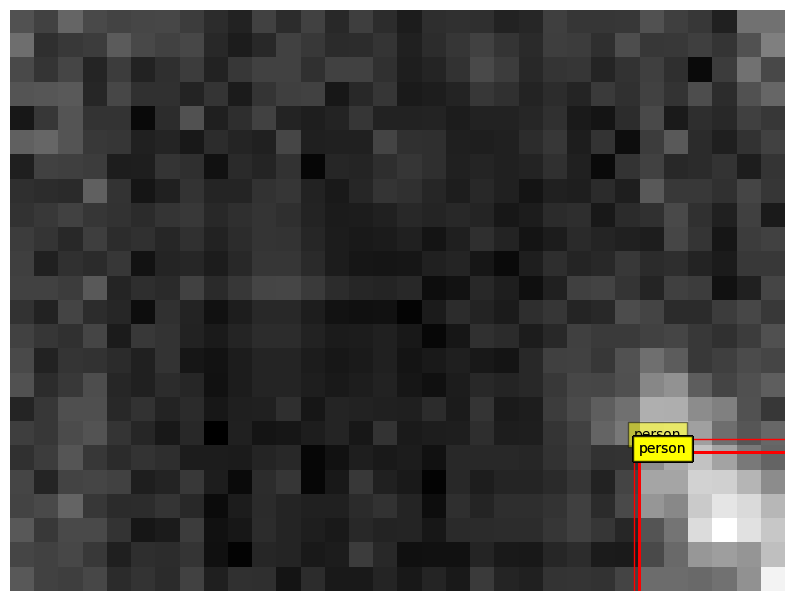

[[19.727623    5.295143   26.829767   12.687056    0.84847945]
 [22.23816     6.3799295  29.790812   12.905772    0.5683112 ]
 [19.07155     0.08271742 26.313145    5.290426    0.5494931 ]
 [19.756792    5.2710056  26.71154    12.608795    0.7014157 ]
 [19.756792    5.2710056  26.71154    12.608795    0.7014157 ]
 [19.756792    5.2710056  26.71154    12.608795    0.7014157 ]
 [19.756792    5.2710056  26.71154    12.608795    0.7014157 ]
 [19.756792    5.2710056  26.71154    12.608795    0.7014157 ]
 [19.756792    5.2710056  26.71154    12.608795    0.7014157 ]
 [19.756792    5.2710056  26.71154    12.608795    0.7014157 ]
 [19.756792    5.2710056  26.71154    12.608795    0.7014157 ]
 [19.756792    5.2710056  26.71154    12.608795    0.7014157 ]
 [19.756792    5.2710056  26.71154    12.608795    0.7014157 ]
 [19.756792    5.2710056  26.71154    12.608795    0.7014157 ]
 [19.756792    5.2710056  26.71154    12.608795    0.7014157 ]
 [19.756792    5.2710056  26.71154    12.608795    0.70

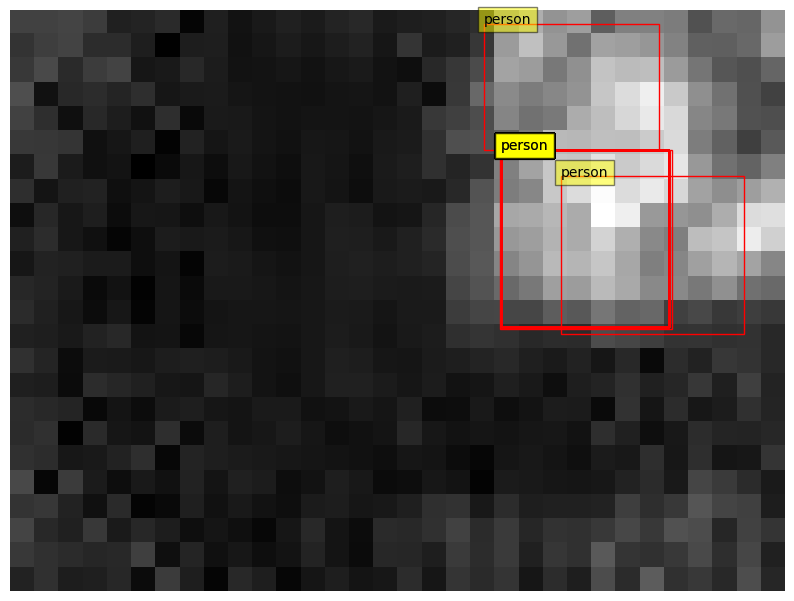

[[1.7395973e-02 4.8558202e+00 8.3994875e+00 1.3132669e+01 8.9909619e-01]
 [1.8186857e+01 2.5763125e+00 2.6557547e+01 1.6481833e+01 5.7458019e-01]
 [6.3349247e-02 4.8742280e+00 8.2588902e+00 1.3175259e+01 6.3808453e-01]
 [6.3349247e-02 4.8742280e+00 8.2588902e+00 1.3175259e+01 6.3808453e-01]
 [6.3349247e-02 4.8742280e+00 8.2588902e+00 1.3175259e+01 6.3808453e-01]
 [6.3349247e-02 4.8742280e+00 8.2588902e+00 1.3175259e+01 6.3808453e-01]
 [6.3349247e-02 4.8742280e+00 8.2588902e+00 1.3175259e+01 6.3808453e-01]
 [6.3349247e-02 4.8742280e+00 8.2588902e+00 1.3175259e+01 6.3808453e-01]
 [6.3349247e-02 4.8742280e+00 8.2588902e+00 1.3175259e+01 6.3808453e-01]
 [6.3349247e-02 4.8742280e+00 8.2588902e+00 1.3175259e+01 6.3808453e-01]
 [6.3349247e-02 4.8742280e+00 8.2588902e+00 1.3175259e+01 6.3808453e-01]
 [6.3349247e-02 4.8742280e+00 8.2588902e+00 1.3175259e+01 6.3808453e-01]
 [6.3349247e-02 4.8742280e+00 8.2588902e+00 1.3175259e+01 6.3808453e-01]
 [6.3349247e-02 4.8742280e+00 8.2588902e+00 1.31752

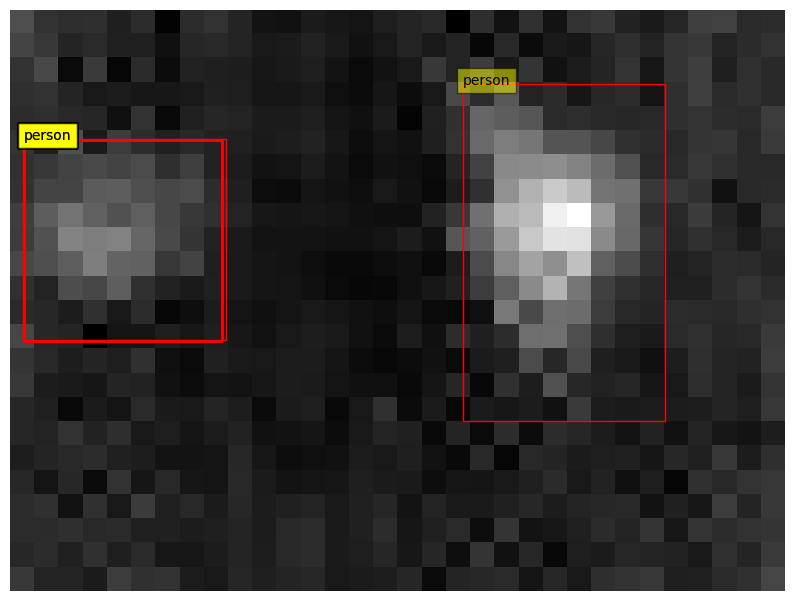

[[23.327726    5.360607   32.085392   12.094027    0.93245476]
 [24.874012   -0.12767005 32.008617    5.743537    0.66205084]
 [24.874012   -0.12767005 32.008617    5.743537    0.66205084]
 [24.874012   -0.12767005 32.008617    5.743537    0.66205084]
 [24.874012   -0.12767005 32.008617    5.743537    0.66205084]
 [24.874012   -0.12767005 32.008617    5.743537    0.66205084]
 [24.874012   -0.12767005 32.008617    5.743537    0.66205084]
 [24.874012   -0.12767005 32.008617    5.743537    0.66205084]
 [24.874012   -0.12767005 32.008617    5.743537    0.66205084]
 [24.874012   -0.12767005 32.008617    5.743537    0.66205084]
 [24.874012   -0.12767005 32.008617    5.743537    0.66205084]
 [24.874012   -0.12767005 32.008617    5.743537    0.66205084]
 [24.874012   -0.12767005 32.008617    5.743537    0.66205084]
 [24.874012   -0.12767005 32.008617    5.743537    0.66205084]
 [24.874012   -0.12767005 32.008617    5.743537    0.66205084]
 [24.874012   -0.12767005 32.008617    5.743537    0.66

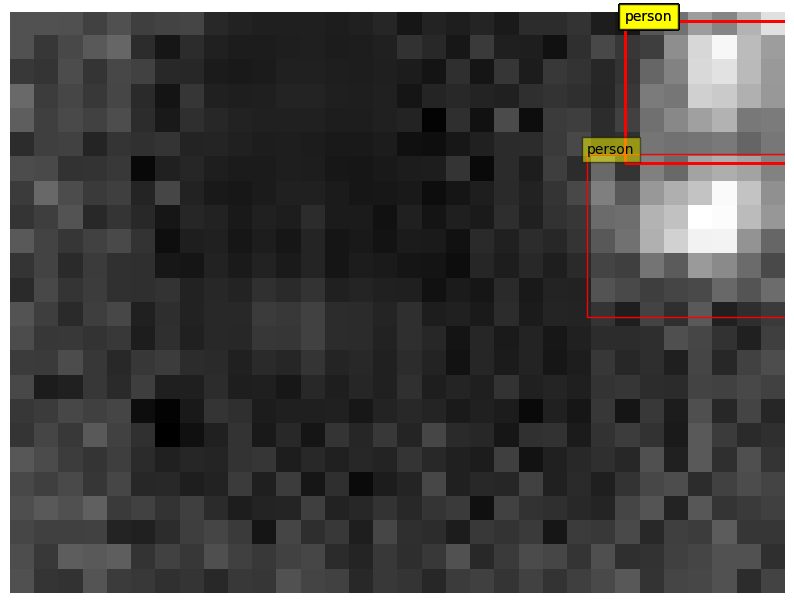

[[ 5.877544    0.31704617 14.663729    9.793091    0.9822948 ]
 [ 5.8983636   0.313457   14.407246    9.780392    0.64987564]
 [ 5.8983636   0.313457   14.407246    9.780392    0.64987564]
 [ 5.8983636   0.313457   14.407246    9.780392    0.64987564]
 [ 5.8983636   0.313457   14.407246    9.780392    0.64987564]
 [ 5.8983636   0.313457   14.407246    9.780392    0.64987564]
 [ 5.8983636   0.313457   14.407246    9.780392    0.64987564]
 [ 5.8983636   0.313457   14.407246    9.780392    0.64987564]
 [ 5.8983636   0.313457   14.407246    9.780392    0.64987564]
 [ 5.8983636   0.313457   14.407246    9.780392    0.64987564]
 [ 5.8983636   0.313457   14.407246    9.780392    0.64987564]
 [ 5.8983636   0.313457   14.407246    9.780392    0.64987564]
 [ 5.8983636   0.313457   14.407246    9.780392    0.64987564]
 [ 5.8983636   0.313457   14.407246    9.780392    0.64987564]
 [ 5.8983636   0.313457   14.407246    9.780392    0.64987564]
 [ 5.8983636   0.313457   14.407246    9.780392    0.64

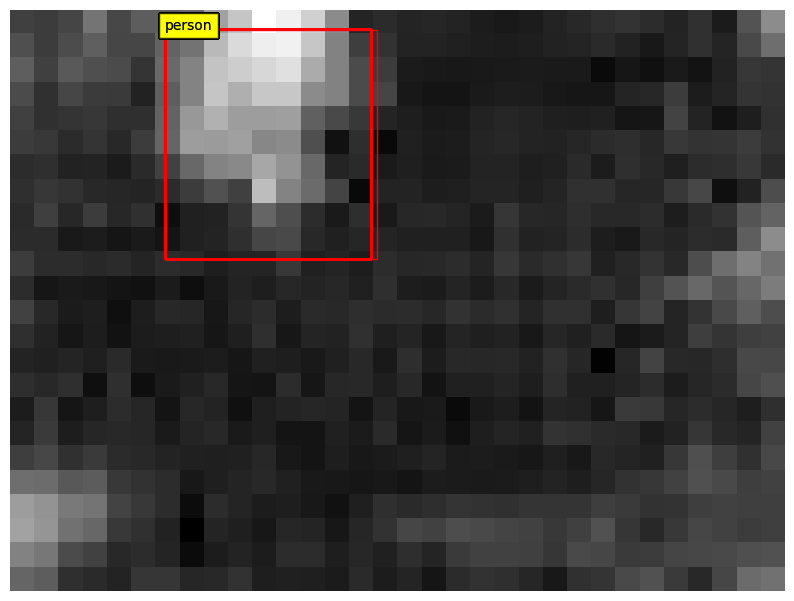

[[23.928276    8.123676   32.13057    16.91718     1.0414702 ]
 [24.372126   -0.08499861 31.858715    8.350435    0.8451497 ]
 [24.249657   -0.08704472 32.042816    8.194098    0.55895656]
 [24.249657   -0.08704472 32.042816    8.194098    0.55895656]
 [24.249657   -0.08704472 32.042816    8.194098    0.55895656]
 [24.249657   -0.08704472 32.042816    8.194098    0.55895656]
 [24.249657   -0.08704472 32.042816    8.194098    0.55895656]
 [24.249657   -0.08704472 32.042816    8.194098    0.55895656]
 [24.249657   -0.08704472 32.042816    8.194098    0.55895656]
 [24.249657   -0.08704472 32.042816    8.194098    0.55895656]
 [24.249657   -0.08704472 32.042816    8.194098    0.55895656]
 [24.249657   -0.08704472 32.042816    8.194098    0.55895656]
 [24.249657   -0.08704472 32.042816    8.194098    0.55895656]
 [24.249657   -0.08704472 32.042816    8.194098    0.55895656]
 [24.249657   -0.08704472 32.042816    8.194098    0.55895656]
 [24.249657   -0.08704472 32.042816    8.194098    0.55

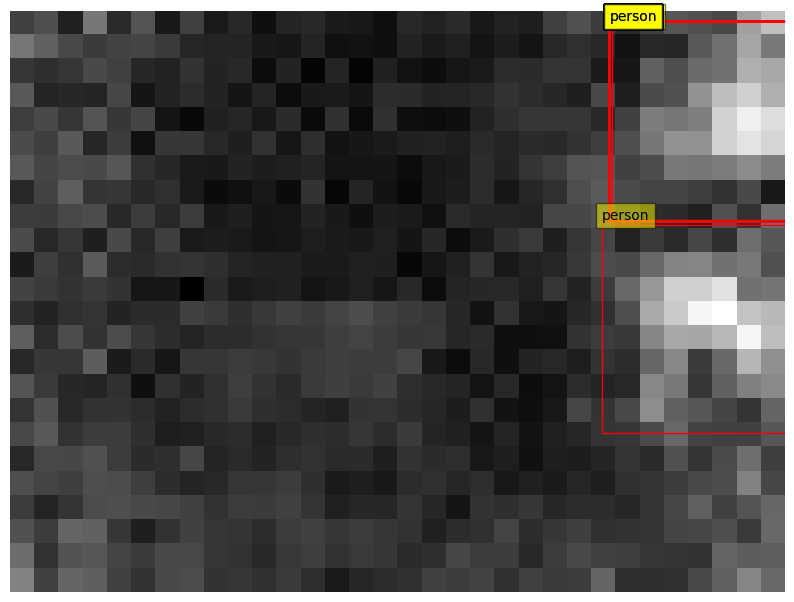

[[16.202011    6.055535   27.09947    14.706453    1.0362461 ]
 [-0.04002476 15.933277    8.097791   24.072914    0.68366814]
 [15.810822    5.8908186  27.523006   13.960267    0.9113654 ]
 [15.810822    5.8908186  27.523006   13.960267    0.9113654 ]
 [15.810822    5.8908186  27.523006   13.960267    0.9113654 ]
 [15.810822    5.8908186  27.523006   13.960267    0.9113654 ]
 [15.810822    5.8908186  27.523006   13.960267    0.9113654 ]
 [15.810822    5.8908186  27.523006   13.960267    0.9113654 ]
 [15.810822    5.8908186  27.523006   13.960267    0.9113654 ]
 [15.810822    5.8908186  27.523006   13.960267    0.9113654 ]
 [15.810822    5.8908186  27.523006   13.960267    0.9113654 ]
 [15.810822    5.8908186  27.523006   13.960267    0.9113654 ]
 [15.810822    5.8908186  27.523006   13.960267    0.9113654 ]
 [15.810822    5.8908186  27.523006   13.960267    0.9113654 ]
 [15.810822    5.8908186  27.523006   13.960267    0.9113654 ]
 [15.810822    5.8908186  27.523006   13.960267    0.91

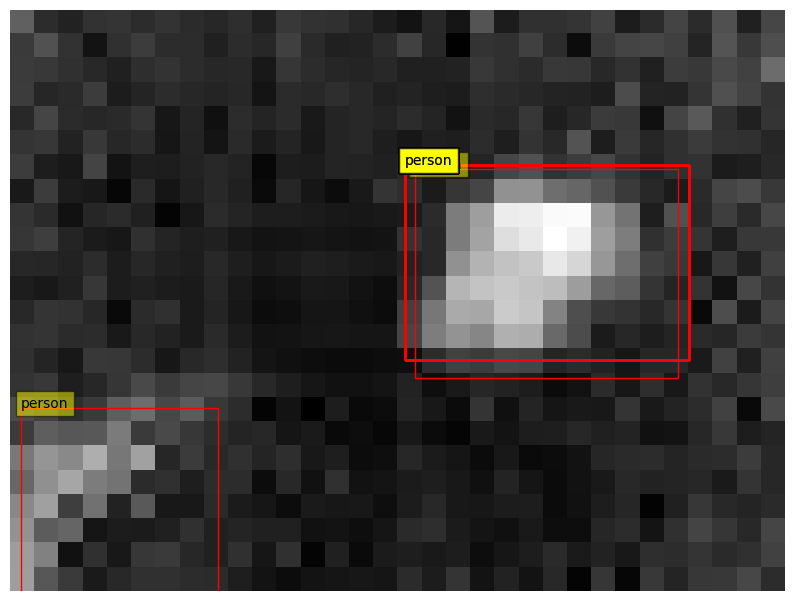

[[ 5.898514    6.4356136  14.36521    13.445482    1.2000759 ]
 [ 0.5488696   2.5433226   8.620888   10.979329    1.0734241 ]
 [ 2.6452718   5.1442842  11.305223   12.251103    0.51364696]
 [ 0.71480465  2.485529    8.494773   11.071675    0.51293457]
 [ 0.71480465  2.485529    8.494773   11.071675    0.51293457]
 [ 0.71480465  2.485529    8.494773   11.071675    0.51293457]
 [ 0.71480465  2.485529    8.494773   11.071675    0.51293457]
 [ 0.71480465  2.485529    8.494773   11.071675    0.51293457]
 [ 0.71480465  2.485529    8.494773   11.071675    0.51293457]
 [ 0.71480465  2.485529    8.494773   11.071675    0.51293457]
 [ 0.71480465  2.485529    8.494773   11.071675    0.51293457]
 [ 0.71480465  2.485529    8.494773   11.071675    0.51293457]
 [ 0.71480465  2.485529    8.494773   11.071675    0.51293457]
 [ 0.71480465  2.485529    8.494773   11.071675    0.51293457]
 [ 0.71480465  2.485529    8.494773   11.071675    0.51293457]
 [ 0.71480465  2.485529    8.494773   11.071675    0.51

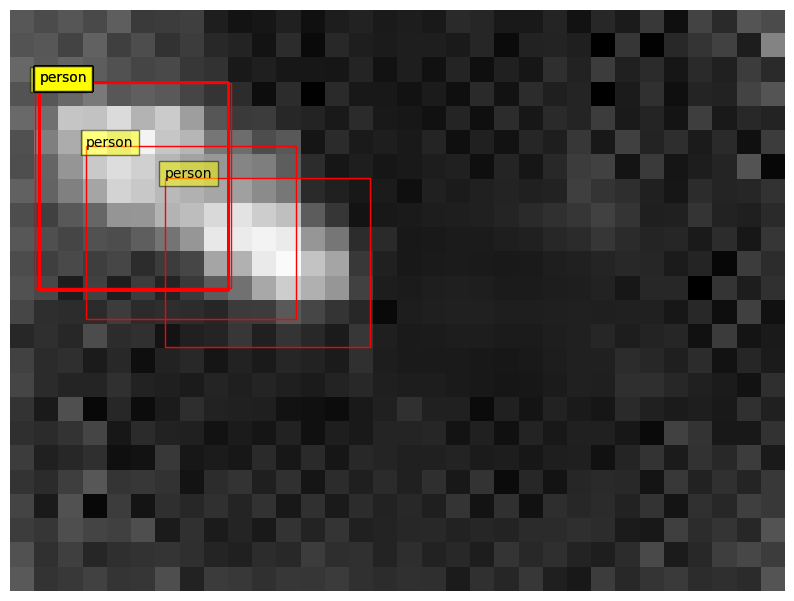

[[14.049916    4.841378   23.905907   14.211738    1.1800156 ]
 [ 7.815169   14.955208   15.845585   23.997196    1.114536  ]
 [ 0.12596464 12.952902    8.760174   23.384754    1.0074174 ]
 [13.949091    4.8391037  23.686438   14.132559    0.7707089 ]
 [13.949091    4.8391037  23.686438   14.132559    0.7707089 ]
 [13.949091    4.8391037  23.686438   14.132559    0.7707089 ]
 [13.949091    4.8391037  23.686438   14.132559    0.7707089 ]
 [13.949091    4.8391037  23.686438   14.132559    0.7707089 ]
 [13.949091    4.8391037  23.686438   14.132559    0.7707089 ]
 [13.949091    4.8391037  23.686438   14.132559    0.7707089 ]
 [13.949091    4.8391037  23.686438   14.132559    0.7707089 ]
 [13.949091    4.8391037  23.686438   14.132559    0.7707089 ]
 [13.949091    4.8391037  23.686438   14.132559    0.7707089 ]
 [13.949091    4.8391037  23.686438   14.132559    0.7707089 ]
 [13.949091    4.8391037  23.686438   14.132559    0.7707089 ]
 [13.949091    4.8391037  23.686438   14.132559    0.77

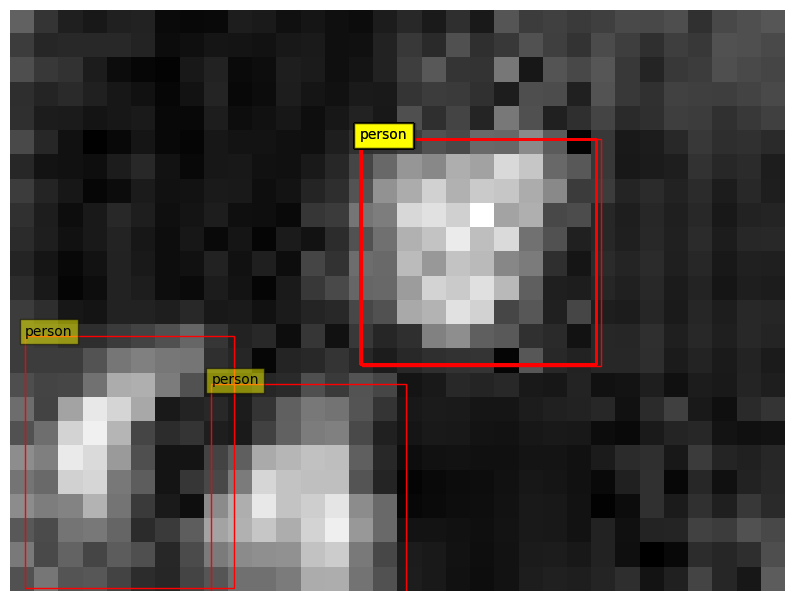

[[21.870707   14.736547   32.10092    23.845736    1.1608614 ]
 [10.093972   10.948593   20.171677   23.861656    0.9535986 ]
 [25.011318    8.413637   31.929482   14.883242    0.53909636]
 [25.011318    8.413637   31.929482   14.883242    0.53909636]
 [25.011318    8.413637   31.929482   14.883242    0.53909636]
 [25.011318    8.413637   31.929482   14.883242    0.53909636]
 [25.011318    8.413637   31.929482   14.883242    0.53909636]
 [25.011318    8.413637   31.929482   14.883242    0.53909636]
 [25.011318    8.413637   31.929482   14.883242    0.53909636]
 [25.011318    8.413637   31.929482   14.883242    0.53909636]
 [25.011318    8.413637   31.929482   14.883242    0.53909636]
 [25.011318    8.413637   31.929482   14.883242    0.53909636]
 [25.011318    8.413637   31.929482   14.883242    0.53909636]
 [25.011318    8.413637   31.929482   14.883242    0.53909636]
 [25.011318    8.413637   31.929482   14.883242    0.53909636]
 [25.011318    8.413637   31.929482   14.883242    0.53

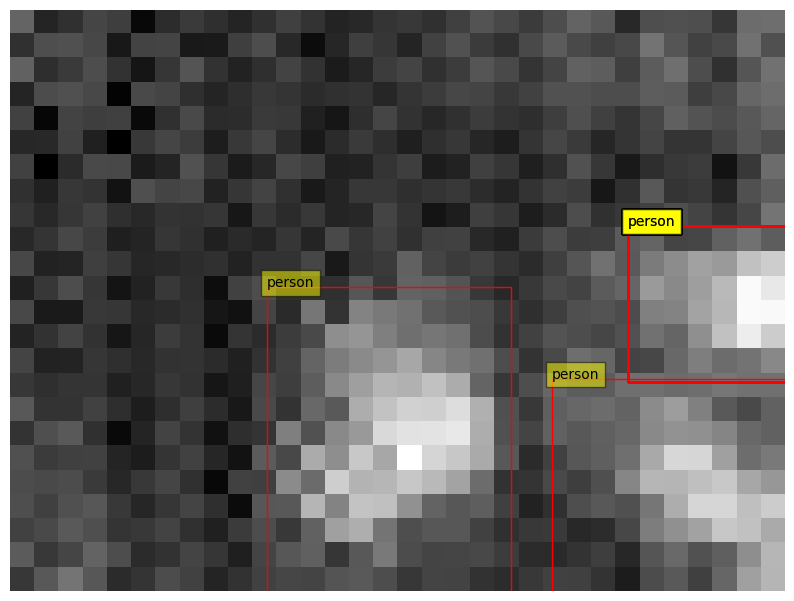

[[13.740641  10.585757  22.4393    19.011108   1.1616733]
 [13.923555  10.711401  22.427809  18.558496   0.5127282]
 [13.923555  10.711401  22.427809  18.558496   0.5127282]
 [13.923555  10.711401  22.427809  18.558496   0.5127282]
 [13.923555  10.711401  22.427809  18.558496   0.5127282]
 [13.923555  10.711401  22.427809  18.558496   0.5127282]
 [13.923555  10.711401  22.427809  18.558496   0.5127282]
 [13.923555  10.711401  22.427809  18.558496   0.5127282]
 [13.923555  10.711401  22.427809  18.558496   0.5127282]
 [13.923555  10.711401  22.427809  18.558496   0.5127282]
 [13.923555  10.711401  22.427809  18.558496   0.5127282]
 [13.923555  10.711401  22.427809  18.558496   0.5127282]
 [13.923555  10.711401  22.427809  18.558496   0.5127282]
 [13.923555  10.711401  22.427809  18.558496   0.5127282]
 [13.923555  10.711401  22.427809  18.558496   0.5127282]
 [13.923555  10.711401  22.427809  18.558496   0.5127282]
 [13.923555  10.711401  22.427809  18.558496   0.5127282]
 [13.923555  1

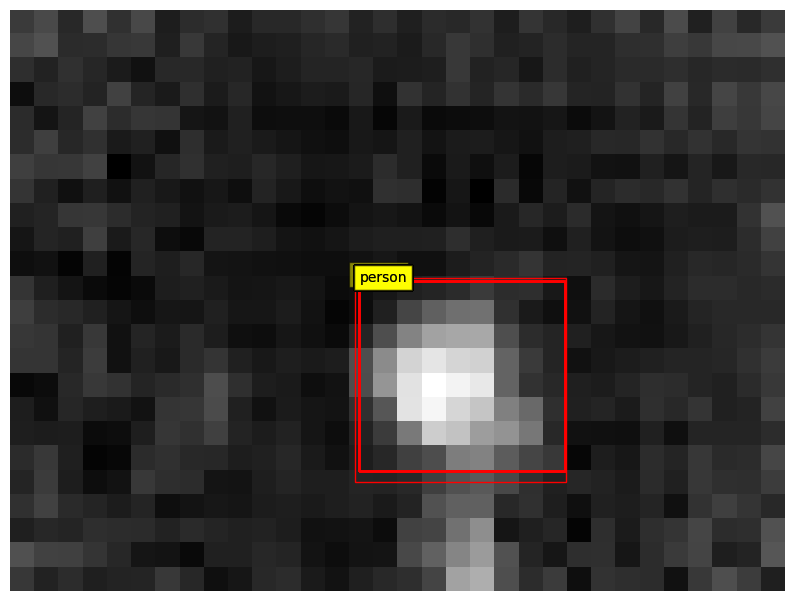

[[ 9.2404175   7.957587   19.184734   19.716602    1.0573335 ]
 [ 1.9141905  10.801987    9.854034   18.9537      0.93279225]
 [ 9.538334    7.9467626  19.013826   19.77481     0.9321519 ]
 [ 9.538334    7.9467626  19.013826   19.77481     0.9321519 ]
 [ 9.538334    7.9467626  19.013826   19.77481     0.9321519 ]
 [ 9.538334    7.9467626  19.013826   19.77481     0.9321519 ]
 [ 9.538334    7.9467626  19.013826   19.77481     0.9321519 ]
 [ 9.538334    7.9467626  19.013826   19.77481     0.9321519 ]
 [ 9.538334    7.9467626  19.013826   19.77481     0.9321519 ]
 [ 9.538334    7.9467626  19.013826   19.77481     0.9321519 ]
 [ 9.538334    7.9467626  19.013826   19.77481     0.9321519 ]
 [ 9.538334    7.9467626  19.013826   19.77481     0.9321519 ]
 [ 9.538334    7.9467626  19.013826   19.77481     0.9321519 ]
 [ 9.538334    7.9467626  19.013826   19.77481     0.9321519 ]
 [ 9.538334    7.9467626  19.013826   19.77481     0.9321519 ]
 [ 9.538334    7.9467626  19.013826   19.77481     0.93

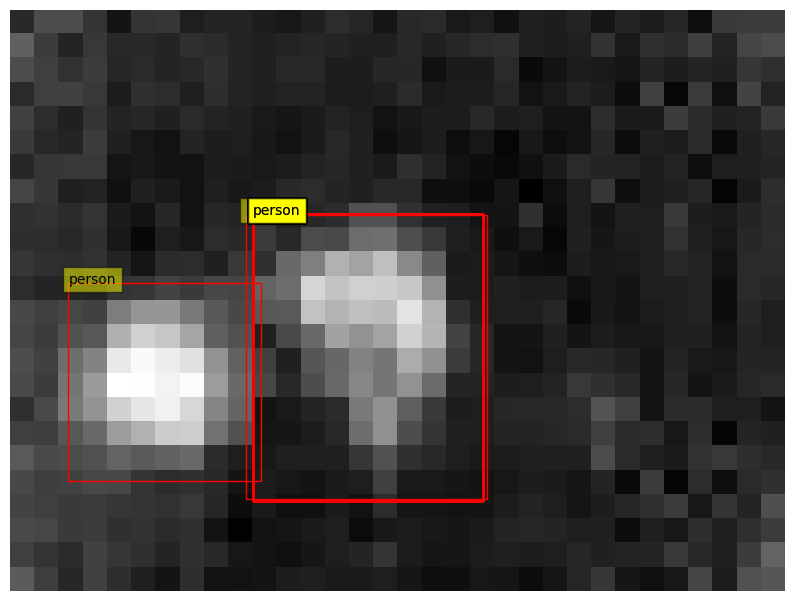

[[ 6.92301607e+00  1.16505919e+01  1.63919792e+01  2.21401749e+01
   1.19037735e+00]
 [ 7.69145489e+00  4.73016644e+00  1.67212639e+01  1.16370735e+01
   8.43826830e-01]
 [ 6.75483990e+00 -1.14973783e-01  1.61059303e+01  5.78555584e+00
   8.25282931e-01]
 [ 6.73960018e+00 -2.15961933e-02  1.61535606e+01  5.76618481e+00
   7.30095804e-01]
 [ 6.73960018e+00 -2.15961933e-02  1.61535606e+01  5.76618481e+00
   7.30095804e-01]
 [ 6.73960018e+00 -2.15961933e-02  1.61535606e+01  5.76618481e+00
   7.30095804e-01]
 [ 6.73960018e+00 -2.15961933e-02  1.61535606e+01  5.76618481e+00
   7.30095804e-01]
 [ 6.73960018e+00 -2.15961933e-02  1.61535606e+01  5.76618481e+00
   7.30095804e-01]
 [ 6.73960018e+00 -2.15961933e-02  1.61535606e+01  5.76618481e+00
   7.30095804e-01]
 [ 6.73960018e+00 -2.15961933e-02  1.61535606e+01  5.76618481e+00
   7.30095804e-01]
 [ 6.73960018e+00 -2.15961933e-02  1.61535606e+01  5.76618481e+00
   7.30095804e-01]
 [ 6.73960018e+00 -2.15961933e-02  1.61535606e+01  5.76618481e+00

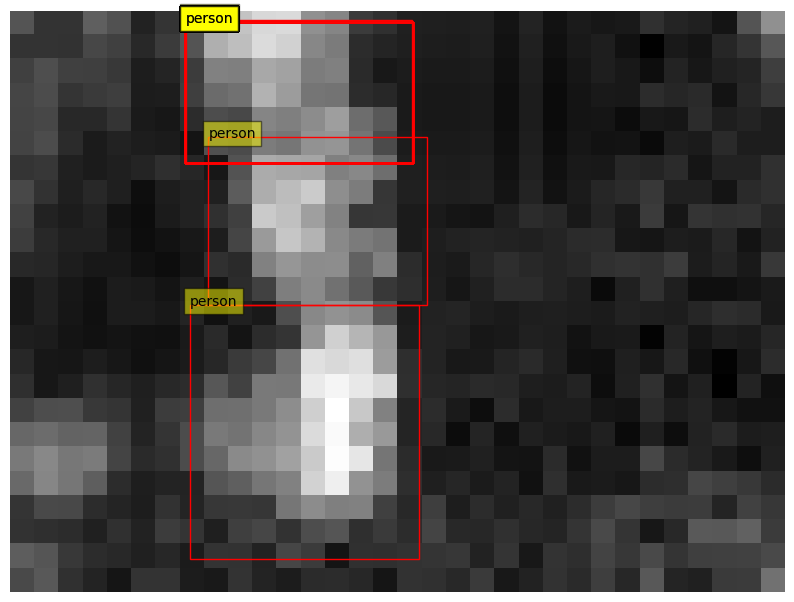

[[-0.07051516 11.8553915   9.209433   18.766575    0.9719454 ]
 [ 0.06114388 17.478224    5.7094984  24.121244    0.5097597 ]
 [-0.04611397 12.0384245   9.248259   18.843304    0.71148485]
 [-0.04611397 12.0384245   9.248259   18.843304    0.71148485]
 [-0.04611397 12.0384245   9.248259   18.843304    0.71148485]
 [-0.04611397 12.0384245   9.248259   18.843304    0.71148485]
 [-0.04611397 12.0384245   9.248259   18.843304    0.71148485]
 [-0.04611397 12.0384245   9.248259   18.843304    0.71148485]
 [-0.04611397 12.0384245   9.248259   18.843304    0.71148485]
 [-0.04611397 12.0384245   9.248259   18.843304    0.71148485]
 [-0.04611397 12.0384245   9.248259   18.843304    0.71148485]
 [-0.04611397 12.0384245   9.248259   18.843304    0.71148485]
 [-0.04611397 12.0384245   9.248259   18.843304    0.71148485]
 [-0.04611397 12.0384245   9.248259   18.843304    0.71148485]
 [-0.04611397 12.0384245   9.248259   18.843304    0.71148485]
 [-0.04611397 12.0384245   9.248259   18.843304    0.71

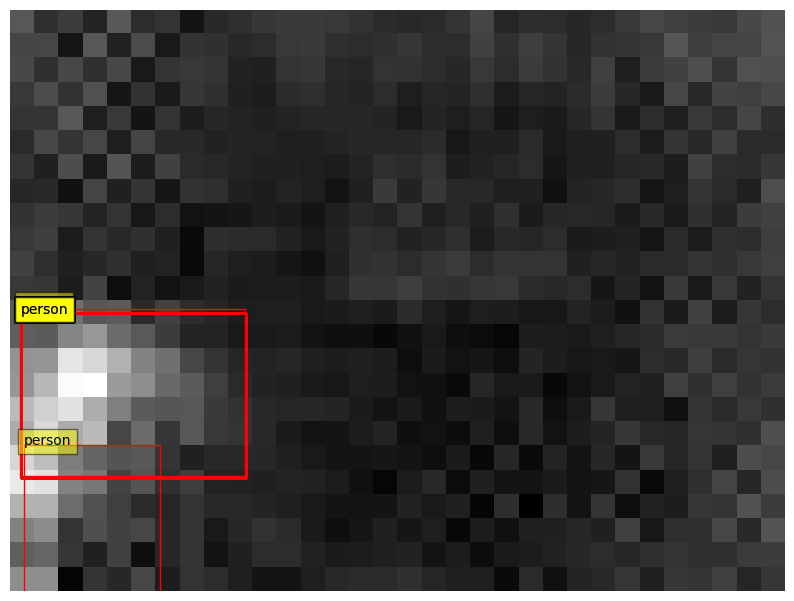

[[-6.7582130e-02  1.1897854e+01  8.9759712e+00  1.8879688e+01
   9.1085786e-01]
 [-7.8813314e-02  1.9257835e+01  7.2696714e+00  2.4110092e+01
   6.5165102e-01]
 [ 2.1530151e-02  1.1936238e+01  9.0881290e+00  1.8889729e+01
   6.1857039e-01]
 [ 2.1530151e-02  1.1936238e+01  9.0881290e+00  1.8889729e+01
   6.1857039e-01]
 [ 2.1530151e-02  1.1936238e+01  9.0881290e+00  1.8889729e+01
   6.1857039e-01]
 [ 2.1530151e-02  1.1936238e+01  9.0881290e+00  1.8889729e+01
   6.1857039e-01]
 [ 2.1530151e-02  1.1936238e+01  9.0881290e+00  1.8889729e+01
   6.1857039e-01]
 [ 2.1530151e-02  1.1936238e+01  9.0881290e+00  1.8889729e+01
   6.1857039e-01]
 [ 2.1530151e-02  1.1936238e+01  9.0881290e+00  1.8889729e+01
   6.1857039e-01]
 [ 2.1530151e-02  1.1936238e+01  9.0881290e+00  1.8889729e+01
   6.1857039e-01]
 [ 2.1530151e-02  1.1936238e+01  9.0881290e+00  1.8889729e+01
   6.1857039e-01]
 [ 2.1530151e-02  1.1936238e+01  9.0881290e+00  1.8889729e+01
   6.1857039e-01]
 [ 2.1530151e-02  1.1936238e+01  9.08812

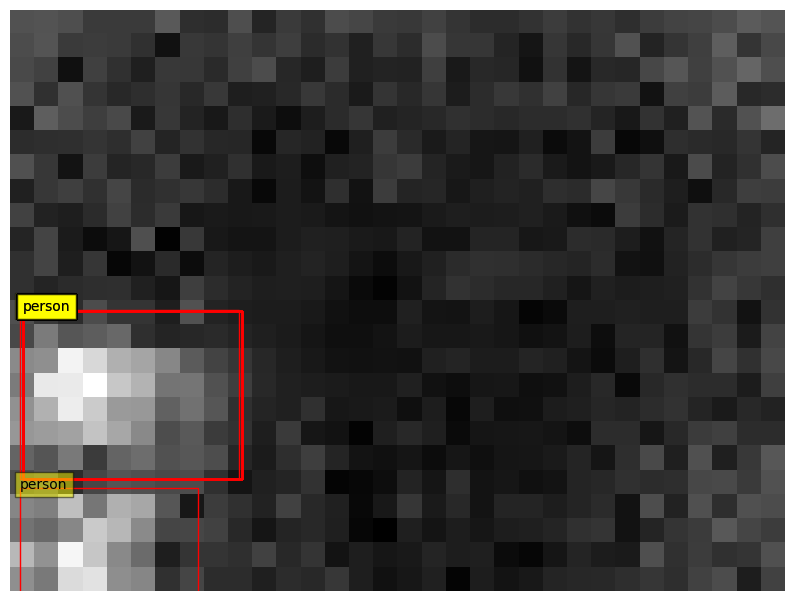

[[-0.08261824  8.502279    8.829712   16.87433     0.9288163 ]
 [15.227584   18.928772   21.62901    23.969011    0.58444095]
 [-0.03989124  8.415763    8.626325   16.949799    0.6282016 ]
 [-0.03989124  8.415763    8.626325   16.949799    0.6282016 ]
 [-0.03989124  8.415763    8.626325   16.949799    0.6282016 ]
 [-0.03989124  8.415763    8.626325   16.949799    0.6282016 ]
 [-0.03989124  8.415763    8.626325   16.949799    0.6282016 ]
 [-0.03989124  8.415763    8.626325   16.949799    0.6282016 ]
 [-0.03989124  8.415763    8.626325   16.949799    0.6282016 ]
 [-0.03989124  8.415763    8.626325   16.949799    0.6282016 ]
 [-0.03989124  8.415763    8.626325   16.949799    0.6282016 ]
 [-0.03989124  8.415763    8.626325   16.949799    0.6282016 ]
 [-0.03989124  8.415763    8.626325   16.949799    0.6282016 ]
 [-0.03989124  8.415763    8.626325   16.949799    0.6282016 ]
 [-0.03989124  8.415763    8.626325   16.949799    0.6282016 ]
 [-0.03989124  8.415763    8.626325   16.949799    0.62

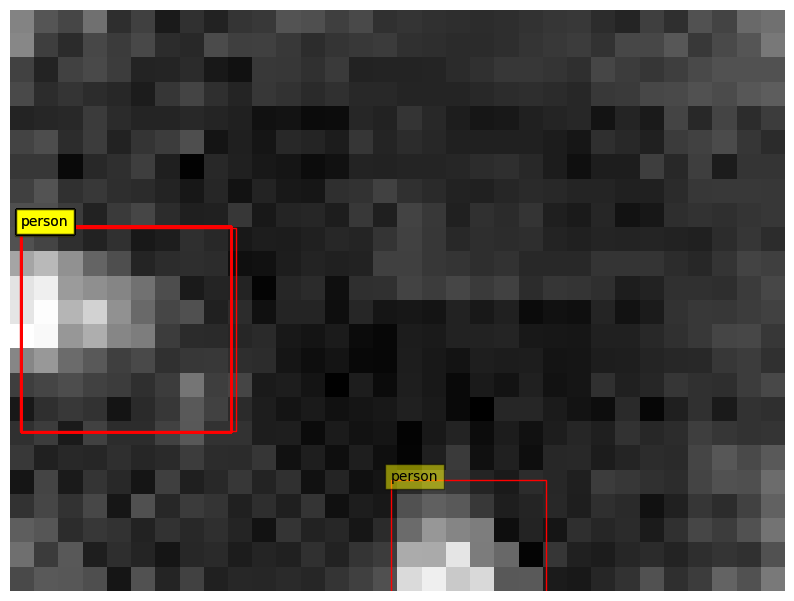

[[13.300091    3.9884548  22.262112   12.552523    1.160287  ]
 [21.42404     3.0705318  30.924662    9.910882    0.92711955]
 [ 7.1504474  -0.03755116 13.85969     7.172017    0.88861185]
 [ 7.174351   -0.03838205 13.818813    7.0622826   0.6947542 ]
 [ 7.174351   -0.03838205 13.818813    7.0622826   0.6947542 ]
 [ 7.174351   -0.03838205 13.818813    7.0622826   0.6947542 ]
 [ 7.174351   -0.03838205 13.818813    7.0622826   0.6947542 ]
 [ 7.174351   -0.03838205 13.818813    7.0622826   0.6947542 ]
 [ 7.174351   -0.03838205 13.818813    7.0622826   0.6947542 ]
 [ 7.174351   -0.03838205 13.818813    7.0622826   0.6947542 ]
 [ 7.174351   -0.03838205 13.818813    7.0622826   0.6947542 ]
 [ 7.174351   -0.03838205 13.818813    7.0622826   0.6947542 ]
 [ 7.174351   -0.03838205 13.818813    7.0622826   0.6947542 ]
 [ 7.174351   -0.03838205 13.818813    7.0622826   0.6947542 ]
 [ 7.174351   -0.03838205 13.818813    7.0622826   0.6947542 ]
 [ 7.174351   -0.03838205 13.818813    7.0622826   0.69

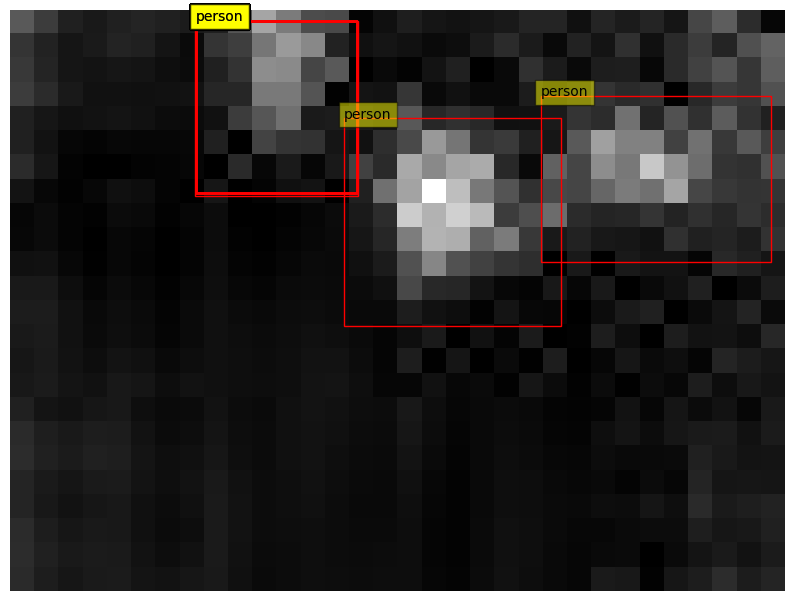

[[ 5.2578907  2.972019  12.674068  10.313613   0.5497305]
 [ 5.2578907  2.972019  12.674068  10.313613   0.5497305]
 [ 5.2578907  2.972019  12.674068  10.313613   0.5497305]
 [ 5.2578907  2.972019  12.674068  10.313613   0.5497305]
 [ 5.2578907  2.972019  12.674068  10.313613   0.5497305]
 [ 5.2578907  2.972019  12.674068  10.313613   0.5497305]
 [ 5.2578907  2.972019  12.674068  10.313613   0.5497305]
 [ 5.2578907  2.972019  12.674068  10.313613   0.5497305]
 [ 5.2578907  2.972019  12.674068  10.313613   0.5497305]
 [ 5.2578907  2.972019  12.674068  10.313613   0.5497305]
 [ 5.2578907  2.972019  12.674068  10.313613   0.5497305]
 [ 5.2578907  2.972019  12.674068  10.313613   0.5497305]
 [ 5.2578907  2.972019  12.674068  10.313613   0.5497305]
 [ 5.2578907  2.972019  12.674068  10.313613   0.5497305]
 [ 5.2578907  2.972019  12.674068  10.313613   0.5497305]
 [ 5.2578907  2.972019  12.674068  10.313613   0.5497305]
 [ 5.2578907  2.972019  12.674068  10.313613   0.5497305]
 [ 5.2578907  

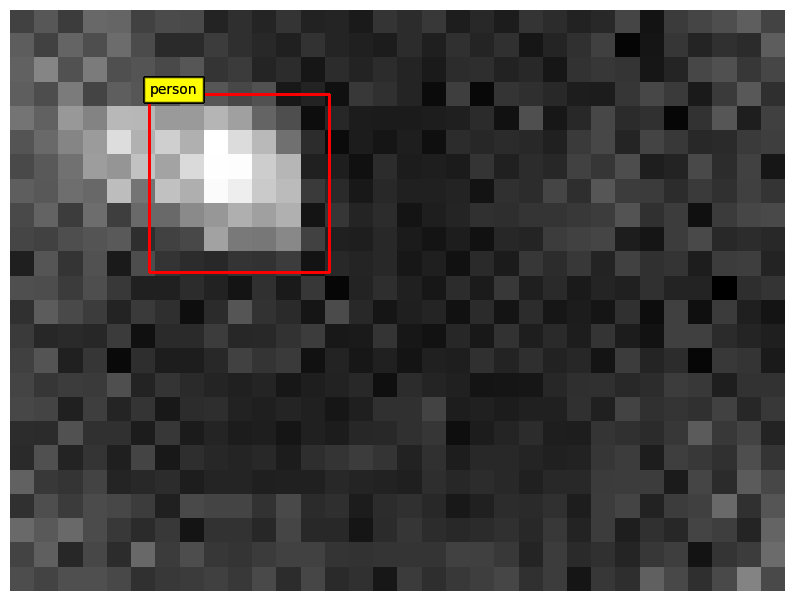

[[13.793203    5.469467   21.466957   14.117794    1.2784555 ]
 [14.964989    3.1470778  24.23655     9.905117    0.8534246 ]
 [12.701887   18.629807   21.390575   24.217634    0.56180966]
 [15.19757     3.0622652  24.501259    9.934721    0.65033   ]
 [15.19757     3.0622652  24.501259    9.934721    0.65033   ]
 [15.19757     3.0622652  24.501259    9.934721    0.65033   ]
 [15.19757     3.0622652  24.501259    9.934721    0.65033   ]
 [15.19757     3.0622652  24.501259    9.934721    0.65033   ]
 [15.19757     3.0622652  24.501259    9.934721    0.65033   ]
 [15.19757     3.0622652  24.501259    9.934721    0.65033   ]
 [15.19757     3.0622652  24.501259    9.934721    0.65033   ]
 [15.19757     3.0622652  24.501259    9.934721    0.65033   ]
 [15.19757     3.0622652  24.501259    9.934721    0.65033   ]
 [15.19757     3.0622652  24.501259    9.934721    0.65033   ]
 [15.19757     3.0622652  24.501259    9.934721    0.65033   ]
 [15.19757     3.0622652  24.501259    9.934721    0.65

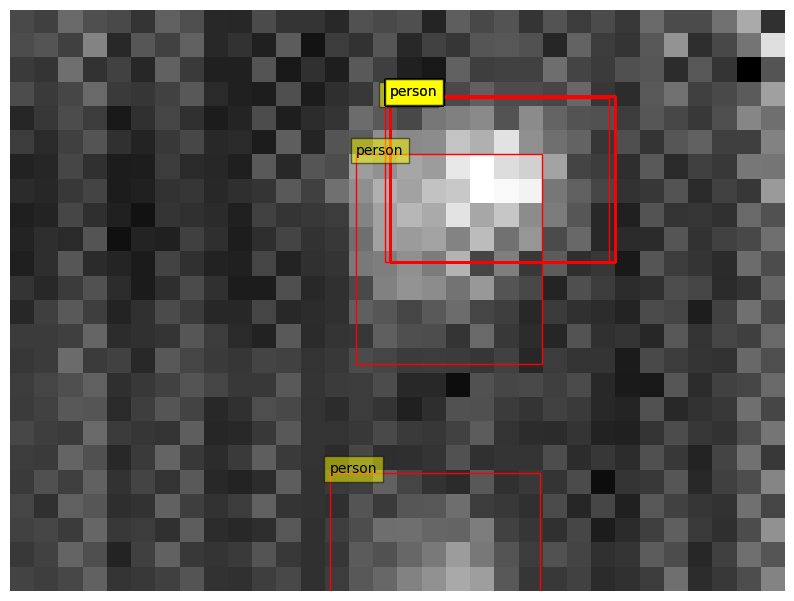

RuntimeError: gather index out of boundsNode number 344 (GATHER) failed to invoke.

In [ ]:
# TensorFlow Lite 모델 로드
tflite_model_path = 'ObjectDetection/tflite/model_v6_backup_plan.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

class_names = ['person']  # 클래스 이름 리스트

def draw_bounding_boxes(image, boxes, class_names):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')  # 이미지가 grayscale인 경우 cmap='gray'를 추가합니다.
    ax = plt.gca()
    for box in boxes:
        x_min, y_min, x_max, y_max, score = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # 박스 위에 클래스 이름과 확률 표시
        class_name = class_names[0]  # 예시로 'person' 클래스를 사용합니다.
        # text = f'{class_name}: {score / 4:.2f}'
        text = f'{class_name}'
        ax.text(x_min, y_min, text, fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()
    
for img, _, _ in val_dataset.take(50):
    # 입력 이미지 전처리
    input_data = tf.expand_dims(img[0], axis=0)
    input_data = input_data.numpy()
    
    # 모델 추론
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_details[0]['index'])
    print(predictions)
    predictions[:, -1]
    
    scores = predictions[:, -1]

    # scores가 0.5 이상인 인덱스를 찾습니다.
    indices = tf.where(scores >= 0.5)

    # 해당 인덱스에 해당하는 predictions만 필터링합니다.
    filtered_predictions = tf.gather(predictions, indices[:, 0])

    # 결과 후처리 및 시각화
    draw_bounding_boxes(img[0].numpy(), filtered_predictions, class_names)

In [ ]:
q! 이거 봐라 개쩔꺼다

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import tensorflow as tf

# import numpy as np


# def iou(box1, box2):
#     x1, y1, x2, y2 = box1
#     x3, y3, x4, y4 = box2
    
#     x_overlap = max(0, min(x2, x4) - max(x1, x3))
#     y_overlap = max(0, min(y2, y4) - max(y1, y3))
    
#     intersection = x_overlap * y_overlap
#     area1 = (x2 - x1) * (y2 - y1)
#     area2 = (x4 - x3) * (y4 - y3)
#     union = area1 + area2 - intersection
    
#     return intersection / union

# def decode_predictions(predictions, anchors, box_variance=[0.1, 0.1, 0.2, 0.2], iou_threshold=0.5, score_threshold=0.9, top_n=9000):
#     decoded_boxes = []
#     scores = []
    
#     for i, prediction in enumerate(predictions):
#         score = prediction[-1]
#         if score > score_threshold:
#             scores.append((score, i))
    
#     # 점수에 따라 내림차순 정렬
#     scores.sort(reverse=True)
    
#     # 상위 N개 선택
#     scores = scores[:top_n]
    
#     # NMS 적용
#     for score, i in scores:
#         prediction = predictions[i]
#         dx, dy, dw, dh = prediction[:4]
#         anchor = anchors[i]
#         anchor_x, anchor_y, anchor_w, anchor_h = anchor
        
#         cx = dx * box_variance[0] * anchor_w + anchor_x
#         cy = dy * box_variance[1] * anchor_h + anchor_y
#         width = np.exp(dw * box_variance[2]) * anchor_w
#         height = np.exp(dh * box_variance[3]) * anchor_h
        
#         x_min = cx - width / 2
#         y_min = cy - height / 2
#         decoded_box = [x_min, y_min, x_min + width, y_min + height]
        
#         keep = True
#         for other_box in decoded_boxes:
#             if iou(decoded_box, other_box) >= iou_threshold:
#                 keep = False
#                 break
        
#         if keep:
#             decoded_boxes.append(decoded_box)
    
#     return decoded_boxes

# def draw_bounding_boxes(image, boxes):
#     plt.figure(figsize=(5, 5))
#     plt.imshow(image)
#     ax = plt.gca()
#     for box in boxes:
#         x_min, y_min, x_max, y_max = box
#         rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
#         ax.add_patch(rect)
#     plt.axis('off')
#     plt.show()

# # AnchorBox 클래스와 get_anchors 함수가 필요합니다.

# anchor_box = AnchorBox()
# anchors = anchor_box.get_anchors(24, 32)  # 앵커 박스 생성 예시

# for img, _, _ in val_dataset:    
#     predictions = model.predict(tf.expand_dims(img[0], axis=0))[0]  # 첫 번째 이미지에 대한 예측 결과
#     decoded_boxes = decode_predictions(predictions, anchors)  # 예측된 바운딩 박스 디코딩
#     draw_bounding_boxes(img[0].numpy(), decoded_boxes)  # 디코딩된 바운딩 박스를 이미지에 그리기


In [ ]:
q!

# 이미지 저장

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from PIL import Image

def iou(box1, box2):
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2
    
    x_overlap = max(0, min(x2, x4) - max(x1, x3))
    y_overlap = max(0, min(y2, y4) - max(y1, y3))
    
    intersection = x_overlap * y_overlap
    area1 = (x2 - x1) * (y2 - y1)
    area2 = (x4 - x3) * (y4 - y3)
    union = area1 + area2 - intersection
    
    return intersection / union

def decode_predictions(predictions, anchors, box_variance=[0.1, 0.1, 0.2, 0.2], iou_threshold=0.5, score_threshold=0.9, top_n=9000):
    decoded_boxes = []
    scores = []
    
    for i, prediction in enumerate(predictions):
        score = prediction[-1]
        if score > score_threshold:
            scores.append((score, i))
    
    # 점수에 따라 내림차순 정렬
    scores.sort(reverse=True)
    
    # 상위 N개 선택
    scores = scores[:top_n]
    
    # NMS 적용
    for score, i in scores:
        prediction = predictions[i]
        dx, dy, dw, dh = prediction[:4]
        anchor = anchors[i]
        anchor_x, anchor_y, anchor_w, anchor_h = anchor
        
        cx = dx * box_variance[0] * anchor_w + anchor_x
        cy = dy * box_variance[1] * anchor_h + anchor_y
        width = np.exp(dw * box_variance[2]) * anchor_w
        height = np.exp(dh * box_variance[3]) * anchor_h
        
        x_min = cx - width / 2
        y_min = cy - height / 2
        decoded_box = [x_min, y_min, x_min + width, y_min + height]
        
        keep = True
        for other_box in decoded_boxes:
            if iou(decoded_box, other_box) >= iou_threshold:
                keep = False
                break
        
        if keep:
            decoded_boxes.append(decoded_box)
    
    return decoded_boxes

def draw_bounding_boxes(image, boxes, save_path=None):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    ax = plt.gca()
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.axis('off')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    else:
        plt.show()

# AnchorBox 클래스와 get_anchors 함수가 필요합니다.

anchor_box = AnchorBox()
anchors = anchor_box.get_anchors(24, 32)  # 앵커 박스 생성 예시

for i, (img, _, _) in enumerate(val_dataset):    
    predictions = model.predict(tf.expand_dims(img[0], axis=0))[0]  # 첫 번째 이미지에 대한 예측 결과
    decoded_boxes = decode_predictions(predictions, anchors)  # 예측된 바운딩 박스 디코딩
    save_path = f"prediction_img/output_{i}.png"  # 이미지 저장 경로 지정
    draw_bounding_boxes(img[0].numpy(), decoded_boxes, save_path=save_path)  # 디코딩된 바운딩 박스를 이미지에 그리고 저장